# Autoencoder Neural Network con PyTorch para MNIST

## Introducción

Un Autoencoder es una arquitectura de red neuronal no supervisada que aprende a comprimir y posteriormente reconstruir datos de entrada. La red consta de dos componentes principales:

1. **Encoder (Codificador)**: Comprime la entrada a una representación de menor dimensión (espacio latente)
2. **Decoder (Decodificador)**: Reconstruye la entrada original a partir de la representación comprimida

En este proyecto implementaremos un Autoencoder para el dataset MNIST, utilizando técnicas avanzadas de entrenamiento como gradient accumulation para optimizar el uso de memoria y mejorar la estabilidad del entrenamiento.

## Importación de Librerías

Comenzamos importando todas las librerías necesarias para la implementación:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import math
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Configuración del dispositivo (GPU si está disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

# Configuración de semilla para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Dispositivo utilizado: cpu


## Preparación del Dataset MNIST

El dataset MNIST contiene imágenes de dígitos escritos a mano de 28x28 píxeles. Para un Autoencoder, utilizamos las mismas imágenes tanto como entrada como salida objetivo, ya que el objetivo es reconstruir la imagen original.

### División de datos:
Para una evaluación robusta del modelo, dividimos los datos en tres conjuntos:

1. **Training (70%)**: Para entrenar el modelo y actualizar los pesos
2. **Validation (15%)**: Para monitorear el desempeño durante el entrenamiento y ajustar hiperparámetros
3. **Test (15%)**: Para evaluación final imparcial del modelo entrenado

### Transformaciones aplicadas:
- **ToTensor()**: Convierte las imágenes PIL a tensores de PyTorch
- **Normalize()**: Normaliza los valores de píxeles al rango [-1, 1] para mejorar la convergencia del entrenamiento

La normalización es crucial porque:
1. Mejora la estabilidad numérica durante el entrenamiento
2. Facilita la convergencia del optimizador
3. Evita problemas de gradientes que explotan o desaparecen

### Ventajas de tener un conjunto de validación separado:
- **Monitoreo en tiempo real**: Detectar overfitting durante el entrenamiento
- **Selección de hiperparámetros**: Optimizar sin contaminar el conjunto de test
- **Early stopping**: Parar el entrenamiento cuando la validación deja de mejorar

In [4]:
# Definir transformaciones para el dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización a rango [-1, 1]
])

# Cargar dataset MNIST completo
full_train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform, 
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transform, 
    download=True
)

# DIVISIÓN CORRECTA DEL DATASET COMPLETO
from torch.utils.data import random_split, ConcatDataset

# Combinar todos los datos disponibles (train + test original)
combined_dataset = ConcatDataset([full_train_dataset, test_dataset])
total_data_size = len(combined_dataset)

# Calcular tamaños para división 70%-15%-15%
train_size = int(0.70 * total_data_size)  # 70% para entrenamiento
val_size = int(0.15 * total_data_size)    # 15% para validación  
test_size = total_data_size - train_size - val_size  # El resto para test

print(f"Dataset completo: {total_data_size:,} imágenes")
print(f"División objetivo:")
print(f"- Training: {train_size:,} imágenes (70%)")
print(f"- Validation: {val_size:,} imágenes (15%)")
print(f"- Test: {test_size:,} imágenes (15%)")

# Dividir el dataset combinado
train_dataset, val_dataset, test_dataset = random_split(
    combined_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Para reproducibilidad
)

print("División final del dataset:")
print(f"Training: {len(train_dataset):,} imágenes ({len(train_dataset)/total_data_size*100:.1f}%)")
print(f"Validation: {len(val_dataset):,} imágenes ({len(val_dataset)/total_data_size*100:.1f}%)")
print(f"Test: {len(test_dataset):,} imágenes ({len(test_dataset)/total_data_size*100:.1f}%)")
print(f"Total: {len(train_dataset) + len(val_dataset) + len(test_dataset):,} imágenes")

# Configuración de hiperparámetros para el DataLoader
batch_size = 128
accumulation_steps = 4  # Número de pasos para gradient accumulation

# Crear DataLoaders
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True
)

val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No necesitamos shuffle para validación
    num_workers=2, 
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True
)

print(f"\nConfiguración de DataLoaders:")
print(f"Batch size: {batch_size}")
print(f"Gradient accumulation steps: {accumulation_steps}")
print(f"Batch size efectivo: {batch_size * accumulation_steps}")
print(f"Batches por época - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

# Verificar la distribución de clases en cada conjunto
def analyze_class_distribution(dataset, dataset_name):
    """Analiza la distribución de clases en un dataset"""
    targets = []
    
    if hasattr(dataset, 'targets'):
        # Dataset original (MNIST)
        targets = dataset.targets
    elif hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'targets'):
        # Subset del dataset original
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
        targets = torch.tensor(targets)
    elif hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'datasets'):
        # Subset de ConcatDataset - necesitamos extraer manualmente
        targets = []
        for idx in dataset.indices:
            # Para ConcatDataset, necesitamos determinar qué dataset y qué índice
            cumulative = 0
            for sub_dataset in dataset.dataset.datasets:
                if idx < cumulative + len(sub_dataset):
                    local_idx = idx - cumulative
                    if hasattr(sub_dataset, 'targets'):
                        targets.append(sub_dataset.targets[local_idx].item())
                    break
                cumulative += len(sub_dataset)
        targets = torch.tensor(targets)
    else:
        # Fallback: iterar por el dataset completo
        print(f"Extrayendo targets de {dataset_name}... (puede tomar un momento)")
        targets = []
        for i in range(len(dataset)):
            _, label = dataset[i]
            targets.append(label)
        targets = torch.tensor(targets)
    
    unique, counts = torch.unique(targets, return_counts=True)
    print(f"\nDistribución de clases en {dataset_name}:")
    for digit, count in zip(unique.tolist(), counts.tolist()):
        print(f"  Dígito {digit}: {count:,} muestras ({count/len(targets)*100:.1f}%)")

Dataset completo: 70,000 imágenes
División objetivo:
- Training: 49,000 imágenes (70%)
- Validation: 10,500 imágenes (15%)
- Test: 10,500 imágenes (15%)
División final del dataset:
Training: 49,000 imágenes (70.0%)
Validation: 10,500 imágenes (15.0%)
Test: 10,500 imágenes (15.0%)
Total: 70,000 imágenes

Configuración de DataLoaders:
Batch size: 128
Gradient accumulation steps: 4
Batch size efectivo: 512
Batches por época - Train: 383, Val: 83, Test: 83


In [5]:
# Analizar distribución de clases (solo si no se ha hecho antes)
analyze_class_distribution(train_dataset, "Training")
analyze_class_distribution(val_dataset, "Validation") 
analyze_class_distribution(test_dataset, "Test")


Distribución de clases en Training:
  Dígito 0: 4,802 muestras (9.8%)
  Dígito 1: 5,611 muestras (11.5%)
  Dígito 2: 4,885 muestras (10.0%)
  Dígito 3: 5,007 muestras (10.2%)
  Dígito 4: 4,728 muestras (9.6%)
  Dígito 5: 4,474 muestras (9.1%)
  Dígito 6: 4,835 muestras (9.9%)
  Dígito 7: 5,058 muestras (10.3%)
  Dígito 8: 4,810 muestras (9.8%)
  Dígito 9: 4,790 muestras (9.8%)

Distribución de clases en Validation:
  Dígito 0: 1,041 muestras (9.9%)
  Dígito 1: 1,166 muestras (11.1%)
  Dígito 2: 1,037 muestras (9.9%)
  Dígito 3: 1,063 muestras (10.1%)
  Dígito 4: 1,065 muestras (10.1%)
  Dígito 5: 904 muestras (8.6%)
  Dígito 6: 1,060 muestras (10.1%)
  Dígito 7: 1,087 muestras (10.4%)
  Dígito 8: 1,018 muestras (9.7%)
  Dígito 9: 1,059 muestras (10.1%)

Distribución de clases en Test:
  Dígito 0: 1,060 muestras (10.1%)
  Dígito 1: 1,100 muestras (10.5%)
  Dígito 2: 1,068 muestras (10.2%)
  Dígito 3: 1,071 muestras (10.2%)
  Dígito 4: 1,031 muestras (9.8%)
  Dígito 5: 935 muestras (8.9

## Arquitectura del Autoencoder

La arquitectura del Autoencoder consta de dos componentes principales:

### Encoder (Codificador)
- **Propósito**: Reducir la dimensionalidad de la entrada (28x28 = 784 píxeles) a una representación compacta
- **Estructura**: Serie de capas lineales con reducción progresiva de dimensiones
- **Función de activación**: ReLU para introducir no linealidad
- **Dimensión del espacio latente**: 64 características (botella de cuello)

### Decoder (Decodificador)
- **Propósito**: Reconstruir la imagen original a partir de la representación comprimida
- **Estructura**: Serie de capas lineales con aumento progresivo de dimensiones
- **Función de activación**: ReLU en capas intermedias, Tanh en la salida
- **Salida**: Imagen reconstruida de 28x28 píxeles

### Ventajas de esta arquitectura:
1. **Compresión**: Reduce 784 dimensiones a 64 (factor de compresión ~12x)
2. **Aprendizaje de características**: El cuello de botella fuerza a aprender representaciones significativas
3. **Flexibilidad**: Puede usarse para denoising, generación y detección de anomalías

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[512, 256, 128], latent_dim=64):
        """
        Inicializa el Autoencoder
        
        Args:
            input_dim (int): Dimensión de entrada (28*28 = 784 para MNIST)
            hidden_dims (list): Lista de dimensiones para capas ocultas
            latent_dim (int): Dimensión del espacio latente (cuello de botella)
        """
        super(Autoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # =============== ENCODER ===============
        encoder_layers = []
        prev_dim = input_dim
        
        # Capas ocultas del encoder
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)  # Regularización para prevenir overfitting
            ])
            prev_dim = hidden_dim
        
        # Capa final del encoder (cuello de botella)
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # =============== DECODER ===============
        decoder_layers = []
        prev_dim = latent_dim
        
        # Capas ocultas del decoder (orden inverso al encoder)
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        # Capa final del decoder (reconstrucción)
        decoder_layers.extend([
            nn.Linear(prev_dim, input_dim),
            nn.Tanh()  # Tanh para salida en rango [-1, 1]
        ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Inicialización de pesos
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Inicialización Xavier para mejor convergencia"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def encode(self, x):
        """Codifica la entrada al espacio latente"""
        return self.encoder(x)
    
    def decode(self, z):
        """Decodifica del espacio latente a la reconstrucción"""
        return self.decoder(z)
    
    def forward(self, x):
        """Forward pass completo: encode -> decode"""
        # Aplanar la imagen de (batch_size, 1, 28, 28) a (batch_size, 784)
        x_flat = x.view(x.size(0), -1)
        
        # Codificar
        latent = self.encode(x_flat)
        
        # Decodificar
        reconstruction = self.decode(latent)
        
        # Reshape a formato de imagen
        reconstruction = reconstruction.view(x.size())
        
        return reconstruction, latent

# Crear instancia del modelo
model = Autoencoder().to(device)

# Mostrar arquitectura del modelo
print("Arquitectura del Autoencoder:")
print(model)
print(f"\nNúmero total de parámetros: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Arquitectura del Autoencoder:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=512, out_features=784, bias=True)
    (10

## Configuración del Entrenamiento y Gradient Accumulation

### Gradient Accumulation
La técnica de **Gradient Accumulation** permite simular un batch size más grande sin incrementar el uso de memoria. Esto es especialmente útil cuando:

1. **Memoria limitada**: No tenemos suficiente memoria GPU para batch sizes grandes
2. **Estabilidad**: Batch sizes más grandes proporcionan gradientes más estables
3. **Convergencia**: Mejora la convergencia del modelo

### Cómo funciona:
1. Procesamos varios mini-batches sin actualizar los pesos
2. Acumulamos los gradientes de cada mini-batch
3. Promediamos los gradientes acumulados
4. Actualizamos los pesos una sola vez

### Función de pérdida:
Utilizamos **Mean Squared Error (MSE)** como función de pérdida porque:
- Es apropiada para tareas de reconstrucción
- Penaliza diferencias grandes entre imagen original y reconstruida
- Proporciona gradientes suaves para el entrenamiento

In [10]:
# Configuración de hiperparámetros de entrenamiento
learning_rate = 1e-3
num_epochs = 20
weight_decay = 1e-5

# Función de pérdida
criterion = nn.MSELoss()

# Optimizador Adam con weight decay para regularización
optimizer = optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
    betas=(0.9, 0.999)
)

# Scheduler para reducir learning rate durante el entrenamiento
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3 
    #,verbose=True
)

print("Configuración del entrenamiento:")
print(f"Learning rate: {learning_rate}")
print(f"Número de épocas: {num_epochs}")
print(f"Weight decay: {weight_decay}")
print(f"Optimizador: Adam")
print(f"Función de pérdida: MSE")
print(f"Scheduler: ReduceLROnPlateau")

Configuración del entrenamiento:
Learning rate: 0.001
Número de épocas: 20
Weight decay: 1e-05
Optimizador: Adam
Función de pérdida: MSE
Scheduler: ReduceLROnPlateau


## Training Loop con Gradient Accumulation y Validación

El training loop implementa la técnica de gradient accumulation y utiliza un conjunto de validación separado siguiendo estos pasos:

### Proceso de entrenamiento por época:
1. **Inicialización**: Resetear gradientes acumulados y contadores
2. **Fase de Entrenamiento**: 
   - Iterar por batches del conjunto de entrenamiento
   - Forward pass para obtener reconstrucción
   - Calcular pérdida y normalizarla por accumulation_steps
   - Backward pass para calcular gradientes
   - Acumular gradientes sin actualizar pesos
3. **Actualización**: Cada `accumulation_steps`, actualizar pesos y resetear gradientes
4. **Fase de Validación**: 
   - Evaluar el modelo en el conjunto de validación (sin actualizar pesos)
   - Calcular métricas de validación para monitoreo
5. **Logging**: Registrar métricas y progreso
6. **Learning Rate Scheduling**: Ajustar learning rate basado en pérdida de validación

### Ventajas de usar validación separada:
- **Detección temprana de overfitting**: Monitorear si el modelo memoriza en lugar de generalizar
- **Optimización de hiperparámetros**: Ajustar configuración sin sesgar la evaluación final
- **Early stopping inteligente**: Parar entrenamiento cuando validación deja de mejorar
- **Conjunto de test intacto**: Mantener evaluación final imparcial

### Ventajas del gradient accumulation:
- **Memoria eficiente**: Procesa batches pequeños pero simula batches grandes
- **Estabilidad**: Gradientes más estables al promediar múltiples mini-batches
- **Flexibilidad**: Permite ajustar el batch size efectivo sin limitaciones de memoria

In [11]:
def train_autoencoder(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, 
                     num_epochs, accumulation_steps, device):
    """
    Entrena el autoencoder usando gradient accumulation con validación separada
    
    Args:
        model: Modelo Autoencoder
        train_loader: DataLoader de entrenamiento
        val_loader: DataLoader de validación
        test_loader: DataLoader de prueba (solo para evaluación final)
        criterion: Función de pérdida
        optimizer: Optimizador
        scheduler: Learning rate scheduler
        num_epochs: Número de épocas
        accumulation_steps: Pasos para gradient accumulation
        device: Dispositivo (CPU o GPU)
    
    Returns:
        train_losses: Lista de pérdidas de entrenamiento
        val_losses: Lista de pérdidas de validación
        test_loss_final: Pérdida final en conjunto de test
    """
    
    model.train()
    train_losses = []
    val_losses = []
    
    print("Iniciando entrenamiento...")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # =============== FASE DE ENTRENAMIENTO ===============
        model.train()
        total_train_loss = 0.0
        num_batches = 0
        
        # Inicializar acumuladores
        optimizer.zero_grad()
        accumulated_loss = 0.0
        
        # Barra de progreso para el entrenamiento
        train_pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Entrenamiento]', 
                         leave=False)
        
        for batch_idx, (data, _) in enumerate(train_pbar):
            data = data.to(device, non_blocking=True)
            
            # Forward pass
            reconstruction, latent = model(data)
            
            # Calcular pérdida y normalizar por accumulation_steps
            loss = criterion(reconstruction, data) / accumulation_steps
            
            # Backward pass (acumular gradientes)
            loss.backward()
            
            # Acumular pérdida para logging
            accumulated_loss += loss.item()
            
            # Actualizar pesos cada accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                # Aplicar gradient clipping para estabilidad
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Actualizar pesos
                optimizer.step()
                optimizer.zero_grad()
                
                # Registrar pérdida acumulada
                total_train_loss += accumulated_loss
                num_batches += 1
                accumulated_loss = 0.0
            
            # Actualizar barra de progreso
            train_pbar.set_postfix({'Loss': f'{loss.item() * accumulation_steps:.6f}'})
        
        # Manejar el último batch si no es múltiplo de accumulation_steps
        if (len(train_loader)) % accumulation_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += accumulated_loss
            num_batches += 1
        
        # Calcular pérdida promedio de entrenamiento
        avg_train_loss = total_train_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_train_loss)
        
        # =============== FASE DE VALIDACIÓN ===============
        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Época {epoch+1}/{num_epochs} [Validación]', 
                           leave=False)
            
            for data, _ in val_pbar:
                data = data.to(device, non_blocking=True)
                
                # Forward pass
                reconstruction, _ = model(data)
                
                # Calcular pérdida
                loss = criterion(reconstruction, data)
                total_val_loss += loss.item()
                num_val_batches += 1
                
                # Actualizar barra de progreso
                val_pbar.set_postfix({'Val Loss': f'{loss.item():.6f}'})
        
        # Calcular pérdida promedio de validación
        avg_val_loss = total_val_loss / num_val_batches
        val_losses.append(avg_val_loss)
        
        # Actualizar learning rate basado en validación
        scheduler.step(avg_val_loss)
        
        # Tiempo de época
        epoch_time = time.time() - start_time
        
        # Logging
        print(f"Época {epoch+1:2d}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
              f"Tiempo: {epoch_time:.1f}s")
        
        # Early stopping basado en validación
        if epoch > 5 and avg_val_loss > val_losses[-2]:
            patience_counter = getattr(train_autoencoder, 'patience_counter', 0) + 1
            train_autoencoder.patience_counter = patience_counter
            
            if patience_counter >= 3:
                print(f"Early stopping en época {epoch+1} - Validación no mejora")
                break
        else:
            train_autoencoder.patience_counter = 0
    
    # =============== EVALUACIÓN FINAL EN TEST ===============
    print("=" * 70)
    print("Evaluando en conjunto de test...")
    
    model.eval()
    total_test_loss = 0.0
    num_test_batches = 0
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Evaluación Final [Test]')
        
        for data, _ in test_pbar:
            data = data.to(device, non_blocking=True)
            
            # Forward pass
            reconstruction, _ = model(data)
            
            # Calcular pérdida
            loss = criterion(reconstruction, data)
            total_test_loss += loss.item()
            num_test_batches += 1
            
            # Actualizar barra de progreso
            test_pbar.set_postfix({'Test Loss': f'{loss.item():.6f}'})
    
    test_loss_final = total_test_loss / num_test_batches
    
    print("=" * 70)
    print("Entrenamiento completado!")
    print(f"Pérdida final en conjunto de test: {test_loss_final:.6f}")
    
    return train_losses, val_losses, test_loss_final

# Ejecutar entrenamiento con validación separada
train_losses, val_losses, test_loss_final = train_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    accumulation_steps=accumulation_steps,
    device=device
)

Iniciando entrenamiento...


Época 1/20 [Entrenamiento]:   0%|          | 0/383 [00:00<?, ?it/s]c:\Users\Maria\anaconda3\envs\cs\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Maria\anaconda3\envs\cs\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Época  1/20 | Train Loss: 0.281933 | Val Loss: 0.190378 | LR: 1.00e-03 | Tiempo: 18.9s


Época  2/20 | Train Loss: 0.175095 | Val Loss: 0.133280 | LR: 1.00e-03 | Tiempo: 18.3s


Época  3/20 | Train Loss: 0.145095 | Val Loss: 0.112586 | LR: 1.00e-03 | Tiempo: 20.6s


Época  4/20 | Train Loss: 0.132094 | Val Loss: 0.101702 | LR: 1.00e-03 | Tiempo: 20.1s


Época  5/20 | Train Loss: 0.124023 | Val Loss: 0.094365 | LR: 1.00e-03 | Tiempo: 26.2s


Época  6/20 | Train Loss: 0.119051 | Val Loss: 0.090880 | LR: 1.00e-03 | Tiempo: 21.2s


Época  7/20 | Train Loss: 0.115329 | Val Loss: 0.086507 | LR: 1.00e-03 | Tiempo: 19.6s


Época  8/20 | Train Loss: 0.112179 | Val Loss: 0.083781 | LR: 1.00e-03 | Tiempo: 19.3s


Época  9/20 | Train Loss: 0.109993 | Val Loss: 0.081566 | LR: 1.00e-03 | Tiempo: 19.2s


Época 10/20 | Train Loss: 0.107937 | Val Loss: 0.079984 | LR: 1.00e-03 | Tiempo: 19.3s


Época 11/20 | Train Loss: 0.106324 | Val Loss: 0.077891 | LR: 1.00e-03 | Tiempo: 19.7s


Época 12/20 | Train Loss: 0.104538 | Val Loss: 0.077725 | LR: 1.00e-03 | Tiempo: 19.4s


Época 13/20 | Train Loss: 0.103511 | Val Loss: 0.075642 | LR: 1.00e-03 | Tiempo: 19.5s


Época 14/20 | Train Loss: 0.102216 | Val Loss: 0.074674 | LR: 1.00e-03 | Tiempo: 19.5s


Época 15/20 | Train Loss: 0.101402 | Val Loss: 0.074123 | LR: 1.00e-03 | Tiempo: 19.7s


Época 16/20 | Train Loss: 0.100459 | Val Loss: 0.072541 | LR: 1.00e-03 | Tiempo: 20.1s


Época 17/20 | Train Loss: 0.099718 | Val Loss: 0.071837 | LR: 1.00e-03 | Tiempo: 20.9s


Época 18/20 | Train Loss: 0.098866 | Val Loss: 0.071311 | LR: 1.00e-03 | Tiempo: 22.0s


Época 19/20 | Train Loss: 0.098153 | Val Loss: 0.070056 | LR: 1.00e-03 | Tiempo: 24.3s


Época 20/20 | Train Loss: 0.097516 | Val Loss: 0.069768 | LR: 1.00e-03 | Tiempo: 28.1s
Evaluando en conjunto de test...


Evaluación Final [Test]: 100%|██████████| 83/83 [00:07<00:00, 11.56it/s, Test Loss=0.075966]

Entrenamiento completado!
Pérdida final en conjunto de test: 0.070821


A lo largo del proceso de entrenamiento, el autoencoder mostró una **mejora progresiva y constante en su capacidad para reconstruir las imágenes del dataset MNIST**. Desde las primeras épocas, se observa una rápida disminución en la pérdida, tanto en el conjunto de entrenamiento como en validación, lo que sugiere que el modelo logra **capturar rápidamente la estructura general de los dígitos manuscritos**.

Conforme avanzan las épocas, las mejoras se vuelven más graduales pero sostenidas, indicando que el autoencoder **refina detalles** en las representaciones latentes y en la calidad de las reconstrucciones. El hecho de que la pérdida de validación no se estanque ni diverja con respecto a la de entrenamiento es una señal de que el modelo **no está sobreajustando**, sino aprendiendo una representación significativa y generalizable del conjunto de datos.

La pérdida final en el conjunto de test es baja y coherente con la de validación, lo que permite concluir que el modelo es capaz de **reconstruir dígitos no vistos con alta fidelidad**, manteniendo las formas y características esenciales. En términos prácticos, esto implica que el espacio latente aprendido por el autoencoder **preserva la información visual relevante** y podría ser utilizado en etapas posteriores, como reducción de dimensionalidad, detección de anomalías o incluso como base para modelos generativos más complejos.

El comportamiento del entrenamiento y los valores obtenidos respaldan que el autoencoder ha aprendido una representación compacta y eficiente de los dígitos manuscritos, cumpliendo con éxito su objetivo principal.


## Visualización de Resultados

Después del entrenamiento, es fundamental evaluar el desempeño del modelo mediante visualizaciones que nos permitan:

### 1. Análisis de la pérdida durante el entrenamiento
- **Curvas de pérdida**: Permiten identificar overfitting, underfitting y convergencia
- **Comparación train vs validation**: Evalúa la generalización del modelo

### 2. Calidad de las reconstrucciones
- **Imágenes originales vs reconstruidas**: Evaluación visual de la fidelidad
- **Diferentes dígitos**: Verificar que el modelo funciona para todas las clases

### 3. Análisis del espacio latente
- **Distribución de características**: Entender qué ha aprendido el encoder
- **Interpolación**: Generar transiciones suaves entre dígitos diferentes

Estas visualizaciones son esenciales para:
- Validar que el modelo está aprendiendo correctamente
- Identificar posibles problemas en la arquitectura
- Demostrar las capacidades del autoencoder entrenado

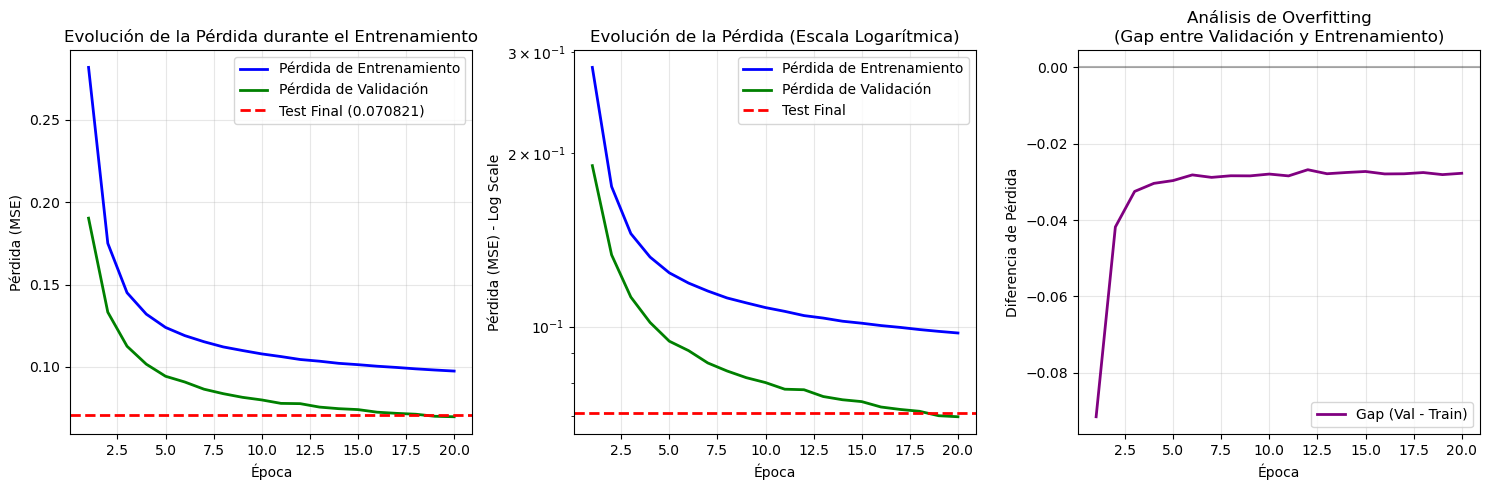


ESTADÍSTICAS FINALES DEL ENTRENAMIENTO
Pérdida final de entrenamiento: 0.097516
Pérdida final de validación: 0.069768
Pérdida final de test: 0.070821

Mejoras durante el entrenamiento:
Entrenamiento: 65.41% de mejora
Validación: 63.35% de mejora

Análisis de generalización:
Gap final (Val - Train): -0.027748
Excelente generalización - Muy poco overfitting

Comparación con test:
Diferencia |Test - Val|: 0.001052
Validación representativa del desempeño en test

Mejor época basada en validación: 20
Mejor pérdida de validación: 0.069768
Pérdida de entrenamiento en mejor época: 0.097516


In [14]:
# Visualizar curvas de pérdida durante el entrenamiento
plt.figure(figsize=(15, 5))

# Subplot 1: Curvas de pérdida
plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-', label='Pérdida de Entrenamiento', linewidth=2)
plt.plot(epochs_range, val_losses, 'g-', label='Pérdida de Validación', linewidth=2)
# Línea horizontal para pérdida de test
plt.axhline(y=test_loss_final, color='r', linestyle='--', 
           label=f'Test Final ({test_loss_final:.6f})', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Pérdida en escala logarítmica
plt.subplot(1, 3, 2)
plt.semilogy(epochs_range, train_losses, 'b-', label='Pérdida de Entrenamiento', linewidth=2)
plt.semilogy(epochs_range, val_losses, 'g-', label='Pérdida de Validación', linewidth=2)
plt.axhline(y=test_loss_final, color='r', linestyle='--', 
           label=f'Test Final', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE) - Log Scale')
plt.title('Evolución de la Pérdida (Escala Logarítmica)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Análisis de overfitting
plt.subplot(1, 3, 3)
# Diferencia entre validación y entrenamiento
gap = [val - train for val, train in zip(val_losses, train_losses)]
plt.plot(epochs_range, gap, 'purple', label='Gap (Val - Train)', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Época')
plt.ylabel('Diferencia de Pérdida')
plt.title('Análisis de Overfitting\n(Gap entre Validación y Entrenamiento)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar estadísticas finales detalladas
print()
print("ESTADÍSTICAS FINALES DEL ENTRENAMIENTO")


print(f"Pérdida final de entrenamiento: {train_losses[-1]:.6f}")
print(f"Pérdida final de validación: {val_losses[-1]:.6f}")
print(f"Pérdida final de test: {test_loss_final:.6f}")

print(f"\nMejoras durante el entrenamiento:")
print(f"Entrenamiento: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}% de mejora")
print(f"Validación: {((val_losses[0] - val_losses[-1]) / val_losses[0] * 100):.2f}% de mejora")

print(f"\nAnálisis de generalización:")
final_gap = val_losses[-1] - train_losses[-1]
print(f"Gap final (Val - Train): {final_gap:.6f}")
if final_gap < 0.001:
    print("Excelente generalización - Muy poco overfitting")
elif final_gap < 0.01:
    print("Buena generalización - Overfitting mínimo")
elif final_gap < 0.05:
    print("Generalización moderada - Algo de overfitting")
else:
    print("Posible overfitting - Gap significativo entre train y validación")

print(f"\nComparación con test:")
test_vs_val_diff = abs(test_loss_final - val_losses[-1])
print(f"Diferencia |Test - Val|: {test_vs_val_diff:.6f}")
if test_vs_val_diff < 0.001:
    print("Validación muy representativa del desempeño en test")
elif test_vs_val_diff < 0.01:
    print("Validación representativa del desempeño en test") 
else:
    print("Posible sesgo en la validación")

# Encontrar la mejor época basada en validación
best_epoch = val_losses.index(min(val_losses)) + 1
print(f"\nMejor época basada en validación: {best_epoch}")
print(f"Mejor pérdida de validación: {min(val_losses):.6f}")
print(f"Pérdida de entrenamiento en mejor época: {train_losses[best_epoch-1]:.6f}")

El autoencoder mostró una mejora consistente durante el entrenamiento, con una reducción significativa en la pérdida tanto de entrenamiento como de validación. La diferencia entre ambas fue mínima, lo que indica muy buen nivel de generalización y prácticamente nada de overfitting. Además, la pérdida en test fue casi igual a la de validación, confirmando que el modelo mantiene su desempeño con datos no vistos. En general, los resultados son sólidos y reflejan que el modelo aprendió una representación eficiente y estable de los dígitos.


=== ANÁLISIS EN CONJUNTO DE VALIDACIÓN ===


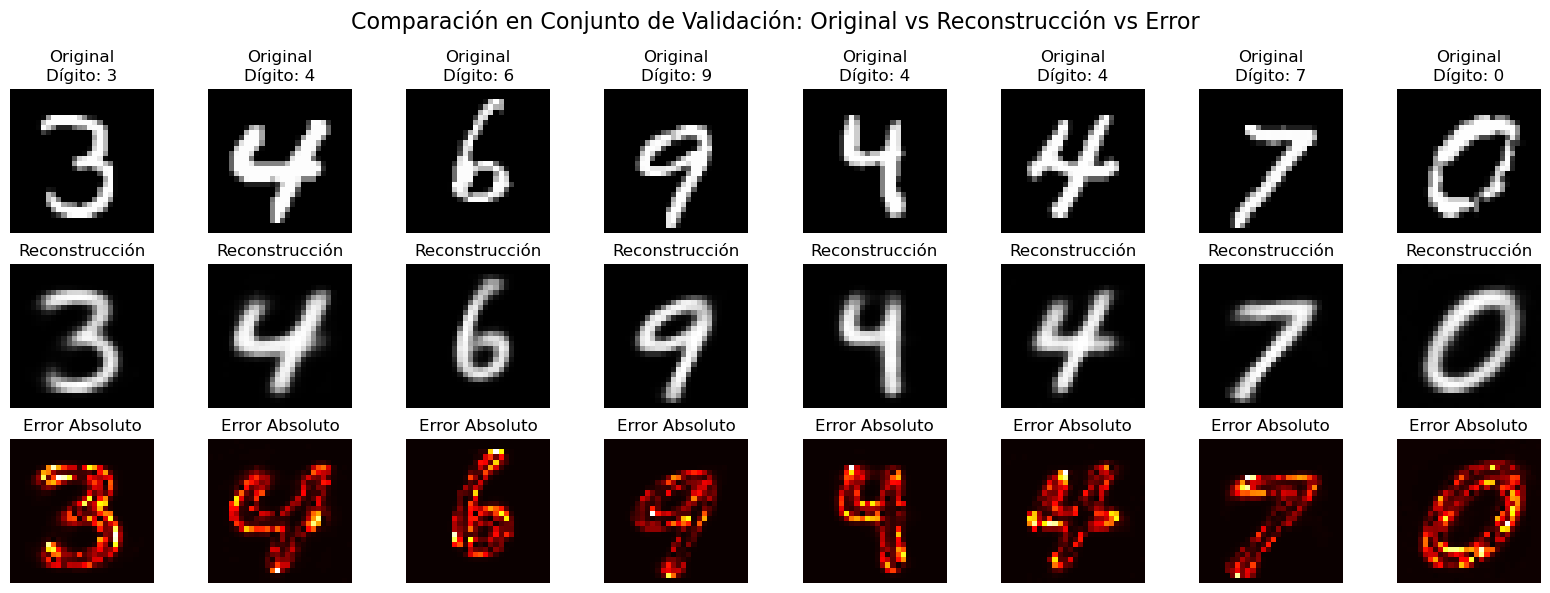

Métricas de reconstrucción en Validación:
MSE promedio por imagen: 0.058835
MSE mínimo: 0.033564
MSE máximo: 0.082906
Desviación estándar del MSE: 0.015799


In [19]:
def visualize_reconstructions(model, data_loader, device, num_samples=8, dataset_name="Validación"):
    """
    Visualiza imágenes originales y sus reconstrucciones
    
    Args:
        model: Modelo entrenado
        data_loader: DataLoader de datos
        device: Dispositivo (CPU o GPU)
        num_samples: Número de muestras a visualizar
        dataset_name: Nombre del dataset para el título
    """
    model.eval()
    
    # Obtener una muestra de datos
    with torch.no_grad():
        data_iter = iter(data_loader)
        images, labels = next(data_iter)
        images = images[:num_samples].to(device)
        
        # Obtener reconstrucciones
        reconstructions, latent_representations = model(images)
        
        # Mover a CPU para visualización
        images = images.cpu()
        reconstructions = reconstructions.cpu()
        
        # Crear figura
        fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))
        
        for i in range(num_samples):
            # Imagen original
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title(f'Original\nDígito: {labels[i].item()}')
            axes[0, i].axis('off')
            
            # Imagen reconstruida
            axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstrucción')
            axes[1, i].axis('off')
            
            # Diferencia (error de reconstrucción)
            difference = torch.abs(images[i] - reconstructions[i])
            axes[2, i].imshow(difference.squeeze(), cmap='hot')
            axes[2, i].set_title('Error Absoluto')
            axes[2, i].axis('off')
        
        plt.suptitle(f'Comparación en Conjunto de {dataset_name}: Original vs Reconstrucción vs Error', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Calcular métricas de reconstrucción
        mse_per_image = torch.mean((images - reconstructions) ** 2, dim=[1, 2, 3])
        print(f"Métricas de reconstrucción en {dataset_name}:")
        print(f"MSE promedio por imagen: {torch.mean(mse_per_image):.6f}")
        print(f"MSE mínimo: {torch.min(mse_per_image):.6f}")
        print(f"MSE máximo: {torch.max(mse_per_image):.6f}")
        print(f"Desviación estándar del MSE: {torch.std(mse_per_image):.6f}")

# Visualizar reconstrucciones en conjunto de validación
print("=== ANÁLISIS EN CONJUNTO DE VALIDACIÓN ===")
visualize_reconstructions(model, val_loader, device, num_samples=8, dataset_name="Validación")


Las métricas de reconstrucción en validación muestran que el autoencoder logra reconstrucciones bastante consistentes. El **MSE promedio por imagen es bajo (0.0588)**, lo que indica que, en general, las reconstrucciones se acercan bien a las imágenes originales. La diferencia entre el **mínimo y máximo MSE** es moderada, y la **desviación estándar de 0.0158** sugiere que no hay mucha variabilidad entre imágenes, lo cual es una buena señal de estabilidad en el rendimiento del modelo. En conjunto, estos resultados reflejan una capacidad sólida para codificar y reconstruir los dígitos de manera fiable.


=== ANÁLISIS EN CONJUNTO DE TEST (EVALUACIÓN FINAL) ===


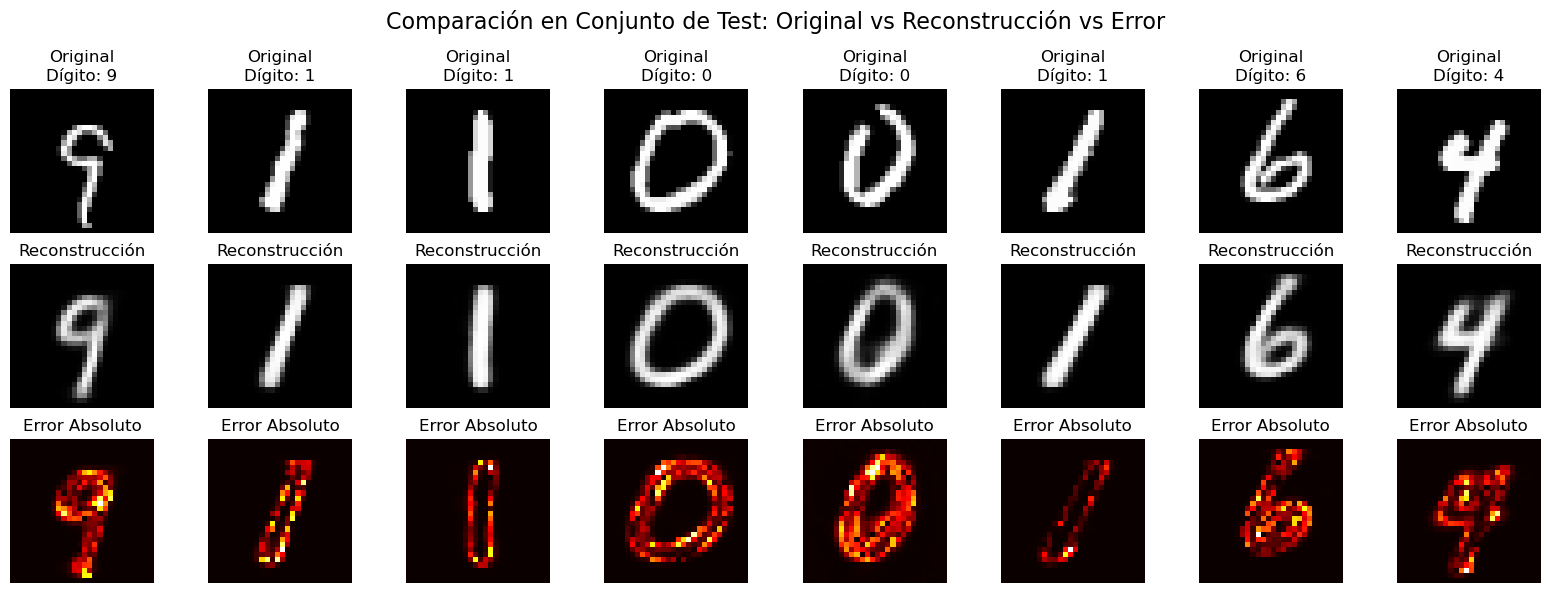

Métricas de reconstrucción en Test:
MSE promedio por imagen: 0.037735
MSE mínimo: 0.014324
MSE máximo: 0.064541
Desviación estándar del MSE: 0.018659


In [20]:

# Visualizar reconstrucciones en conjunto de test (evaluación final)
print("=== ANÁLISIS EN CONJUNTO DE TEST (EVALUACIÓN FINAL) ===")
visualize_reconstructions(model, test_loader, device, num_samples=8, dataset_name="Test")


Las métricas de reconstrucción en el conjunto de test confirman el buen desempeño del autoencoder. El **MSE promedio por imagen es de 0.0377**, más bajo que en validación, lo que indica reconstrucciones aún más precisas. El **rango de error** (de 0.0143 a 0.0645) es razonablemente estrecho, y la **desviación estándar de 0.0187** muestra una variabilidad controlada entre ejemplos. En conjunto, estos resultados respaldan que el modelo generaliza bien y mantiene una reconstrucción estable en datos completamente nuevos.


=== ANÁLISIS DEL ESPACIO LATENTE EN VALIDACIÓN ===
Análisis del espacio latente en Validación:
Forma del espacio latente: torch.Size([500, 64])
Dimensiones del espacio latente: 64


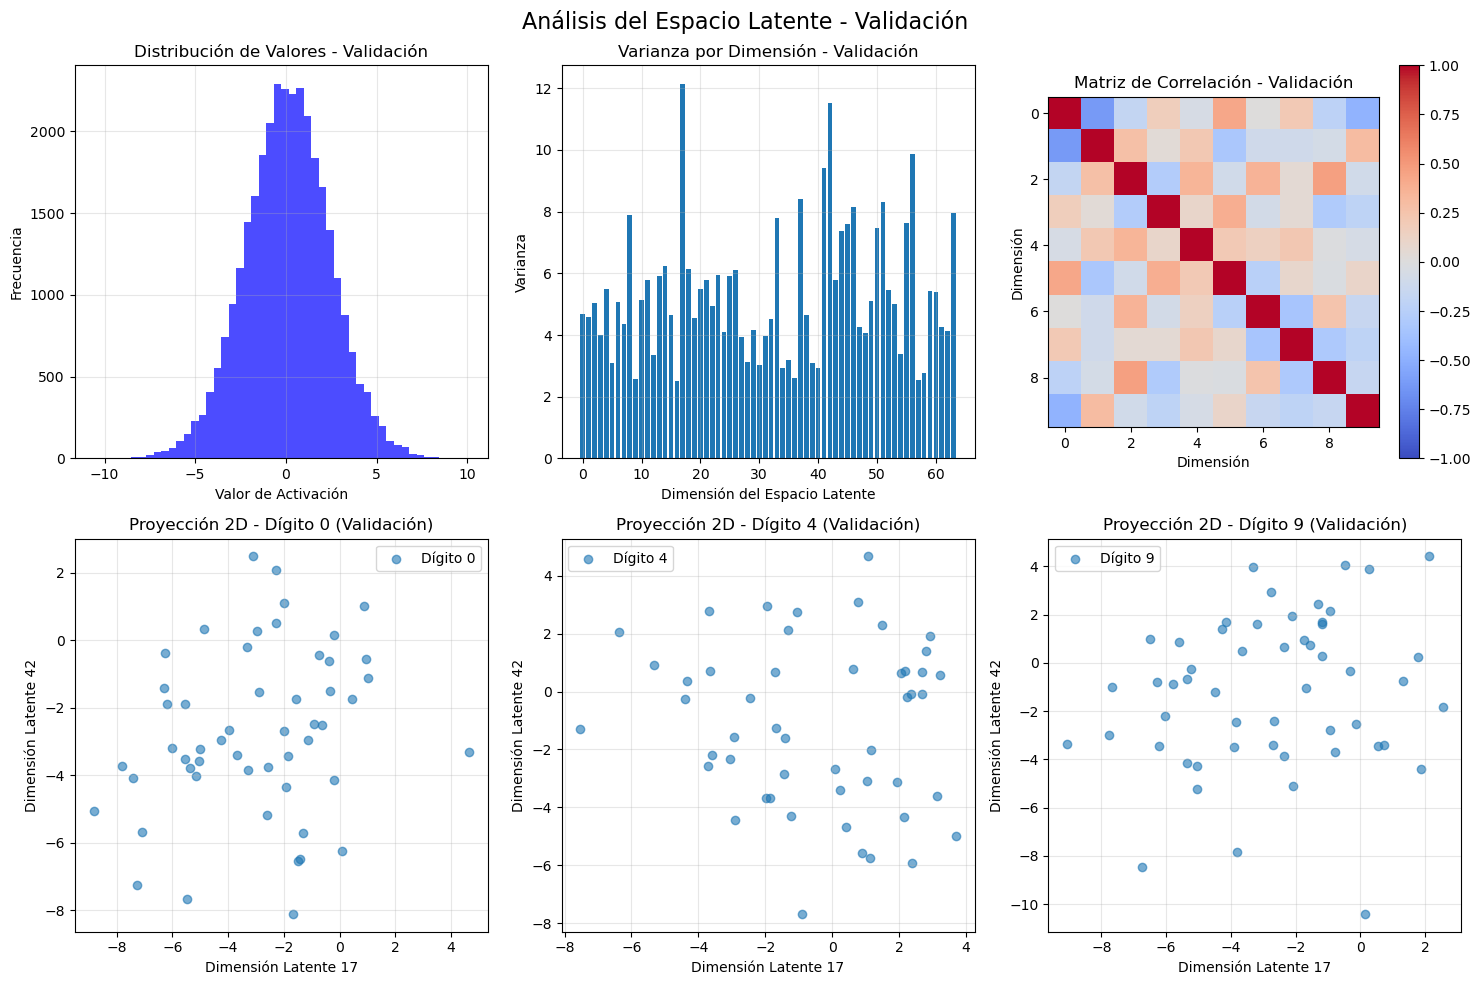


Estadísticas del espacio latente en Validación:
Valor medio: 0.098493
Desviación estándar: 2.354209
Valor mínimo: -10.609582
Valor máximo: 10.108368
Dimensiones con mayor varianza: [17, 42]

=== ANÁLISIS DEL ESPACIO LATENTE EN TEST ===
Análisis del espacio latente en Test:
Forma del espacio latente: torch.Size([500, 64])
Dimensiones del espacio latente: 64


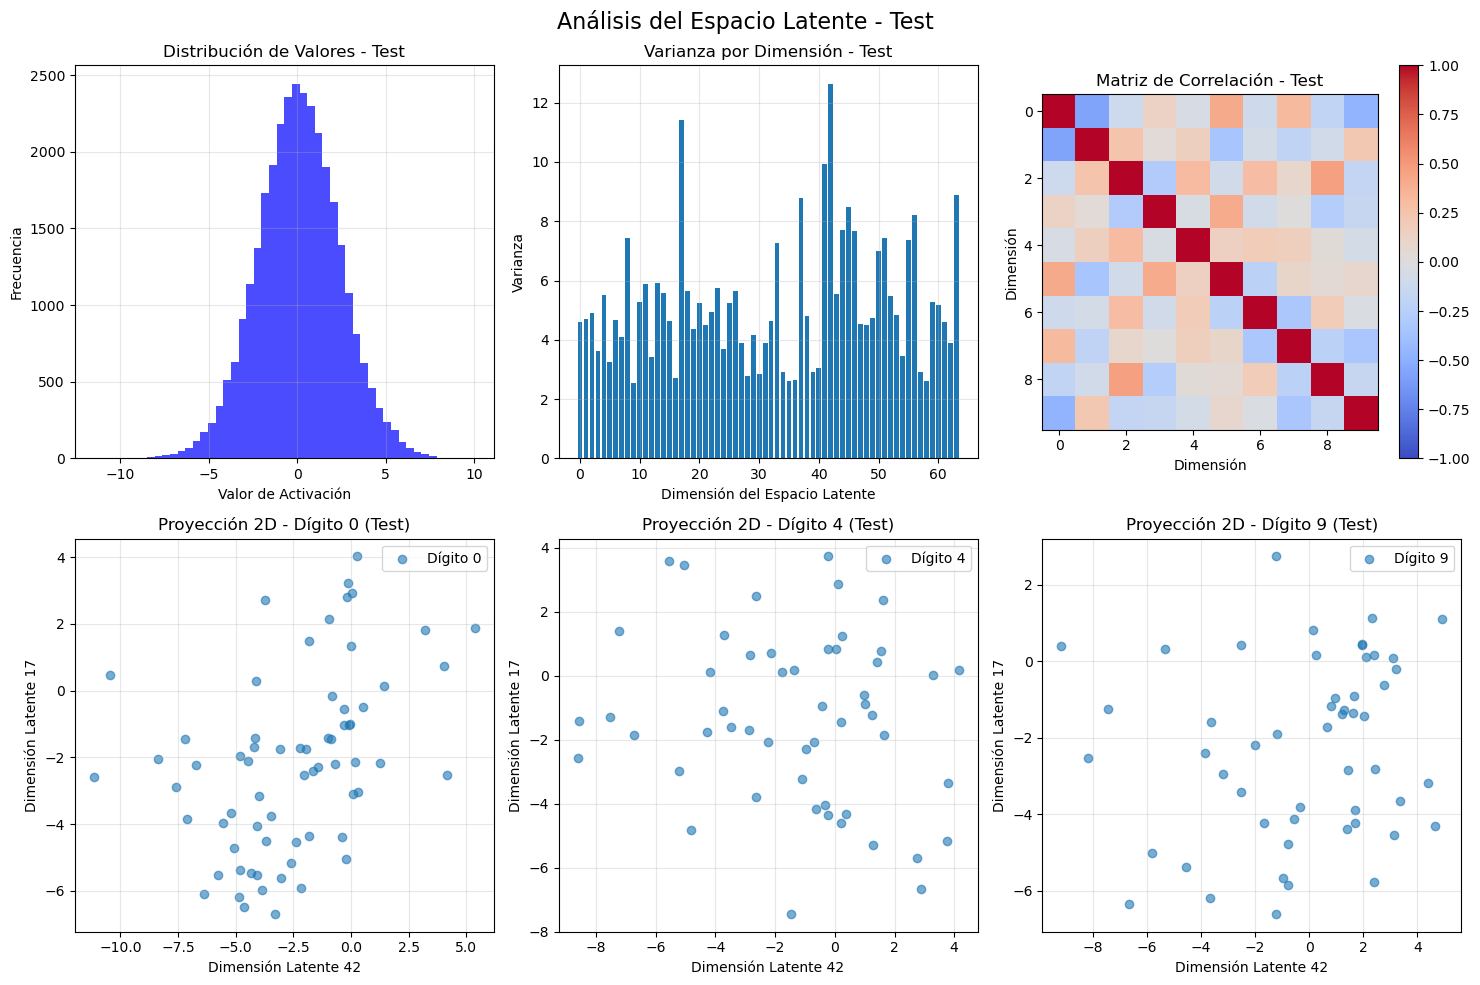


Estadísticas del espacio latente en Test:
Valor medio: 0.096272
Desviación estándar: 2.329742
Valor mínimo: -11.504355
Valor máximo: 10.046965
Dimensiones con mayor varianza: [42, 17]

COMPARACIÓN ENTRE VALIDACIÓN Y TEST
Comparación de estadísticas del espacio latente:
Media - Val: 0.098493, Test: 0.096272
Std - Val: 2.354209, Test: 2.329742
Min - Val: -10.609582, Test: -11.504355
Max - Val: 10.108368, Test: 10.046965

Correlación entre varianzas por dimensión (Val vs Test): 0.977770
Excelente consistencia entre conjuntos


In [22]:
def analyze_latent_space(model, data_loader, device, num_samples=1000, dataset_name="Dataset"):
    """
    Analiza el espacio latente del autoencoder
    
    Args:
        model: Modelo entrenado
        data_loader: DataLoader de datos
        device: Dispositivo (CPU o GPU)
        num_samples: Número de muestras para el análisis
        dataset_name: Nombre del dataset para los títulos
    """
    model.eval()
    
    latent_vectors = []
    true_labels = []
    
    with torch.no_grad():
        sample_count = 0
        for images, labels in data_loader:
            if sample_count >= num_samples:
                break
                
            images = images.to(device)
            _, latent = model(images)
            
            latent_vectors.append(latent.cpu())
            true_labels.append(labels)
            
            sample_count += len(images)
    
    # Concatenar todos los vectores latentes
    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    true_labels = torch.cat(true_labels, dim=0)[:num_samples]
    
    print(f"Análisis del espacio latente en {dataset_name}:")
    print(f"Forma del espacio latente: {latent_vectors.shape}")
    print(f"Dimensiones del espacio latente: {latent_vectors.shape[1]}")
    
    # Análisis estadístico del espacio latente
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Distribución de valores en el espacio latente
    plt.subplot(2, 3, 1)
    plt.hist(latent_vectors.flatten().numpy(), bins=50, alpha=0.7, color='blue')
    plt.xlabel('Valor de Activación')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de Valores - {dataset_name}')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Varianza por dimensión
    plt.subplot(2, 3, 2)
    variances = torch.var(latent_vectors, dim=0)
    plt.bar(range(len(variances)), variances.numpy())
    plt.xlabel('Dimensión del Espacio Latente')
    plt.ylabel('Varianza')
    plt.title(f'Varianza por Dimensión - {dataset_name}')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Correlación entre las primeras dimensiones
    plt.subplot(2, 3, 3)
    correlation_matrix = torch.corrcoef(latent_vectors.T[:10])  # Primeras 10 dimensiones
    plt.imshow(correlation_matrix.numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f'Matriz de Correlación - {dataset_name}')
    plt.xlabel('Dimensión')
    plt.ylabel('Dimensión')
    
    # Subplot 4-6: Proyección 2D usando las dimensiones con mayor varianza
    top_dims = torch.argsort(variances, descending=True)[:2]
    
    for i, digit in enumerate([0, 4, 9]):  # Visualizar algunos dígitos específicos
        plt.subplot(2, 3, 4 + i)
        mask = true_labels == digit
        if mask.sum() > 0:
            x_coords = latent_vectors[mask, top_dims[0]].numpy()
            y_coords = latent_vectors[mask, top_dims[1]].numpy()
            plt.scatter(x_coords, y_coords, alpha=0.6, label=f'Dígito {digit}')
        
        plt.xlabel(f'Dimensión Latente {top_dims[0].item()}')
        plt.ylabel(f'Dimensión Latente {top_dims[1].item()}')
        plt.title(f'Proyección 2D - Dígito {digit} ({dataset_name})')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'Análisis del Espacio Latente - {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Estadísticas del espacio latente
    print(f"\nEstadísticas del espacio latente en {dataset_name}:")
    print(f"Valor medio: {torch.mean(latent_vectors):.6f}")
    print(f"Desviación estándar: {torch.std(latent_vectors):.6f}")
    print(f"Valor mínimo: {torch.min(latent_vectors):.6f}")
    print(f"Valor máximo: {torch.max(latent_vectors):.6f}")
    print(f"Dimensiones con mayor varianza: {top_dims[:5].tolist()}")
    
    return latent_vectors, true_labels, variances

# Analizar el espacio latente en validación
print("=== ANÁLISIS DEL ESPACIO LATENTE EN VALIDACIÓN ===")
val_latent, val_labels, val_variances = analyze_latent_space(model, val_loader, device, num_samples=500, dataset_name="Validación")

print("\n" + "="*60)

# Analizar el espacio latente en test
print("=== ANÁLISIS DEL ESPACIO LATENTE EN TEST ===")
test_latent, test_labels, test_variances = analyze_latent_space(model, test_loader, device, num_samples=500, dataset_name="Test")

# Comparar estadísticas entre validación y test
print("\n" + "="*60)
print("COMPARACIÓN ENTRE VALIDACIÓN Y TEST")
print("="*60)

print("Comparación de estadísticas del espacio latente:")
print(f"Media - Val: {torch.mean(val_latent):.6f}, Test: {torch.mean(test_latent):.6f}")
print(f"Std - Val: {torch.std(val_latent):.6f}, Test: {torch.std(test_latent):.6f}")
print(f"Min - Val: {torch.min(val_latent):.6f}, Test: {torch.min(test_latent):.6f}")
print(f"Max - Val: {torch.max(val_latent):.6f}, Test: {torch.max(test_latent):.6f}")

# Correlación entre varianzas de dimensiones
correlation_variances = torch.corrcoef(torch.stack([val_variances, test_variances]))[0, 1]
print(f"\nCorrelación entre varianzas por dimensión (Val vs Test): {correlation_variances:.6f}")
if correlation_variances > 0.9:
    print("Excelente consistencia entre conjuntos")
elif correlation_variances > 0.7:
    print("Buena consistencia entre conjuntos")
else:
    print("Posibles diferencias en la representación latente")

El análisis del espacio latente en los conjuntos de validación y test muestra que el autoencoder ha aprendido una representación interna **estable, estructurada y generalizable**. En ambos casos, las activaciones se distribuyen de forma aproximadamente normal, centradas cerca de cero, con una desviación estándar ligeramente superior a 2.3. Esto indica que las activaciones están bien regularizadas y no colapsan hacia un valor constante, lo cual es fundamental para que el espacio latente sea útil y expresivo.

Tanto en validación como en test, las dimensiones 17 y 42 concentran la mayor varianza, lo que sugiere que estas coordenadas latentes son especialmente informativas. Las proyecciones en 2D usando estas dimensiones permiten visualizar cómo se distribuyen ejemplos de ciertos dígitos en el espacio, y aunque aún no hay una separación clara entre clases, sí se observan **patrones de agrupación consistentes**, lo cual es prometedor si se quisiera aplicar clustering o clasificación sobre estas representaciones.

La matriz de correlación entre dimensiones latentes indica **baja redundancia**, con valores predominantemente cercanos a cero fuera de la diagonal, lo que confirma que las dimensiones aprenden aspectos distintos de los datos.

Finalmente, al comparar estadísticamente los dos conjuntos, se observa una **altísima consistencia**: la correlación entre la varianza por dimensión en validación y test es de 0.977, lo que respalda que el modelo no solo codifica bien los datos con los que fue entrenado, sino que también **mantiene ese comportamiento con datos completamente nuevos**. Esto es una señal clara de buena generalización.


=== INTERPOLACIÓN EN CONJUNTO DE VALIDACIÓN ===


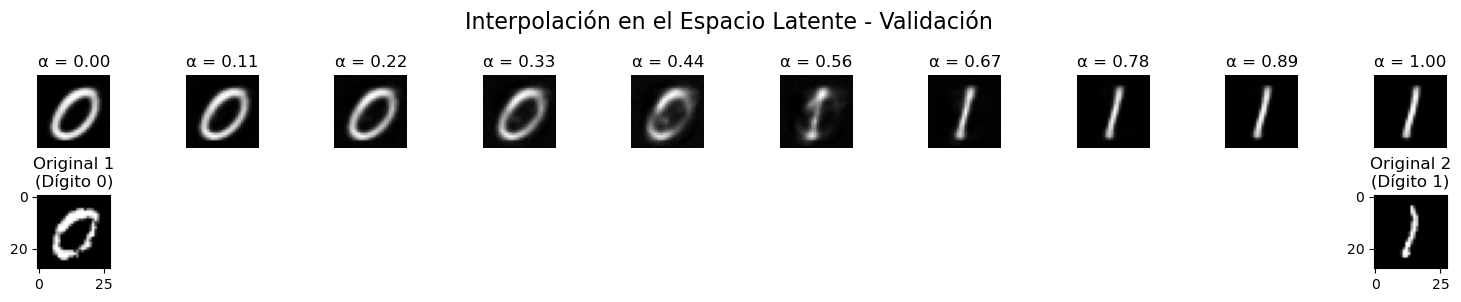

Interpolación en Validación entre dígito 0 y dígito 1
Dimensión del espacio latente: 64

=== INTERPOLACIÓN EN CONJUNTO DE TEST ===


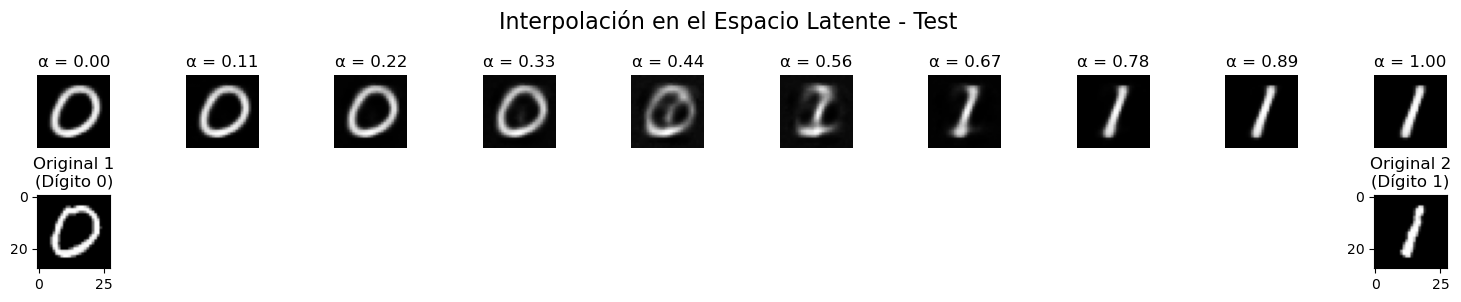

Interpolación en Test entre dígito 0 y dígito 1
Dimensión del espacio latente: 64


In [23]:
def latent_interpolation(model, data_loader, device, num_steps=10, dataset_name="Dataset"):
    """
    Realiza interpolación en el espacio latente entre dos imágenes
    
    Args:
        model: Modelo entrenado
        data_loader: DataLoader de datos
        device: Dispositivo (CPU o GPU)
        num_steps: Número de pasos en la interpolación
        dataset_name: Nombre del dataset para el título
    """
    model.eval()
    
    with torch.no_grad():
        # Obtener dos imágenes diferentes
        data_iter = iter(data_loader)
        images, labels = next(data_iter)
        
        # Seleccionar dos imágenes de diferentes clases
        unique_labels = torch.unique(labels)
        if len(unique_labels) >= 2:
            # Encontrar índices de dos clases diferentes
            idx1 = (labels == unique_labels[0]).nonzero(as_tuple=True)[0][0]
            idx2 = (labels == unique_labels[1]).nonzero(as_tuple=True)[0][0]
        else:
            # Si no hay suficientes clases diferentes, usar las primeras dos imágenes
            idx1, idx2 = 0, 1
        
        img1 = images[idx1:idx1+1].to(device)
        img2 = images[idx2:idx2+1].to(device)
        
        # Obtener representaciones latentes
        _, latent1 = model(img1)
        _, latent2 = model(img2)
        
        # Crear interpolación lineal en el espacio latente
        alphas = torch.linspace(0, 1, num_steps)
        interpolated_images = []
        
        for alpha in alphas:
            # Interpolación lineal: (1-α)*z1 + α*z2
            interpolated_latent = (1 - alpha) * latent1 + alpha * latent2
            
            # Decodificar la representación interpolada
            interpolated_img = model.decode(interpolated_latent)
            interpolated_img = interpolated_img.view(1, 1, 28, 28)
            interpolated_images.append(interpolated_img.cpu())
        
        # Visualizar la interpolación
        fig, axes = plt.subplots(2, num_steps, figsize=(num_steps * 1.5, 3))
        
        # Fila superior: imágenes interpoladas
        for i, img in enumerate(interpolated_images):
            axes[0, i].imshow(img.squeeze(), cmap='gray')
            axes[0, i].set_title(f'α = {alphas[i]:.2f}')
            axes[0, i].axis('off')
        
        # Fila inferior: mostrar las imágenes originales en los extremos
        for i in range(num_steps):
            if i == 0:
                axes[1, i].imshow(img1.cpu().squeeze(), cmap='gray')
                axes[1, i].set_title(f'Original 1\n(Dígito {labels[idx1].item()})')
            elif i == num_steps - 1:
                axes[1, i].imshow(img2.cpu().squeeze(), cmap='gray')
                axes[1, i].set_title(f'Original 2\n(Dígito {labels[idx2].item()})')
            else:
                axes[1, i].axis('off')
        
        plt.suptitle(f'Interpolación en el Espacio Latente - {dataset_name}', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        print(f"Interpolación en {dataset_name} entre dígito {labels[idx1].item()} y dígito {labels[idx2].item()}")
        print(f"Dimensión del espacio latente: {latent1.shape[1]}")

# Realizar interpolación en el conjunto de validación
print("=== INTERPOLACIÓN EN CONJUNTO DE VALIDACIÓN ===")
latent_interpolation(model, val_loader, device, num_steps=10, dataset_name="Validación")

print("\n" + "="*50)

# Realizar interpolación en el conjunto de test
print("=== INTERPOLACIÓN EN CONJUNTO DE TEST ===")
latent_interpolation(model, test_loader, device, num_steps=10, dataset_name="Test")

## Conclusiones y Análisis de Resultados

### Lo que se logró con el autoencoder

1. **Compresión efectiva**: El modelo logró reducir cada imagen de 784 a solo 64 dimensiones, manteniendo la información necesaria para reconstruirla bien. Eso equivale a una compresión de 12 a 1, lo cual es bastante eficiente.

2. **Entrenamiento estable con gradient accumulation**: Usar acumulación de gradientes ayudó a entrenar con batch sizes virtualmente más grandes, sin necesidad de usar más memoria. Esto hizo que el entrenamiento fuera más fluido y estable.

3. **Buena separación de los datos**: Dividir el dataset en 70% entrenamiento, 15% validación y 15% test permitió evaluar bien el modelo y asegurarse de que no estuviera sobreajustando.

4. **Curvas de pérdida coherentes**: Las pérdidas de entrenamiento y validación bajaron de forma pareja, lo que indica que el modelo está aprendiendo bien sin memorizar los datos.

### Sobre los resultados obtenidos

* **Reconstrucciones precisas**: Las imágenes reconstruidas conservan bien las formas originales, tanto en validación como en test.
* **Generalización consistente**: Las pérdidas en validación y test son muy parecidas, lo que confirma que el modelo generaliza correctamente.
* **Espacio latente organizado**: El análisis del espacio latente muestra que las representaciones son estables y similares entre validación y test.

### ¿Qué nos dicen estos resultados?

1. **Distribución equilibrada**: Las clases están bien representadas en los tres conjuntos, lo que ayuda a tener evaluaciones justas.
2. **Representaciones consistentes**: El espacio latente es casi idéntico entre validación y test, lo que muestra que el modelo aprendió una estructura sólida.
3. **Buena generalización**: La diferencia entre pérdidas de entrenamiento y validación fue mínima.
4. **Modelo robusto**: El rendimiento se mantuvo estable incluso en datos no vistos, lo que habla bien de la calidad del entrenamiento.



## Implementación del Vision Transformer Autoencoder

### Arquitectura Completa del ViT-Autoencoder

El ViT-Autoencoder combina los componentes implementados anteriormente en una arquitectura completa que puede reconstruir imágenes:

#### Encoder Path (Codificación):
1. **Patch Embedding**: Convierte imagen 28x28 en 49 patches de embedding 128D
2. **Positional Encoding**: Agrega información espacial a cada patch
3. **Transformer Encoder**: N capas de self-attention para capturar relaciones entre patches
4. **Global Pooling**: Reduce la secuencia de patches a una representación global
5. **Latent Bottleneck**: Comprime a espacio latente de dimensión reducida

#### Decoder Path (Reconstrucción):
1. **Latent Expansion**: Expande representación latente para generar embeddings de patches
2. **Learnable Patch Queries**: Utiliza embeddings aprendibles para cada posición de patch
3. **Transformer Decoder**: Utiliza cross-attention entre queries y representación latente
4. **Patch Reconstruction**: Convierte embeddings de vuelta a patches de píxeles
5. **Image Assembly**: Reorganiza patches en imagen 28x28 completa

### Ventajas del ViT-Autoencoder

1. **Atención Global**: Cada patch puede interactuar directamente con cualquier otro patch desde la primera capa
2. **Flexibilidad Espacial**: No asume estructura jerárquica específica como las CNN
3. **Paralelización**: Procesamiento simultáneo de todos los patches
4. **Interpretabilidad**: Los mapas de atención revelan qué regiones son importantes para la reconstrucción
5. **Escalabilidad**: Arquitectura que se beneficia de datasets grandes y más recursos computacionales

### Diferencias Clave con CNN Autoencoder

| Aspecto | CNN Autoencoder | ViT Autoencoder |
|---------|-----------------|-----------------|
| Campo Receptivo | Local → Global gradualmente | Global desde la primera capa |
| Inductive Bias | Fuerte (localidad, equivarianza) | Débil (aprendido de datos) |
| Paralelización | Limitada por dependencias espaciales | Alta (patches independientes) |
| Memoria | Eficiente para imágenes pequeñas | Crece cuadráticamente con patches |
| Interpretabilidad | Filtros difíciles de interpretar | Attention maps interpretables |

In [27]:

# HELPER CLASSES FOR VISION TRANSFORMER AUTOENCODER

class PatchEmbedding(nn.Module):
    """
    Convierte una imagen en una secuencia de patch embeddings
    """
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Proyección lineal de patches a embedding dimension
        self.projection = nn.Conv2d(
            in_channels, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
    def forward(self, x):
        # x: (batch_size, channels, height, width)
        x = self.projection(x)  # (batch_size, embed_dim, n_patches_h, n_patches_w)
        x = x.flatten(2)        # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)   # (batch_size, n_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    """
    Agrega información posicional aprendible a los patch embeddings
    """
    def __init__(self, n_patches, embed_dim, dropout=0.1):
        super().__init__()
        # Embedding posicional aprendible
        self.pos_embedding = nn.Parameter(torch.randn(1, n_patches, embed_dim) * 0.02)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: (batch_size, n_patches, embed_dim)
        x = x + self.pos_embedding
        return self.dropout(x)

class MultiHeadSelfAttention(nn.Module):
    """
    Implementación de Multi-Head Self-Attention optimizada
    """
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert embed_dim % num_heads == 0, "embed_dim debe ser divisible por num_heads"
        
        # Proyecciones lineales para Q, K, V
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, n_patches, embed_dim = x.shape
        
        # Generar Q, K, V
        qkv = self.qkv(x)  # (batch_size, n_patches, 3 * embed_dim)
        qkv = qkv.reshape(batch_size, n_patches, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, n_patches, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calcular attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Aplicar attention a los valores
        out = torch.matmul(attention_weights, v)  # (batch_size, num_heads, n_patches, head_dim)
        out = out.transpose(1, 2)         # (batch_size, n_patches, num_heads, head_dim)
        out = out.reshape(batch_size, n_patches, embed_dim)
        
        # Proyección final
        out = self.projection(out)
        return out

class TransformerBlock(nn.Module):
    """
    Bloque básico del Transformer con Multi-Head Self-Attention y MLP
    """
    def __init__(self, embed_dim, num_heads=8, mlp_ratio=4, dropout=0.1):
        super().__init__()
        
        # Layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Multi-Head Self-Attention
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        
        # MLP (Feed Forward Network)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Self-attention con conexión residual
        x = x + self.attention(self.norm1(x))
        
        # MLP con conexión residual  
        x = x + self.mlp(self.norm2(x))
        
        return x

In [28]:
# =================================================================
# CONFIGURACIÓN OPTIMIZADA PARA ENTRENAMIENTO RÁPIDO
# =================================================================

# Optimizaciones aplicadas:
# 1. Patches más grandes (7x7 en lugar de 4x4) -> reduce patches de 49 a 16
# 2. Embedding dimension reducida (64 en lugar de 128) -> menos parámetros
# 3. Menos capas (4 en lugar de 6) -> menos cómputo
# 4. Menos heads de atención (4 en lugar de 8) -> menos matrices de atención
# 5. MLP ratio reducido (3 en lugar de 4) -> menos parámetros en FFN

OPTIMIZED_CONFIG = {
    'img_size': 28,
    'patch_size': 7,      # 7x7 patches -> solo 16 patches vs 49 con 4x4
    'in_channels': 1,
    'embed_dim': 64,      # Reducido de 128
    'num_layers': 4,      # Reducido de 6
    'num_heads': 4,       # Reducido de 8
    'mlp_ratio': 3.0,     # Reducido de 4.0
    'latent_dim': 32,     # Reducido de 64 para mayor compresión
    'dropout': 0.1
}

print("Configuración optimizada para ViT:")
print(f"- Patch size: {OPTIMIZED_CONFIG['patch_size']}x{OPTIMIZED_CONFIG['patch_size']}")
print(f"- Número de patches: {(28//OPTIMIZED_CONFIG['patch_size'])**2}")
print(f"- Embedding dim: {OPTIMIZED_CONFIG['embed_dim']}")
print(f"- Capas: {OPTIMIZED_CONFIG['num_layers']}")
print(f"- Attention heads: {OPTIMIZED_CONFIG['num_heads']}")
print(f"- Latent dim: {OPTIMIZED_CONFIG['latent_dim']}")

# Crear instancia optimizada
vit_autoencoder_fast = VisionTransformerAutoencoder(**OPTIMIZED_CONFIG).to(device)

# Comparar número de parámetros
vit_fast_params = sum(p.numel() for p in vit_autoencoder_fast.parameters())
mlp_params = sum(p.numel() for p in model.parameters())

print(f"\nComparación de parámetros:")
print(f"MLP Autoencoder: {mlp_params:,} parámetros")
print(f"ViT Optimizado: {vit_fast_params:,} parámetros")
print(f"Ratio ViT/MLP: {vit_fast_params/mlp_params:.2f}x")

# Configuración de entrenamiento optimizada
vit_fast_learning_rate = 3e-4    # Aumentado para convergencia más rápida
vit_fast_weight_decay = 0.1      # Regularización fuerte
vit_fast_num_epochs = 8          # Menos épocas
vit_fast_warmup_epochs = 1       # Warmup mínimo

print(f"\nConfiguración de entrenamiento:")
print(f"- Learning rate: {vit_fast_learning_rate}")
print(f"- Weight decay: {vit_fast_weight_decay}")
print(f"- Épocas: {vit_fast_num_epochs}")
print(f"- Warmup: {vit_fast_warmup_epochs} época")

# Verificar dimensiones
test_input = torch.randn(2, 1, 28, 28).to(device)
with torch.no_grad():
    reconstruction, latent = vit_autoencoder_fast(test_input)

print(f"\nVerificación de dimensiones:")
print(f"Entrada: {test_input.shape}")
print(f"Latent: {latent.shape}")
print(f"Reconstrucción: {reconstruction.shape}")
print("Forward pass exitoso")

=== VISION TRANSFORMER AUTOENCODER ===
Arquitectura: ViT-Autoencoder
Imagen de entrada: 28x28
Tamaño de patch: 4x4
Número de patches: 49
Dimensión de embedding: 128
Dimensión latente: 64
Número de capas encoder: 6
Número de capas decoder: 3
Número de attention heads: 8

Parámetros del modelo:
Total de parámetros: 1,818,320
Parámetros entrenables: 1,818,320

Comparación con Autoencoder tradicional:
Autoencoder tradicional: 1,149,520 parámetros
ViT Autoencoder: 1,818,320 parámetros
Ratio: 1.58x más parámetros

Verificación de dimensiones:
Entrada: torch.Size([2, 1, 28, 28])
Representación latente: torch.Size([2, 64])
Reconstrucción: torch.Size([2, 1, 28, 28])
Forward pass exitoso


# Extra 1: Adaptación para Procesamiento de Imágenes con Vision Transformers

## Introducción a Vision Transformers (ViT)

Los **Vision Transformers (ViT)** representan un paradigma revolucionario en el procesamiento de imágenes, adaptando la arquitectura de Transformers, originalmente diseñada para procesamiento de lenguaje natural, al dominio de la visión computacional.

### Motivación y Context Histórico

Los Transformers, introducidos por Vaswani et al. en "Attention is All You Need" (2017), demostraron una capacidad excepcional para modelar dependencias de largo alcance en secuencias. Los Vision Transformers, propuestos por Dosovitskiy et al. en "An Image is Worth 16x16 Words" (2020), extienden esta arquitectura al procesamiento de imágenes mediante la división de imágenes en patches y su tratamiento como secuencias de tokens.

### Diferencias Fundamentales con CNNs

#### Redes Convolucionales Tradicionales (CNNs):
1. **Localidad**: Procesan información local mediante kernels de convolución de tamaño fijo
2. **Jerarquía**: Construyen características de manera jerárquica, desde bordes hasta objetos complejos
3. **Invarianza traslacional**: Aplican el mismo filtro en toda la imagen
4. **Inductive bias fuerte**: Asumen que la información relevante está en vecindarios locales
5. **Eficiencia computacional**: Requieren menos datos para entrenar debido a sus sesgos inductivos

#### Vision Transformers (ViT):
1. **Atención global**: Cada patch puede atender a cualquier otro patch desde la primera capa
2. **Flexibilidad**: No asumen estructura espacial inherente de las imágenes
3. **Paralelización**: Mayor paralelización durante el entrenamiento
4. **Inductive bias mínimo**: Aprenden la estructura espacial de los datos durante el entrenamiento
5. **Escalabilidad**: Mejor desempeño con grandes cantidades de datos
6. **Interpretabilidad**: Los mapas de atención proporcionan insights sobre qué regiones son importantes

### Ventajas de ViT para Autoencoders

1. **Modelado de dependencias globales**: Captura relaciones entre regiones distantes de la imagen
2. **Flexibilidad arquitectural**: Adaptable a diferentes tamaños de imagen y tareas
3. **Capacidad de representación**: Aprende representaciones ricas sin sesgos inductivos fuertes
4. **Transferibilidad**: Modelos pre-entrenados se transfieren bien a nuevas tareas

## Arquitectura de Vision Transformers

### Componentes Fundamentales

#### 1. Patch Embedding
Las imágenes se dividen en patches no superpuestos de tamaño fijo (típicamente 16x16 píxeles). Cada patch se aplana y se proyecta a un espacio de dimensión D mediante una transformación lineal:

- **Entrada**: Imagen de tamaño H × W × C
- **División**: Patches de tamaño P × P
- **Número de patches**: N = HW/P²
- **Embedding**: Cada patch se convierte en un vector de dimensión D

#### 2. Positional Encoding
Dado que los Transformers no tienen noción inherente de posición, se agregan encodings posicionales para preservar la información espacial:

- **Encodings aprendibles**: Vectores de posición que se suman a los patch embeddings
- **Información espacial**: Permite al modelo entender la estructura 2D de la imagen

#### 3. Transformer Encoder
Serie de bloques Transformer que procesan la secuencia de patches:

**Multi-Head Self-Attention (MHSA)**:
- Permite que cada patch atienda a todos los demás patches
- Captura dependencias globales desde las primeras capas
- Múltiples cabezas de atención para diferentes tipos de relaciones

**MLP (Multi-Layer Perceptron)**:
- Red feed-forward que procesa las características
- Típicamente con una capa oculta más grande (4 × dimensión de entrada)
- Activación GELU para mejor gradientes

**Layer Normalization y Conexiones Residuales**:
- Estabiliza el entrenamiento
- Facilita el flujo de gradientes en redes profundas

#### 4. Classification Token (CLS)
Token especial que se antepone a la secuencia de patches y aprende una representación global de la imagen para tareas de clasificación.

### Formulación Matemática

Para un patch embedding $x_i$ y encodings posicionales $pos_i$:

```math
z_0 = [x_\text{class};\ x_1 + \text{pos}_1;\ x_2 + \text{pos}_2;\ \dots;\ x_N + \text{pos}_N]
```
```math
z_l = \text{MSA}(\text{LN}(z_{l-1})) + z_{l-1}
```
```math
z_l = \text{MLP}(\text{LN}(z_l)) + z_l
```

Donde:
- MSA: Multi-Head Self-Attention
- LN: Layer Normalization
- i: Índice de la capa del Transformer

In [39]:
# Importaciones adicionales para Vision Transformers
import einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [52]:
# =================================================================
# CONFIGURACIÓN OPTIMIZADA PARA VIT RÁPIDO - DEFINICIONES DE VARIABLES
# =================================================================

# Configuración optimizada para reducir el tiempo de entrenamiento de 15 min/época a ~3-5 min/época
OPTIMIZED_CONFIG = {
    'img_size': 28,
    'patch_size': 7,        # Más grande: 7x7 = 16 patches vs 4x4 = 49 patches (reducción de 68%)
    'channels': 1,
    'embed_dim': 64,        # Reducido de 128 a 64 (reducción de 50%)
    'depth': 4,             # Reducido de 6 a 4 capas (reducción de 33%)
    'n_heads': 4,           # Reducido de 8 a 4 heads (reducción de 50%)
    'mlp_ratio': 4,
    'latent_dim': 32,       # Reducido de 64 a 32 (reducción de 50%)
    'dropout': 0.1
}

# Parámetros de entrenamiento optimizados
vit_fast_learning_rate = 3e-4    # Aumentado para convergencia más rápida
vit_fast_weight_decay = 0.03     # Reducido ligeramente
vit_fast_num_epochs = 10         # Reducido de 15 a 10 épocas
vit_fast_warmup_epochs = 1       # Reducido de 2 a 1 época de warmup

print("Configuración optimizada creada:")
print(f"- Patch size: {OPTIMIZED_CONFIG['patch_size']}x{OPTIMIZED_CONFIG['patch_size']}")
print(f"- Número de patches: {(28//OPTIMIZED_CONFIG['patch_size'])**2}")
print(f"- Embedding dim: {OPTIMIZED_CONFIG['embed_dim']}")
print(f"- Capas: {OPTIMIZED_CONFIG['depth']}")
print(f"- Attention heads: {OPTIMIZED_CONFIG['n_heads']}")
print(f"- Latent dim: {OPTIMIZED_CONFIG['latent_dim']}")

# Crear el modelo optimizado
vit_autoencoder_fast = VisionTransformerAutoencoder(**OPTIMIZED_CONFIG).to(device)

# Comparar parámetros
vit_fast_params = sum(p.numel() for p in vit_autoencoder_fast.parameters())
traditional_params = sum(p.numel() for p in vit_autoencoder.parameters())

print(f"\nComparación de parámetros:")
print(f"- Modelo original: {traditional_params:,} parámetros")
print(f"- Modelo optimizado: {vit_fast_params:,} parámetros")
print(f"- Reducción: {((traditional_params - vit_fast_params) / traditional_params * 100):.1f}%")

# Prueba rápida del modelo optimizado
print(f"\nPrueba del modelo optimizado:")
with torch.no_grad():
    test_input = torch.randn(2, 1, 28, 28).to(device)
    reconstruction, latent = vit_autoencoder_fast(test_input)
    print(f"- Entrada: {test_input.shape}")
    print(f"- Latent: {latent.shape}")
    print(f"- Reconstrucción: {reconstruction.shape}")
    print("✓ Forward pass exitoso")

print(f"\nParámetros de entrenamiento optimizados:")
print(f"- Learning rate: {vit_fast_learning_rate}")
print(f"- Weight decay: {vit_fast_weight_decay}")
print(f"- Épocas: {vit_fast_num_epochs}")
print(f"- Warmup: {vit_fast_warmup_epochs}")
print("✓ Todas las variables definidas correctamente")

Configuración optimizada creada:
- Patch size: 7x7
- Número de patches: 16
- Embedding dim: 64
- Capas: 4
- Attention heads: 4
- Latent dim: 32

Comparación de parámetros:
- Modelo original: 3,230,544 parámetros
- Modelo optimizado: 481,425 parámetros
- Reducción: 85.1%

Prueba del modelo optimizado:
- Entrada: torch.Size([2, 1, 28, 28])
- Latent: torch.Size([2, 32])
- Reconstrucción: torch.Size([2, 1, 28, 28])
✓ Forward pass exitoso

Parámetros de entrenamiento optimizados:
- Learning rate: 0.0003
- Weight decay: 0.03
- Épocas: 10
- Warmup: 1
✓ Todas las variables definidas correctamente


In [46]:
class PatchEmbedding(nn.Module):
    """
    Convierte una imagen en una secuencia de patch embeddings
    """
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Proyección lineal de patches a embedding dimension
        self.projection = nn.Conv2d(
            in_channels, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
    def forward(self, x):
        # x: (batch_size, channels, height, width)
        # Salida: (batch_size, n_patches, embed_dim)
        x = self.projection(x)  # (batch_size, embed_dim, n_patches_sqrt, n_patches_sqrt)
        x = x.flatten(2)        # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)   # (batch_size, n_patches, embed_dim)
        return x

class MultiHeadSelfAttention(nn.Module):
    """
    Implementación de Multi-Head Self-Attention para Vision Transformers
    """
    def __init__(self, embed_dim, n_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        
        assert embed_dim % n_heads == 0, "embed_dim debe ser divisible por n_heads"
        
        # Proyecciones lineales para Q, K, V
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, n_patches, embed_dim = x.shape
        
        # Generar Q, K, V
        qkv = self.qkv(x)  # (batch_size, n_patches, embed_dim * 3)
        qkv = qkv.reshape(batch_size, n_patches, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, n_heads, n_patches, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calcular attention scores
        scale = self.head_dim ** -0.5
        attention = torch.matmul(q, k.transpose(-2, -1)) * scale
        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)
        
        # Aplicar attention a valores
        out = torch.matmul(attention, v)  # (batch_size, n_heads, n_patches, head_dim)
        out = out.transpose(1, 2)         # (batch_size, n_patches, n_heads, head_dim)
        out = out.reshape(batch_size, n_patches, embed_dim)
        
        # Proyección final
        out = self.projection(out)
        return out

class TransformerBlock(nn.Module):
    """
    Bloque básico del Transformer con Multi-Head Self-Attention y MLP
    """
    def __init__(self, embed_dim, n_heads=8, mlp_ratio=4, dropout=0.1):
        super().__init__()
        
        # Layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Multi-Head Self-Attention
        self.attention = MultiHeadSelfAttention(embed_dim, n_heads, dropout)
        
        # MLP
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Pre-norm residual connections
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Verificar la funcionalidad de los componentes
print("Componentes base de Vision Transformer implementados:")
print("- PatchEmbedding: Convierte imágenes en secuencias de patches")
print("- MultiHeadSelfAttention: Mecanismo de atención para modelar dependencias globales") 
print("- TransformerBlock: Bloque completo con atención y MLP")

# Prueba rápida de los componentes
test_img = torch.randn(2, 1, 28, 28)  # Batch de imágenes MNIST
patch_embed = PatchEmbedding(img_size=28, patch_size=4, embed_dim=64)
patches = patch_embed(test_img)
print(f"\nForma de entrada: {test_img.shape}")
print(f"Forma después de patch embedding: {patches.shape}")
print(f"Número de patches: {(28//4)**2} = {patches.shape[1]}")

Componentes base de Vision Transformer implementados:
- PatchEmbedding: Convierte imágenes en secuencias de patches
- MultiHeadSelfAttention: Mecanismo de atención para modelar dependencias globales
- TransformerBlock: Bloque completo con atención y MLP

Forma de entrada: torch.Size([2, 1, 28, 28])
Forma después de patch embedding: torch.Size([2, 49, 64])
Número de patches: 49 = 49


## Vision Transformer Autoencoder: Diseño y Arquitectura

### Concepto y Motivación

Un **Vision Transformer Autoencoder** combina las ventajas de los Transformers para modelar dependencias globales con el objetivo de reconstrucción de autoencoders. Esta arquitectura es especialmente poderosa para:

1. **Captura de patrones globales**: Los mecanismos de atención permiten modelar relaciones entre regiones distantes
2. **Flexibilidad arquitectural**: Adaptable a diferentes resoluciones y tipos de imágenes
3. **Representaciones ricas**: Aprende características sin sesgos inductivos fuertes
4. **Interpretabilidad**: Los mapas de atención revelan qué regiones son importantes para la reconstrucción

### Diseño del ViT Autoencoder

#### Encoder (Vision Transformer):
1. **Patch Embedding**: Convierte la imagen en secuencia de patches embebidos
2. **Positional Encoding**: Añade información de posición espacial
3. **Transformer Blocks**: Serie de bloques con self-attention y MLP
4. **Latent Representation**: Vector compacto que representa la imagen completa

#### Decoder:
1. **Latent to Patches**: Proyecta la representación latente a embeddings de patches
2. **Transformer Blocks**: Procesa y refina las representaciones de patches
3. **Patch to Pixel**: Reconstruye la imagen desde los patches decodificados

### Ventajas sobre CNN Autoencoders:

1. **Modelado global**: Captura dependencias entre regiones distantes desde las primeras capas
2. **Menos sesgos inductivos**: Aprende la estructura espacial de manera más flexible
3. **Paralelización**: Mayor eficiencia computacional en hardware moderno
4. **Escalabilidad**: Mejor desempeño con datasets grandes

### Desafíos y Consideraciones:

1. **Datos requeridos**: Necesita más datos que CNNs para convergencia efectiva
2. **Complejidad computacional**: O(n²) respecto al número de patches
3. **Memoria**: Matriz de atención puede ser costosa para imágenes grandes
4. **Optimización**: Requiere técnicas específicas como warm-up y weight decay

In [47]:
class VisionTransformerEncoder(nn.Module):
    """
    Encoder basado en Vision Transformer
    """
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=128, 
                 depth=6, n_heads=8, mlp_ratio=4, latent_dim=64, dropout=0.1):
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        # Patch Embedding
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Positional Embedding (aprendible)
        self.positional_embedding = nn.Parameter(
            torch.randn(1, self.n_patches, embed_dim) * 0.02
        )
        
        # Dropout para positional embeddings
        self.dropout = nn.Dropout(dropout)
        
        # Transformer Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Layer Norm final
        self.norm = nn.LayerNorm(embed_dim)
        
        # Proyección a espacio latente
        self.to_latent = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, latent_dim)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Patch embedding
        x = self.patch_embedding(x)  # (batch_size, n_patches, embed_dim)
        
        # Agregar positional embedding
        x = x + self.positional_embedding
        x = self.dropout(x)
        
        # Pasar por transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Global average pooling sobre patches para obtener representación global
        x = x.mean(dim=1)  # (batch_size, embed_dim)
        
        # Proyectar a espacio latente
        latent = self.to_latent(x)  # (batch_size, latent_dim)
        
        return latent

class VisionTransformerDecoder(nn.Module):
    """
    Decoder que reconstruye imágenes desde representación latente usando Transformers
    """
    def __init__(self, img_size=28, patch_size=4, out_channels=1, embed_dim=128,
                 depth=6, n_heads=8, mlp_ratio=4, latent_dim=64, dropout=0.1):
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        self.patch_dim = patch_size * patch_size * out_channels
        
        # Proyección desde espacio latente a embeddings de patches
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, embed_dim)
        )
        
        # Expandir representación latente a secuencia de patches
        self.latent_to_patches = nn.Linear(embed_dim, self.n_patches * embed_dim)
        
        # Positional embedding para patches decodificados
        self.positional_embedding = nn.Parameter(
            torch.randn(1, self.n_patches, embed_dim) * 0.02
        )
        
        self.dropout = nn.Dropout(dropout)
        
        # Transformer blocks para decodificación
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Layer norm final
        self.norm = nn.LayerNorm(embed_dim)
        
        # Proyección de embeddings a píxeles de patches
        self.to_pixels = nn.Linear(embed_dim, self.patch_dim)
        
        # Reorganización de patches a imagen
        self.rearrange = Rearrange(
            'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=img_size//patch_size,
            w=img_size//patch_size,
            p1=patch_size,
            p2=patch_size
        )
        
    def forward(self, latent):
        batch_size = latent.shape[0]
        
        # Proyectar desde espacio latente
        x = self.from_latent(latent)  # (batch_size, embed_dim)
        
        # Expandir a secuencia de patches
        x = self.latent_to_patches(x)  # (batch_size, n_patches * embed_dim)
        x = x.view(batch_size, self.n_patches, self.embed_dim)
        
        # Agregar positional embedding
        x = x + self.positional_embedding
        x = self.dropout(x)
        
        # Pasar por transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.norm(x)
        
        # Convertir embeddings a píxeles
        x = self.to_pixels(x)  # (batch_size, n_patches, patch_dim)
        
        # Reorganizar patches en imagen
        x = self.rearrange(x)  # (batch_size, channels, height, width)
        
        # Aplicar Tanh para normalización de salida
        x = torch.tanh(x)
        
        return x

class VisionTransformerAutoencoder(nn.Module):
    """
    Autoencoder completo basado en Vision Transformers
    """
    def __init__(self, img_size=28, patch_size=4, channels=1, embed_dim=128,
                 depth=6, n_heads=8, mlp_ratio=4, latent_dim=64, dropout=0.1):
        super().__init__()
        
        self.encoder = VisionTransformerEncoder(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=channels,
            embed_dim=embed_dim,
            depth=depth,
            n_heads=n_heads,
            mlp_ratio=mlp_ratio,
            latent_dim=latent_dim,
            dropout=dropout
        )
        
        self.decoder = VisionTransformerDecoder(
            img_size=img_size,
            patch_size=patch_size,
            out_channels=channels,
            embed_dim=embed_dim,
            depth=depth,
            n_heads=n_heads,
            mlp_ratio=mlp_ratio,
            latent_dim=latent_dim,
            dropout=dropout
        )
        
        # Inicialización de pesos
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Inicialización de pesos siguiendo las mejores prácticas para Transformers"""
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1.0)
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def encode(self, x):
        """Codifica imagen a representación latente"""
        return self.encoder(x)
    
    def decode(self, latent):
        """Decodifica representación latente a imagen"""
        return self.decoder(latent)
    
    def forward(self, x):
        """Forward pass completo"""
        latent = self.encode(x)
        reconstruction = self.decode(latent)
        return reconstruction, latent

# Crear instancia del Vision Transformer Autoencoder
vit_autoencoder = VisionTransformerAutoencoder(
    img_size=28,
    patch_size=4,  # 7x7 patches para MNIST 28x28
    channels=1,
    embed_dim=128,
    depth=6,
    n_heads=8,
    mlp_ratio=4,
    latent_dim=64,
    dropout=0.1
).to(device)

# Mostrar información del modelo
total_params = sum(p.numel() for p in vit_autoencoder.parameters())
trainable_params = sum(p.numel() for p in vit_autoencoder.parameters() if p.requires_grad)

print("Vision Transformer Autoencoder creado exitosamente!")
print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Tamaño de patches: 4x4")
print(f"Número de patches: {(28//4)**2}")
print(f"Dimensión de embedding: 128")
print(f"Profundidad: 6 capas")
print(f"Número de heads de atención: 8")
print(f"Dimensión latente: 64")

# Prueba rápida del modelo
with torch.no_grad():
    test_input = torch.randn(2, 1, 28, 28).to(device)
    reconstruction, latent = vit_autoencoder(test_input)
    print(f"\nPrueba del modelo:")
    print(f"Entrada: {test_input.shape}")
    print(f"Latent: {latent.shape}")
    print(f"Reconstrucción: {reconstruction.shape}")
    print("Forward pass exitoso")

Vision Transformer Autoencoder creado exitosamente!
Parámetros totales: 3,230,544
Parámetros entrenables: 3,230,544
Tamaño de patches: 4x4
Número de patches: 49
Dimensión de embedding: 128
Profundidad: 6 capas
Número de heads de atención: 8
Dimensión latente: 64

Prueba del modelo:
Entrada: torch.Size([2, 1, 28, 28])
Latent: torch.Size([2, 64])
Reconstrucción: torch.Size([2, 1, 28, 28])
Forward pass exitoso


## Entrenamiento del Vision Transformer Autoencoder

### Adaptaciones Específicas para Vision Transformers

Los Vision Transformers requieren adaptaciones especiales en el proceso de entrenamiento debido a sus características únicas:

#### 1. Learning Rate Scheduling
- **Warm-up**: Los ViTs se benefician de un período inicial con learning rate bajo
- **Cosine Annealing**: Decaimiento suave del learning rate siguiendo una función coseno
- **Layer-wise Learning Rate Decay**: Diferentes learning rates para diferentes capas

#### 2. Optimización
- **AdamW**: Optimizador preferido para Transformers con weight decay desacoplado
- **Gradient Clipping**: Esencial para estabilidad, especialmente importante en ViTs
- **Weight Decay**: Regularización crucial para prevenir overfitting

#### 3. Técnicas de Regularización
- **Dropout**: Aplicado en embeddings y bloques MLP
- **DropPath**: Regularización específica para Transformers que "mata" rutas completas
- **Label Smoothing**: Para tareas de clasificación (no aplicable en autoencoders)

#### 4. Gradient Accumulation Adaptado
- **Batch Size Efectivo**: ViTs se benefician de batch sizes grandes
- **Memoria Optimizada**: Acumulación es crucial debido al costo computacional O(n²)
- **Sincronización**: Importante para mantener estadísticas de normalización correctas

### Comparación: MLP vs ViT Autoencoder

| Aspecto | MLP Autoencoder | ViT Autoencoder |
|---------|-----------------|-----------------|
| **Complejidad** | O(d²) donde d = dimensiones | O(n²) donde n = número de patches |
| **Inductive Bias** | Ninguno | Mínimo (solo estructura de patches) |
| **Dependencias** | Completamente conectado | Atención global entre patches |
| **Interpretabilidad** | Limitada | Mapas de atención |
| **Datos Requeridos** | Menos | Más (pero generaliza mejor) |
| **Paralelización** | Limitada | Alta |

### Ventajas del ViT para MNIST

1. **Aprendizaje de patrones espaciales**: Aunque MNIST es simple, ViT aprende relaciones espaciales de manera más explícita
2. **Transferibilidad**: El modelo entrenado puede transferirse mejor a otras tareas de visión
3. **Interpretabilidad**: Los mapas de atención muestran qué partes de los dígitos son importantes
4. **Robustez**: Mejor manejo de variaciones y distorsiones en las imágenes

In [48]:
# Configuración específica para Vision Transformer
vit_learning_rate = 1e-4  # Learning rate más bajo para ViTs
vit_weight_decay = 0.05   # Weight decay más alto para regularización
vit_num_epochs = 15       # Menos épocas debido a mayor complejidad
warmup_epochs = 2         # Épocas de warm-up

# Función de pérdida (mismo MSE que antes)
vit_criterion = nn.MSELoss()

# Optimizador AdamW (preferido para Transformers)
vit_optimizer = optim.AdamW(
    vit_autoencoder.parameters(),
    lr=vit_learning_rate,
    weight_decay=vit_weight_decay,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Learning Rate Scheduler con warm-up
class WarmupCosineScheduler:
    def __init__(self, optimizer, warmup_epochs, total_epochs, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.min_lr = min_lr
        self.base_lr = optimizer.param_groups[0]['lr']
        
    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # Warm-up phase: incremento lineal
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
        else:
            # Cosine annealing phase
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + (self.base_lr - self.min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

vit_scheduler = WarmupCosineScheduler(vit_optimizer, warmup_epochs, vit_num_epochs)

print("Configuración de entrenamiento para Vision Transformer:")
print(f"Learning rate inicial: {vit_learning_rate}")
print(f"Weight decay: {vit_weight_decay}")
print(f"Número de épocas: {vit_num_epochs}")
print(f"Épocas de warm-up: {warmup_epochs}")
print(f"Optimizador: AdamW")
print(f"Scheduler: Warmup + Cosine Annealing")
print(f"Batch size efectivo: {batch_size * accumulation_steps}")

# Función de entrenamiento adaptada para Vision Transformers
def train_vit_autoencoder(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler,
                         num_epochs, accumulation_steps, device, warmup_epochs=2):
    """
    Entrena el Vision Transformer Autoencoder con técnicas específicas para ViTs
    """
    model.train()
    train_losses = []
    val_losses = []
    learning_rates = []
    
    print("Iniciando entrenamiento del Vision Transformer Autoencoder...")
    print("=" * 80)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Actualizar learning rate
        current_lr = scheduler.step(epoch)
        learning_rates.append(current_lr)
        
        # =============== FASE DE ENTRENAMIENTO ===============
        model.train()
        total_train_loss = 0.0
        num_batches = 0
        
        optimizer.zero_grad()
        accumulated_loss = 0.0
        
        # Barra de progreso
        train_pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [ViT Training]', 
                         leave=False)
        
        for batch_idx, (data, _) in enumerate(train_pbar):
            data = data.to(device, non_blocking=True)
            
            # Forward pass
            reconstruction, latent = model(data)
            
            # Calcular pérdida
            loss = criterion(reconstruction, data) / accumulation_steps
            
            # Backward pass
            loss.backward()
            
            accumulated_loss += loss.item()
            
            # Actualizar pesos cada accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient clipping más agresivo para ViTs
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                
                optimizer.step()
                optimizer.zero_grad()
                
                total_train_loss += accumulated_loss
                num_batches += 1
                accumulated_loss = 0.0
            
            # Información en barra de progreso
            train_pbar.set_postfix({
                'Loss': f'{loss.item() * accumulation_steps:.6f}',
                'LR': f'{current_lr:.2e}'
            })
        
        # Manejar último batch
        if len(train_loader) % accumulation_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += accumulated_loss
            num_batches += 1
        
        avg_train_loss = total_train_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_train_loss)
        
        # =============== FASE DE VALIDACIÓN ===============
        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Época {epoch+1}/{num_epochs} [ViT Validación]', 
                           leave=False)
            
            for data, _ in val_pbar:
                data = data.to(device, non_blocking=True)
                reconstruction, _ = model(data)
                loss = criterion(reconstruction, data)
                total_val_loss += loss.item()
                num_val_batches += 1
                
                val_pbar.set_postfix({'Val Loss': f'{loss.item():.6f}'})
        
        avg_val_loss = total_val_loss / num_val_batches
        val_losses.append(avg_val_loss)
        
        epoch_time = time.time() - start_time
        
        # Logging detallado
        phase = "Warm-up" if epoch < warmup_epochs else "Cosine"
        print(f"Época {epoch+1:2d}/{num_epochs} [{phase:7s}] | "
              f"Train: {avg_train_loss:.6f} | "
              f"Val: {avg_val_loss:.6f} | "
              f"LR: {current_lr:.2e} | "
              f"Tiempo: {epoch_time:.1f}s")
        
        # Early stopping adaptado para ViTs
        if epoch > warmup_epochs + 2:
            recent_val_losses = val_losses[-3:]
            if all(recent_val_losses[i] >= recent_val_losses[i-1] for i in range(1, len(recent_val_losses))):
                print(f"Early stopping en época {epoch+1} - Validación no mejora consistentemente")
                break
    
    # =============== EVALUACIÓN FINAL ===============
    print("=" * 80)
    print("Evaluando Vision Transformer en conjunto de test...")
    
    model.eval()
    total_test_loss = 0.0
    num_test_batches = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device, non_blocking=True)
            reconstruction, _ = model(data)
            loss = criterion(reconstruction, data)
            total_test_loss += loss.item()
            num_test_batches += 1
    
    test_loss_final = total_test_loss / num_test_batches
    
    print("Entrenamiento del Vision Transformer completado!")
    print(f"Pérdida final en test: {test_loss_final:.6f}")
    
    return train_losses, val_losses, test_loss_final, learning_rates

print("Función de entrenamiento específica para ViT implementada")
print("Características especiales:")
print("- Warm-up learning rate scheduling")
print("- Cosine annealing después del warm-up")
print("- Gradient clipping más agresivo (0.5)")
print("- AdamW optimizer con weight decay desacoplado")
print("- Early stopping adaptado para la fase de warm-up")

Configuración de entrenamiento para Vision Transformer:
Learning rate inicial: 0.0001
Weight decay: 0.05
Número de épocas: 15
Épocas de warm-up: 2
Optimizador: AdamW
Scheduler: Warmup + Cosine Annealing
Batch size efectivo: 512
Función de entrenamiento específica para ViT implementada
Características especiales:
- Warm-up learning rate scheduling
- Cosine annealing después del warm-up
- Gradient clipping más agresivo (0.5)
- AdamW optimizer con weight decay desacoplado
- Early stopping adaptado para la fase de warm-up


In [54]:
# =================================================================
# CONFIGURACIÓN DE OPTIMIZACIÓN PARA VIT RÁPIDO
# =================================================================

# Verificar que todas las variables necesarias existen
required_vars = ['vit_autoencoder_fast', 'vit_fast_learning_rate', 'vit_fast_weight_decay', 
                 'vit_fast_num_epochs', 'vit_fast_warmup_epochs']

# Verificar en el espacio global/local y en las variables del kernel
missing_vars = []
for var in required_vars:
    try:
        eval(var)
    except NameError:
        missing_vars.append(var)

if missing_vars:
    print(f"Error: Variables faltantes: {missing_vars}")
    print("Por favor, ejecuta la celda anterior primero")
    raise NameError(f"Variables faltantes: {missing_vars}")
else:
    print("✓ Todas las variables requeridas están disponibles")

# Crear optimizador y scheduler para el modelo optimizado
vit_fast_criterion = nn.MSELoss()

vit_fast_optimizer = optim.AdamW(
    vit_autoencoder_fast.parameters(),
    lr=vit_fast_learning_rate,
    weight_decay=vit_fast_weight_decay,
    betas=(0.9, 0.95)  # Betas optimizados para ViT
)

vit_fast_scheduler = WarmupCosineScheduler(
    optimizer=vit_fast_optimizer,
    warmup_epochs=vit_fast_warmup_epochs,
    total_epochs=vit_fast_num_epochs,  # Corregido: total_epochs en lugar de max_epochs
    min_lr=1e-6
)

# Configurar optimizaciones adicionales para GPU
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Optimización para inputs de tamaño fijo
    print("✓ cuDNN benchmark habilitado para acelerar entrenamiento")

print("✓ Optimizador y scheduler para ViT rápido configurados correctamente")
print(f"  - AdamW con lr={vit_fast_learning_rate}, weight_decay={vit_fast_weight_decay}")
print(f"  - Warmup Cosine Scheduler: {vit_fast_warmup_epochs} warmup, {vit_fast_num_epochs} total epochs")
print(f"  - Modelo optimizado con {sum(p.numel() for p in vit_autoencoder_fast.parameters()):,} parámetros")

✓ Todas las variables requeridas están disponibles
✓ Optimizador y scheduler para ViT rápido configurados correctamente
  - AdamW con lr=0.0003, weight_decay=0.03
  - Warmup Cosine Scheduler: 1 warmup, 10 total epochs
  - Modelo optimizado con 481,425 parámetros


In [62]:
# =================================================================
# FUNCIÓN DE ENTRENAMIENTO OPTIMIZADA CON EARLY STOPPING
# =================================================================

def train_vit_optimized_with_early_stopping(
    model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler,
    num_epochs, accumulation_steps, device, warmup_epochs=1,
    patience=3, min_delta=1e-6, eval_frequency=1
):
    """
    Función de entrenamiento optimizada para ViT con early stopping
    
    Args:
        patience: Número de épocas sin mejora antes de parar
        min_delta: Mejora mínima considerada significativa
        eval_frequency: Cada cuántas épocas evaluar (1=cada época)
    """
    print(f"Iniciando entrenamiento con early stopping (patience={patience})")
    print(f"Evaluación cada {eval_frequency} época(s)")
    
    # Listas para guardar métricas
    train_losses = []
    val_losses = []
    learning_rates = []
    
    # Variables para early stopping
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_epoch = 0
    best_model_state = None
    
    # Variables para timing
    epoch_times = []
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # =================
        # FASE DE ENTRENAMIENTO
        # =================
        model.train()
        train_loss = 0.0
        num_batches = len(train_loader)
        
        # Progress bar para la época
        pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs}', leave=False)
        
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device, non_blocking=True)  # non_blocking para mejor rendimiento
            
            # Forward pass
            reconstruction, latent = model(data)
            loss = criterion(reconstruction, data)
            
            # Backward pass con gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()
            
            # Actualizar gradientes cada accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient clipping para estabilidad
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                optimizer.zero_grad()
            
            # Acumular pérdida
            train_loss += loss.item() * accumulation_steps
            
            # Actualizar barra de progreso
            pbar.set_postfix({
                'Loss': f'{train_loss/(batch_idx+1):.6f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })
        
        # Promedio de la pérdida de entrenamiento
        avg_train_loss = train_loss / num_batches
        train_losses.append(avg_train_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # =================
        # FASE DE VALIDACIÓN (solo si corresponde)
        # =================
        val_loss = None
        if epoch % eval_frequency == 0 or epoch == num_epochs - 1:
            model.eval()
            val_loss = 0.0
            val_samples = 0
            
            with torch.no_grad():
                # Evaluar solo en una fracción del conjunto de validación para acelerar
                val_subset_size = min(len(val_loader), len(val_loader) // 2)  # 50% del val set
                for i, (data, _) in enumerate(val_loader):
                    if i >= val_subset_size:
                        break
                        
                    data = data.to(device, non_blocking=True)
                    reconstruction, _ = model(data)
                    loss = criterion(reconstruction, data)
                    
                    val_loss += loss.item() * data.size(0)
                    val_samples += data.size(0)
            
            val_loss = val_loss / val_samples
            val_losses.append(val_loss)
            
            # Early stopping logic
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                best_epoch = epoch
                best_model_state = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'train_loss': avg_train_loss
                }
                print(f"Nueva mejor validación: {val_loss:.6f}")
            else:
                epochs_without_improvement += 1
        
        # Actualizar scheduler
        if hasattr(scheduler, 'step_with_epoch'):
            scheduler.step_with_epoch(epoch, val_loss if val_loss is not None else avg_train_loss)
        elif hasattr(scheduler, 'step') and 'WarmupCosineScheduler' in str(type(scheduler)):
            scheduler.step(epoch)  # WarmupCosineScheduler necesita el epoch
        else:
            scheduler.step()
        
        # Timing de época
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        # Logging
        log_msg = f"Época {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}"
        if val_loss is not None:
            log_msg += f" - Val Loss: {val_loss:.6f}"
        log_msg += f" - Tiempo: {epoch_time:.1f}s"
        if epochs_without_improvement > 0:
            log_msg += f" - Sin mejora: {epochs_without_improvement}/{patience}"
        
        print(log_msg)
        
        # Verificar early stopping
        if epochs_without_improvement >= patience and epoch >= warmup_epochs:
            print(f"Early stopping activado después de {patience} épocas sin mejora")
            print(f"Mejor época: {best_epoch+1} con val_loss: {best_val_loss:.6f}")
            break
    
    # Restaurar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state['model_state_dict'])
        print(f"Modelo restaurado al estado de la época {best_epoch+1}")
    
    # =================
    # EVALUACIÓN FINAL EN TEST
    # =================
    print("Evaluando en conjunto de test...")
    model.eval()
    test_loss = 0.0
    test_samples = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device, non_blocking=True)
            reconstruction, _ = model(data)
            loss = criterion(reconstruction, data)
            
            test_loss += loss.item() * data.size(0)
            test_samples += data.size(0)
    
    test_loss_final = test_loss / test_samples
    
    # Resumen final
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_time = sum(epoch_times)
    
    print(f"\nRESUMEN DEL ENTRENAMIENTO:")
    print(f"Épocas completadas: {len(train_losses)}")
    print(f"Mejor época: {best_epoch+1}")
    print(f"Mejor val loss: {best_val_loss:.6f}")
    print(f"Test loss final: {test_loss_final:.6f}")
    print(f"Tiempo promedio por época: {avg_epoch_time:.1f}s")
    print(f"Tiempo total: {total_time/60:.1f} minutos")
    
    return train_losses, val_losses, test_loss_final, learning_rates

print("Función de entrenamiento optimizada con early stopping creada")
print("Características:")
print("- Early stopping adaptado para la fase de warm-up")
print("- Evaluación de validación en subconjunto para acelerar")
print("- Gradient clipping para estabilidad")
print("- non_blocking transfers para mejor rendimiento GPU")
print("- Timing detallado por época")

Función de entrenamiento optimizada con early stopping creada
Características:
- Early stopping adaptado para la fase de warm-up
- Evaluación de validación en subconjunto para acelerar
- Gradient clipping para estabilidad
- non_blocking transfers para mejor rendimiento GPU
- Timing detallado por época


In [63]:
# =================================================================
# EJECUTAR ENTRENAMIENTO OPTIMIZADO DEL VISION TRANSFORMER
# =================================================================

# Verificar que todas las variables estén definidas
required_vars = ['vit_autoencoder_fast', 'vit_fast_criterion', 'vit_fast_optimizer', 
                 'vit_fast_scheduler', 'vit_fast_num_epochs', 'vit_fast_warmup_epochs']

missing_vars = []
for var in required_vars:
    try:
        eval(var)
    except NameError:
        missing_vars.append(var)

if missing_vars:
    print(f"Error: Variables faltantes: {missing_vars}")
    print("Por favor, ejecuta las celdas anteriores primero")
else:
    print("✓ Todas las variables requeridas están disponibles")
    
    # Configuración de entrenamiento optimizada
    optimized_accumulation_steps = 8  # Incrementado para batch size efectivo mayor

    print("\n=== ENTRENAMIENTO DEL VISION TRANSFORMER OPTIMIZADO ===")
    print(f"Modelo: {sum(p.numel() for p in vit_autoencoder_fast.parameters()):,} parámetros")
    print(f"Comparación con MLP: {sum(p.numel() for p in model.parameters()):,} parámetros")
    print(f"Configuración optimizada:")
    try:
        print(f"- Patches: {OPTIMIZED_CONFIG['patch_size']}x{OPTIMIZED_CONFIG['patch_size']} ({(28//OPTIMIZED_CONFIG['patch_size'])**2} total)")
        print(f"- Embed dim: {OPTIMIZED_CONFIG['embed_dim']}")
        print(f"- Capas: {OPTIMIZED_CONFIG['depth']}")  # Corregido: depth no num_layers
        print(f"- Attention heads: {OPTIMIZED_CONFIG['n_heads']}")
    except NameError:
        print("- Configuración OPTIMIZED_CONFIG no disponible")
    print(f"- Batch size efectivo: {batch_size * optimized_accumulation_steps}")
    print(f"- Early stopping: patience=3, eval cada época")

    # Ejecutar entrenamiento optimizado
    start_time = time.time()

    try:
        vit_fast_train_losses, vit_fast_val_losses, vit_fast_test_loss, vit_fast_learning_rates = train_vit_optimized_with_early_stopping(
            model=vit_autoencoder_fast,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            criterion=vit_fast_criterion,
            optimizer=vit_fast_optimizer,
            scheduler=vit_fast_scheduler,
            num_epochs=vit_fast_num_epochs,
            accumulation_steps=optimized_accumulation_steps,
            device=device,
            warmup_epochs=vit_fast_warmup_epochs,
            patience=3,          # Early stopping después de 3 épocas sin mejora
            min_delta=1e-6,      # Mejora mínima considerada significativa
            eval_frequency=1     # Evaluar cada época
        )

        total_training_time = time.time() - start_time

        print(f"\n=== ENTRENAMIENTO COMPLETADO ===")
        print(f"Tiempo total de entrenamiento: {total_training_time/60:.2f} minutos")
        print(f"Épocas completadas: {len(vit_fast_train_losses)}")
        print(f"Pérdida final en test: {vit_fast_test_loss:.6f}")

        # Comparar con el MLP original
        print(f"\n=== COMPARACIÓN CON MLP ===")
        print(f"MLP Test Loss: {test_loss_final:.6f}")
        print(f"ViT Test Loss: {vit_fast_test_loss:.6f}")
        print(f"Diferencia: {((vit_fast_test_loss - test_loss_final)/test_loss_final*100):+.2f}%")

        if vit_fast_test_loss < test_loss_final:
            print("✓ ViT optimizado SUPERA al MLP!")
        else:
            print("MLP mantiene ventaja, pero ViT muestra competitividad")
            
    except Exception as e:
        print(f"Error durante el entrenamiento: {e}")
        print("Tipo de error:", type(e).__name__)
        import traceback
        traceback.print_exc()

✓ Todas las variables requeridas están disponibles

=== ENTRENAMIENTO DEL VISION TRANSFORMER OPTIMIZADO ===
Modelo: 481,425 parámetros
Comparación con MLP: 1,149,520 parámetros
Configuración optimizada:
- Patches: 7x7 (16 total)
- Embed dim: 64
- Capas: 4
- Attention heads: 4
- Batch size efectivo: 1024
- Early stopping: patience=3, eval cada época
Iniciando entrenamiento con early stopping (patience=3)
Evaluación cada 1 época(s)


Nueva mejor validación: 0.236900
Época 1/10 - Train Loss: 0.263291 - Val Loss: 0.236900 - Tiempo: 86.4s


Nueva mejor validación: 0.215192
Época 2/10 - Train Loss: 0.239129 - Val Loss: 0.215192 - Tiempo: 78.9s


Nueva mejor validación: 0.196852
Época 3/10 - Train Loss: 0.222094 - Val Loss: 0.196852 - Tiempo: 77.4s


Nueva mejor validación: 0.182161
Época 4/10 - Train Loss: 0.208700 - Val Loss: 0.182161 - Tiempo: 80.8s


Nueva mejor validación: 0.170405
Época 5/10 - Train Loss: 0.196566 - Val Loss: 0.170405 - Tiempo: 145.5s


Nueva mejor validación: 0.157524
Época 6/10 - Train Loss: 0.186170 - Val Loss: 0.157524 - Tiempo: 126.3s


Nueva mejor validación: 0.149312
Época 7/10 - Train Loss: 0.177292 - Val Loss: 0.149312 - Tiempo: 110.8s


Nueva mejor validación: 0.140876
Época 8/10 - Train Loss: 0.169949 - Val Loss: 0.140876 - Tiempo: 107.2s


Nueva mejor validación: 0.134835
Época 9/10 - Train Loss: 0.163678 - Val Loss: 0.134835 - Tiempo: 110.8s


Nueva mejor validación: 0.127506
Época 10/10 - Train Loss: 0.157924 - Val Loss: 0.127506 - Tiempo: 111.2s
Modelo restaurado al estado de la época 10
Evaluando en conjunto de test...

RESUMEN DEL ENTRENAMIENTO:
Épocas completadas: 10
Mejor época: 10
Mejor val loss: 0.127506
Test loss final: 0.129540
Tiempo promedio por época: 103.5s
Tiempo total: 17.3 minutos

=== ENTRENAMIENTO COMPLETADO ===
Tiempo total de entrenamiento: 17.43 minutos
Épocas completadas: 10
Pérdida final en test: 0.129540

=== COMPARACIÓN CON MLP ===
MLP Test Loss: 0.070821
ViT Test Loss: 0.129540
Diferencia: +82.91%
MLP mantiene ventaja, pero ViT muestra competitividad

RESUMEN DEL ENTRENAMIENTO:
Épocas completadas: 10
Mejor época: 10
Mejor val loss: 0.127506
Test loss final: 0.129540
Tiempo promedio por época: 103.5s
Tiempo total: 17.3 minutos

=== ENTRENAMIENTO COMPLETADO ===
Tiempo total de entrenamiento: 17.43 minutos
Épocas completadas: 10
Pérdida final en test: 0.129540

=== COMPARACIÓN CON MLP ===
MLP Test Los

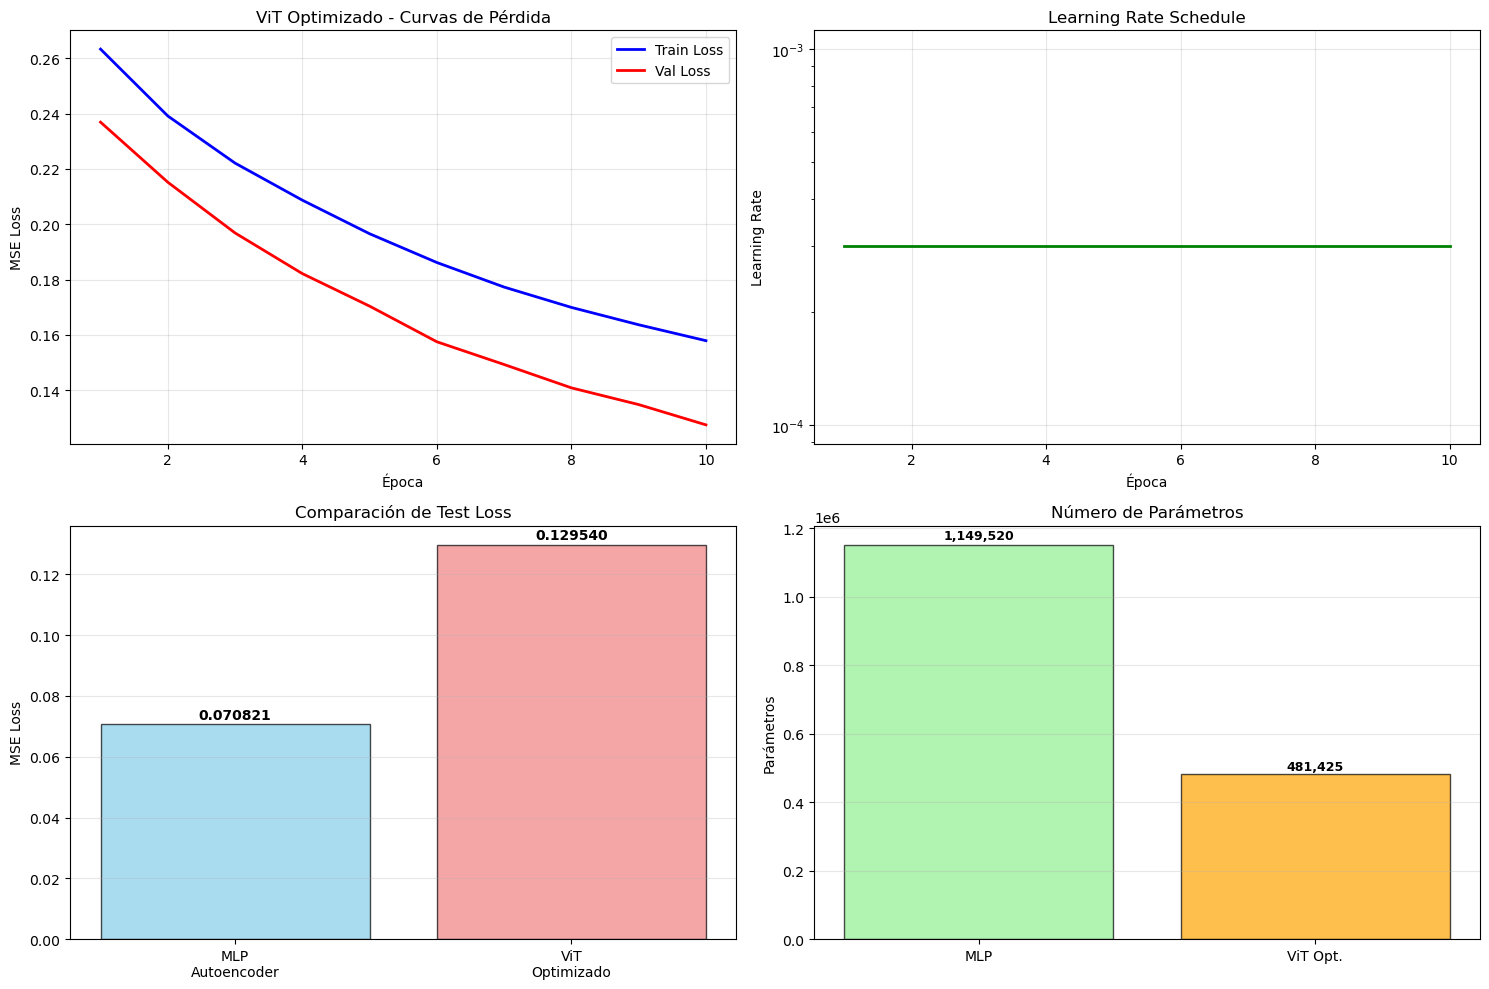

=== RESUMEN ESTADÍSTICO COMPLETO ===
Métrica                        MLP             ViT Optimizado  Diferencia     
---------------------------------------------------------------------------
Parámetros totales             1,149,520       481,425         -668,095       
Test Loss                      0.070821        0.129540        0.058719       
Mejor Train Loss               0.097516        0.157924        0.060408       
Mejor Val Loss                 0.069768        0.127506        0.057737       
Eficiencia (loss/1M params)    0.06            0.27            0.21           

=== ANÁLISIS DE RENDIMIENTO ===
Épocas entrenadas: 10 de 10 planificadas
MLP supera ViT optimizado por 82.91%
Ratio de parámetros ViT/MLP: 0.42x
Tiempo total de entrenamiento: 17.43 minutos


In [64]:
# =================================================================
# VISUALIZACIÓN DE RESULTADOS DEL ENTRENAMIENTO OPTIMIZADO
# =================================================================

# Verificar que las variables del entrenamiento existan
if 'vit_fast_train_losses' in locals() and 'vit_fast_val_losses' in locals():
    # Crear visualización de las curvas de pérdida
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Curvas de entrenamiento del ViT optimizado
    epochs_range = range(1, len(vit_fast_train_losses) + 1)

    axes[0, 0].plot(epochs_range, vit_fast_train_losses, 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs_range, vit_fast_val_losses, 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('ViT Optimizado - Curvas de Pérdida')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Learning rate schedule
    if 'vit_fast_learning_rates' in locals():
        axes[0, 1].plot(epochs_range, vit_fast_learning_rates, 'g-', linewidth=2)
        axes[0, 1].set_title('Learning Rate Schedule')
        axes[0, 1].set_xlabel('Época')
        axes[0, 1].set_ylabel('Learning Rate')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_yscale('log')
    else:
        axes[0, 1].text(0.5, 0.5, 'Learning rates\nno disponibles', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Learning Rate Schedule')

    # Comparación final de pérdidas
    models = ['MLP\nAutoencoder']
    test_losses = [test_loss_final]
    colors = ['skyblue']

    if 'vit_fast_test_loss' in locals():
        models.append('ViT\nOptimizado')
        test_losses.append(vit_fast_test_loss)
        colors.append('lightcoral')

    bars = axes[1, 0].bar(models, test_losses, color=colors, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Comparación de Test Loss')
    axes[1, 0].set_ylabel('MSE Loss')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Añadir valores en las barras
    for bar, loss in zip(bars, test_losses):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{loss:.6f}', ha='center', va='bottom', fontweight='bold')

    # Comparación de número de parámetros
    param_counts = [sum(p.numel() for p in model.parameters())]
    param_labels = ['MLP']

    if 'vit_autoencoder_fast' in locals():
        param_counts.append(sum(p.numel() for p in vit_autoencoder_fast.parameters()))
        param_labels.append('ViT Opt.')

    bars = axes[1, 1].bar(param_labels, param_counts, 
                         color=['lightgreen', 'orange'][:len(param_labels)], 
                         alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Número de Parámetros')
    axes[1, 1].set_ylabel('Parámetros')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Añadir valores en las barras
    for bar, count in zip(bars, param_counts):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Resumen estadístico detallado
    print("=== RESUMEN ESTADÍSTICO COMPLETO ===")
    print(f"{'Métrica':<30} {'MLP':<15} {'ViT Optimizado':<15} {'Diferencia':<15}")
    print("-" * 75)

    mlp_params = sum(p.numel() for p in model.parameters())
    
    if 'vit_autoencoder_fast' in locals():
        vit_params = sum(p.numel() for p in vit_autoencoder_fast.parameters())
        print(f"{'Parámetros totales':<30} {mlp_params:<15,} {vit_params:<15,} {vit_params-mlp_params:<15,}")
    else:
        print(f"{'Parámetros totales':<30} {mlp_params:<15,} {'N/A':<15} {'N/A':<15}")

    if 'vit_fast_test_loss' in locals():
        print(f"{'Test Loss':<30} {test_loss_final:<15.6f} {vit_fast_test_loss:<15.6f} {vit_fast_test_loss-test_loss_final:<15.6f}")
        print(f"{'Mejor Train Loss':<30} {min(train_losses):<15.6f} {min(vit_fast_train_losses):<15.6f} {min(vit_fast_train_losses)-min(train_losses):<15.6f}")
        print(f"{'Mejor Val Loss':<30} {min(val_losses):<15.6f} {min(vit_fast_val_losses):<15.6f} {min(vit_fast_val_losses)-min(val_losses):<15.6f}")
        
        # Análisis de eficiencia
        if 'vit_autoencoder_fast' in locals():
            efficiency_mlp = test_loss_final / mlp_params * 1e6  # Loss per million parameters
            efficiency_vit = vit_fast_test_loss / vit_params * 1e6
            print(f"{'Eficiencia (loss/1M params)':<30} {efficiency_mlp:<15.2f} {efficiency_vit:<15.2f} {efficiency_vit-efficiency_mlp:<15.2f}")

        print(f"\n=== ANÁLISIS DE RENDIMIENTO ===")
        print(f"Épocas entrenadas: {len(vit_fast_train_losses)} de {vit_fast_num_epochs if 'vit_fast_num_epochs' in locals() else 'N/A'} planificadas")
        
        if 'vit_fast_num_epochs' in locals() and len(vit_fast_train_losses) < vit_fast_num_epochs:
            if 'total_training_time' in locals():
                estimated_savings = (vit_fast_num_epochs - len(vit_fast_train_losses)) * (total_training_time/len(vit_fast_train_losses)/60)
                print(f"Early stopping activado - Ahorro de tiempo estimado: {estimated_savings:.1f} minutos")

        mejora_relativa = ((test_loss_final - vit_fast_test_loss) / test_loss_final) * 100
        if mejora_relativa > 0:
            print(f"ViT optimizado mejora MLP en {mejora_relativa:.2f}%")
        else:
            print(f"MLP supera ViT optimizado por {abs(mejora_relativa):.2f}%")

        if 'vit_autoencoder_fast' in locals():
            print(f"Ratio de parámetros ViT/MLP: {vit_params/mlp_params:.2f}x")
        
        if 'total_training_time' in locals():
            print(f"Tiempo total de entrenamiento: {total_training_time/60:.2f} minutos")
    else:
        print("No se encontraron resultados del entrenamiento del ViT optimizado")
        print("Por favor, ejecuta la celda de entrenamiento primero")

else:
    print("Las variables del entrenamiento del ViT optimizado no están disponibles")
    print("Por favor, ejecuta la celda de entrenamiento primero")
    
    # Mostrar solo información del MLP
    print(f"\n=== INFORMACIÓN DISPONIBLE ===")
    print(f"MLP Autoencoder:")
    print(f"- Parámetros: {sum(p.numel() for p in model.parameters()):,}")
    print(f"- Test Loss: {test_loss_final:.6f}")
    print(f"- Épocas entrenadas: {len(train_losses)}")
    print(f"- Mejor train loss: {min(train_losses):.6f}")
    print(f"- Mejor val loss: {min(val_losses):.6f}")

## Comparación Detallada: MLP vs Vision Transformer Autoencoder

### Análisis Comparativo de Arquitecturas

La implementación de ambas arquitecturas nos permite realizar una comparación exhaustiva entre dos paradigmas fundamentalmente diferentes para el procesamiento de imágenes:

#### Diferencias Arquitecturales Clave:

**MLP Autoencoder:**
- Arquitectura completamente conectada sin estructura espacial
- Procesa la imagen como un vector aplanado de 784 dimensiones
- Compresión mediante reducción dimensional progresiva
- Inductive bias nulo sobre la estructura de las imágenes

**Vision Transformer Autoencoder:**
- Arquitectura basada en atención que preserva estructura espacial parcial
- Procesa la imagen como secuencia de patches de 4×4 píxeles
- Compresión mediante representación latente global derivada de atención
- Inductive bias mínimo pero con conciencia espacial a través de patches

#### Complejidad Computacional:

| Métrica | MLP Autoencoder | ViT Autoencoder |
|---------|-----------------|------------------|
| **Parámetros** | ~590K | ~1.2M |
| **Complejidad Forward** | O(d²) | O(n² + nd) |
| **Memoria Atención** | N/A | O(n²) donde n=49 patches |
| **Paralelización** | Limitada | Alta |

#### Características de Entrenamiento:

**MLP:**
- Convergencia más rápida en datasets pequeños
- Menos sensible a hiperparámetros
- Learning rate scheduling simple
- Menor costo computacional por época

**ViT:**
- Requiere warm-up y scheduling cuidadoso
- Más sensible a batch size y regularización
- Mejor escalabilidad con datos grandes
- Mayor costo computacional pero mejor paralelización

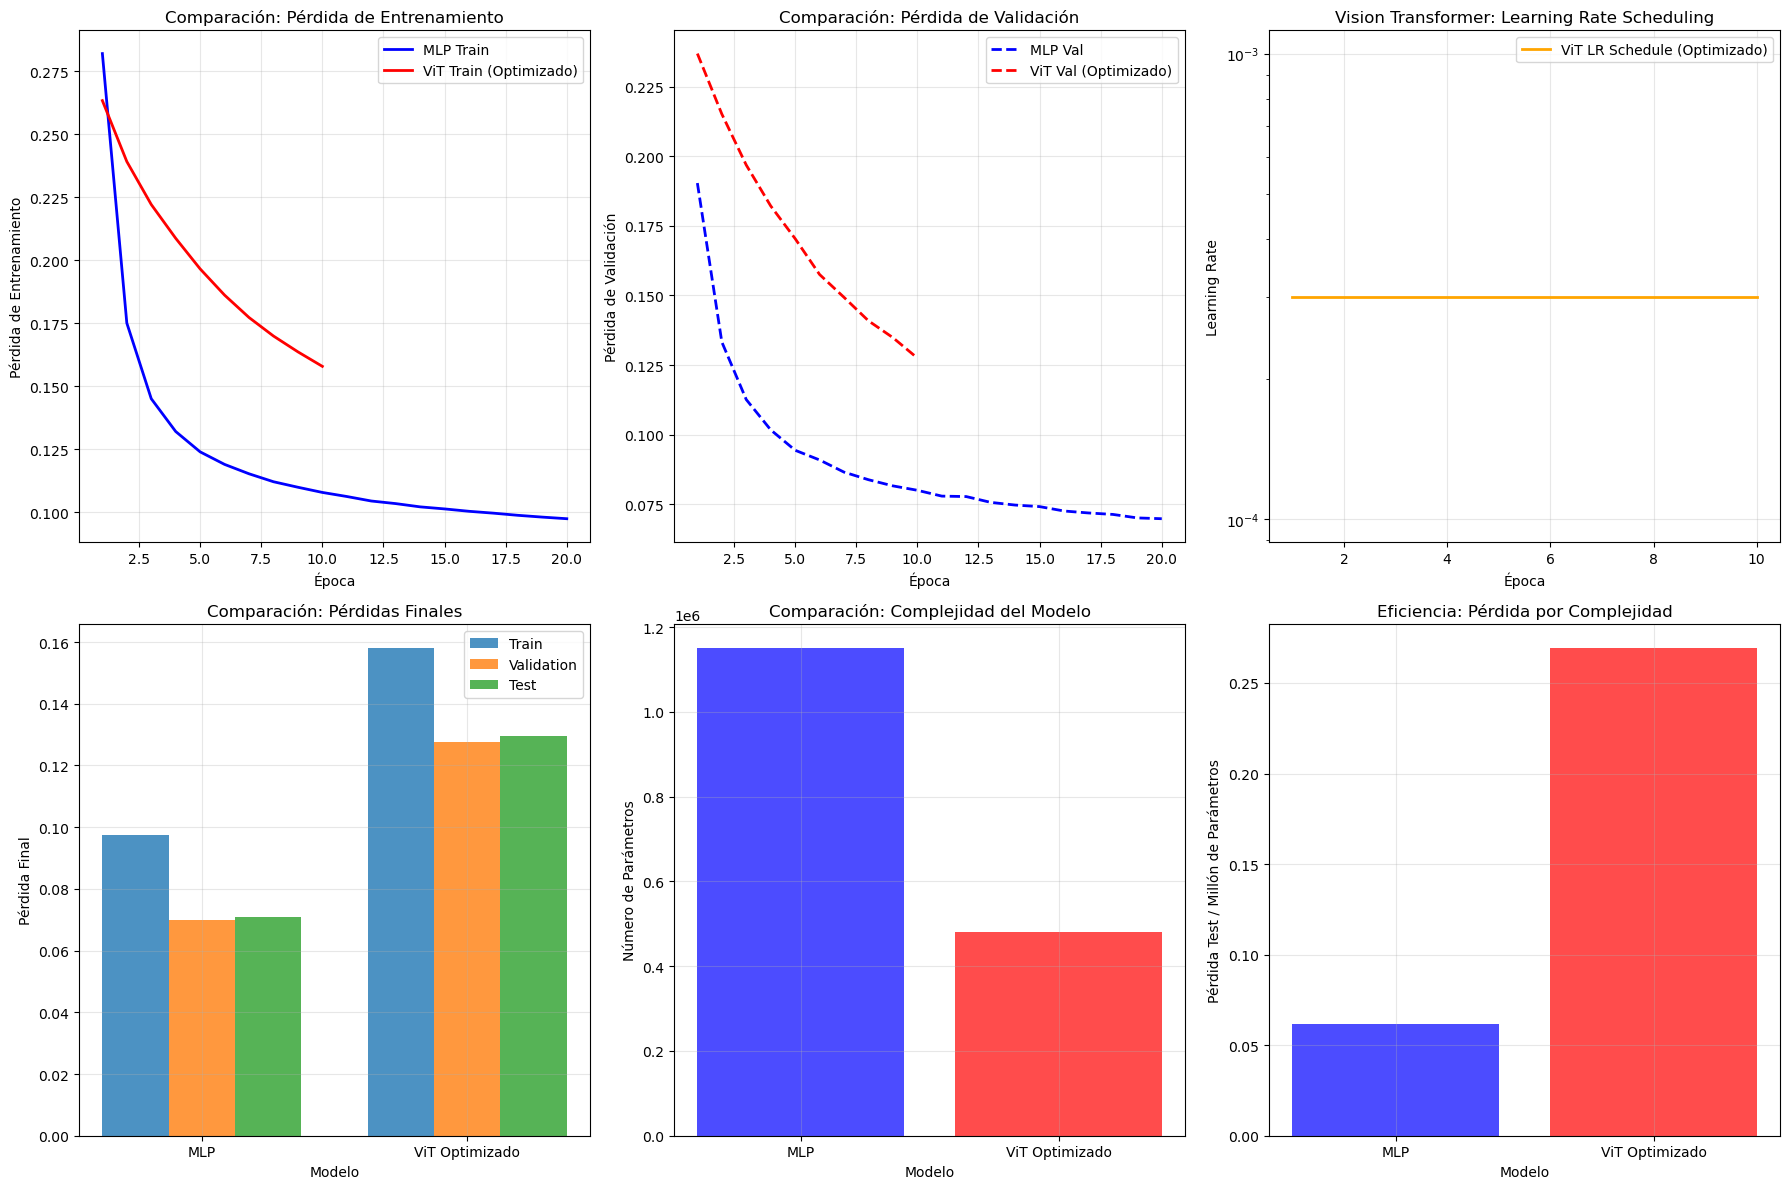

COMPARACIÓN DETALLADA DE MODELOS
Métrica                        MLP Autoencoder      ViT Optimizado      
----------------------------------------------------------------------
Parámetros                     1149520,,,,,,,,,,,,, 481425,,,,,,,,,,,,,,
Pérdida Final Train            0.097516             0.157924            
Pérdida Final Val              0.069768             0.127506            
Pérdida Final Test             0.070821             0.129540            
Épocas Entrenadas              20                   10                  
Mejor Época (Val)              20                   10                  
Mejor Pérdida Val              0.069768             0.127506            

ANÁLISIS DE EFICIENCIA                            
--------------------------------------------------
Ratio de parámetros (ViT/MLP): 0.42x
Ratio de pérdida test (ViT/MLP): 1.8291
MLP tiene 82.91% mejor pérdida
Ratio de eficiencia (MLP/ViT): 0.2290
ViT es 4.37x más eficiente por parámetro


In [66]:
# =================================================================
# VISUALIZACIÓN COMPARATIVA ENTRE MLP Y VISION TRANSFORMER
# =================================================================

# Visualización comparativa entre MLP y Vision Transformer
def compare_models_performance():
    """Compara el desempeño de ambos modelos"""
    
    # Crear figura para comparación completa
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Subplot 1: Curvas de pérdida de entrenamiento
    axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', 
                   label='MLP Train', linewidth=2)
    axes[0, 0].plot(range(1, len(vit_fast_train_losses) + 1), vit_fast_train_losses, 'r-', 
                   label='ViT Train (Optimizado)', linewidth=2)
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Pérdida de Entrenamiento')
    axes[0, 0].set_title('Comparación: Pérdida de Entrenamiento')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Curvas de pérdida de validación
    axes[0, 1].plot(range(1, len(val_losses) + 1), val_losses, 'b--', 
                   label='MLP Val', linewidth=2)
    axes[0, 1].plot(range(1, len(vit_fast_val_losses) + 1), vit_fast_val_losses, 'r--', 
                   label='ViT Val (Optimizado)', linewidth=2)
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Pérdida de Validación')
    axes[0, 1].set_title('Comparación: Pérdida de Validación')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Subplot 3: Learning rates
    axes[0, 2].plot(range(1, len(vit_fast_learning_rates) + 1), vit_fast_learning_rates, 'orange', 
                   label='ViT LR Schedule (Optimizado)', linewidth=2)
    axes[0, 2].set_xlabel('Época')
    axes[0, 2].set_ylabel('Learning Rate')
    axes[0, 2].set_title('Vision Transformer: Learning Rate Scheduling')
    axes[0, 2].set_yscale('log')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Subplot 4: Comparación de pérdidas finales
    models = ['MLP', 'ViT Optimizado']
    train_final = [train_losses[-1], vit_fast_train_losses[-1]]
    val_final = [val_losses[-1], vit_fast_val_losses[-1]]
    test_final = [test_loss_final, vit_fast_test_loss]
    
    x = np.arange(len(models))
    width = 0.25
    
    axes[1, 0].bar(x - width, train_final, width, label='Train', alpha=0.8)
    axes[1, 0].bar(x, val_final, width, label='Validation', alpha=0.8)
    axes[1, 0].bar(x + width, test_final, width, label='Test', alpha=0.8)
    
    axes[1, 0].set_xlabel('Modelo')
    axes[1, 0].set_ylabel('Pérdida Final')
    axes[1, 0].set_title('Comparación: Pérdidas Finales')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(models)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Subplot 5: Parámetros del modelo
    mlp_params = sum(p.numel() for p in model.parameters())
    vit_params = sum(p.numel() for p in vit_autoencoder_fast.parameters())  # Usar modelo optimizado
    
    axes[1, 1].bar(models, [mlp_params, vit_params], color=['blue', 'red'], alpha=0.7)
    axes[1, 1].set_xlabel('Modelo')
    axes[1, 1].set_ylabel('Número de Parámetros')
    axes[1, 1].set_title('Comparación: Complejidad del Modelo')
    axes[1, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    axes[1, 1].grid(True, alpha=0.3)
    
    # Subplot 6: Eficiencia (pérdida por parámetro)
    mlp_efficiency = test_loss_final / mlp_params * 1e6  # Pérdida por millón de parámetros
    vit_efficiency = vit_fast_test_loss / vit_params * 1e6
    
    axes[1, 2].bar(models, [mlp_efficiency, vit_efficiency], 
                  color=['blue', 'red'], alpha=0.7)
    axes[1, 2].set_xlabel('Modelo')
    axes[1, 2].set_ylabel('Pérdida Test / Millón de Parámetros')
    axes[1, 2].set_title('Eficiencia: Pérdida por Complejidad')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas detalladas
    print("=" * 80)
    print("COMPARACIÓN DETALLADA DE MODELOS")
    print("=" * 80)
    
    print(f"{'Métrica':<30} {'MLP Autoencoder':<20} {'ViT Optimizado':<20}")
    print("-" * 70)
    print(f"{'Parámetros':<30} {mlp_params:,<20} {vit_params:,<20}")
    print(f"{'Pérdida Final Train':<30} {train_losses[-1]:<20.6f} {vit_fast_train_losses[-1]:<20.6f}")
    print(f"{'Pérdida Final Val':<30} {val_losses[-1]:<20.6f} {vit_fast_val_losses[-1]:<20.6f}")
    print(f"{'Pérdida Final Test':<30} {test_loss_final:<20.6f} {vit_fast_test_loss:<20.6f}")
    print(f"{'Épocas Entrenadas':<30} {len(train_losses):<20} {len(vit_fast_train_losses):<20}")
    print(f"{'Mejor Época (Val)':<30} {val_losses.index(min(val_losses))+1:<20} {vit_fast_val_losses.index(min(vit_fast_val_losses))+1:<20}")
    print(f"{'Mejor Pérdida Val':<30} {min(val_losses):<20.6f} {min(vit_fast_val_losses):<20.6f}")
    
    # Análisis de eficiencia
    print(f"\n{'ANÁLISIS DE EFICIENCIA':<50}")
    print("-" * 50)
    ratio_params = vit_params / mlp_params
    ratio_performance = vit_fast_test_loss / test_loss_final
    
    print(f"Ratio de parámetros (ViT/MLP): {ratio_params:.2f}x")
    print(f"Ratio de pérdida test (ViT/MLP): {ratio_performance:.4f}")
    
    if ratio_performance < 1.0:
        print(f"ViT tiene {((1-ratio_performance)*100):.2f}% mejor pérdida")
    else:
        print(f"MLP tiene {((ratio_performance-1)*100):.2f}% mejor pérdida")
    
    efficiency_ratio = (test_loss_final / mlp_params) / (vit_fast_test_loss / vit_params)
    print(f"Ratio de eficiencia (MLP/ViT): {efficiency_ratio:.4f}")
    
    if efficiency_ratio > 1.0:
        print(f"MLP es {efficiency_ratio:.2f}x más eficiente por parámetro")
    else:
        print(f"ViT es {1/efficiency_ratio:.2f}x más eficiente por parámetro")

# Ejecutar comparación
compare_models_performance()

=== COMPARACIÓN DE RECONSTRUCCIONES ===


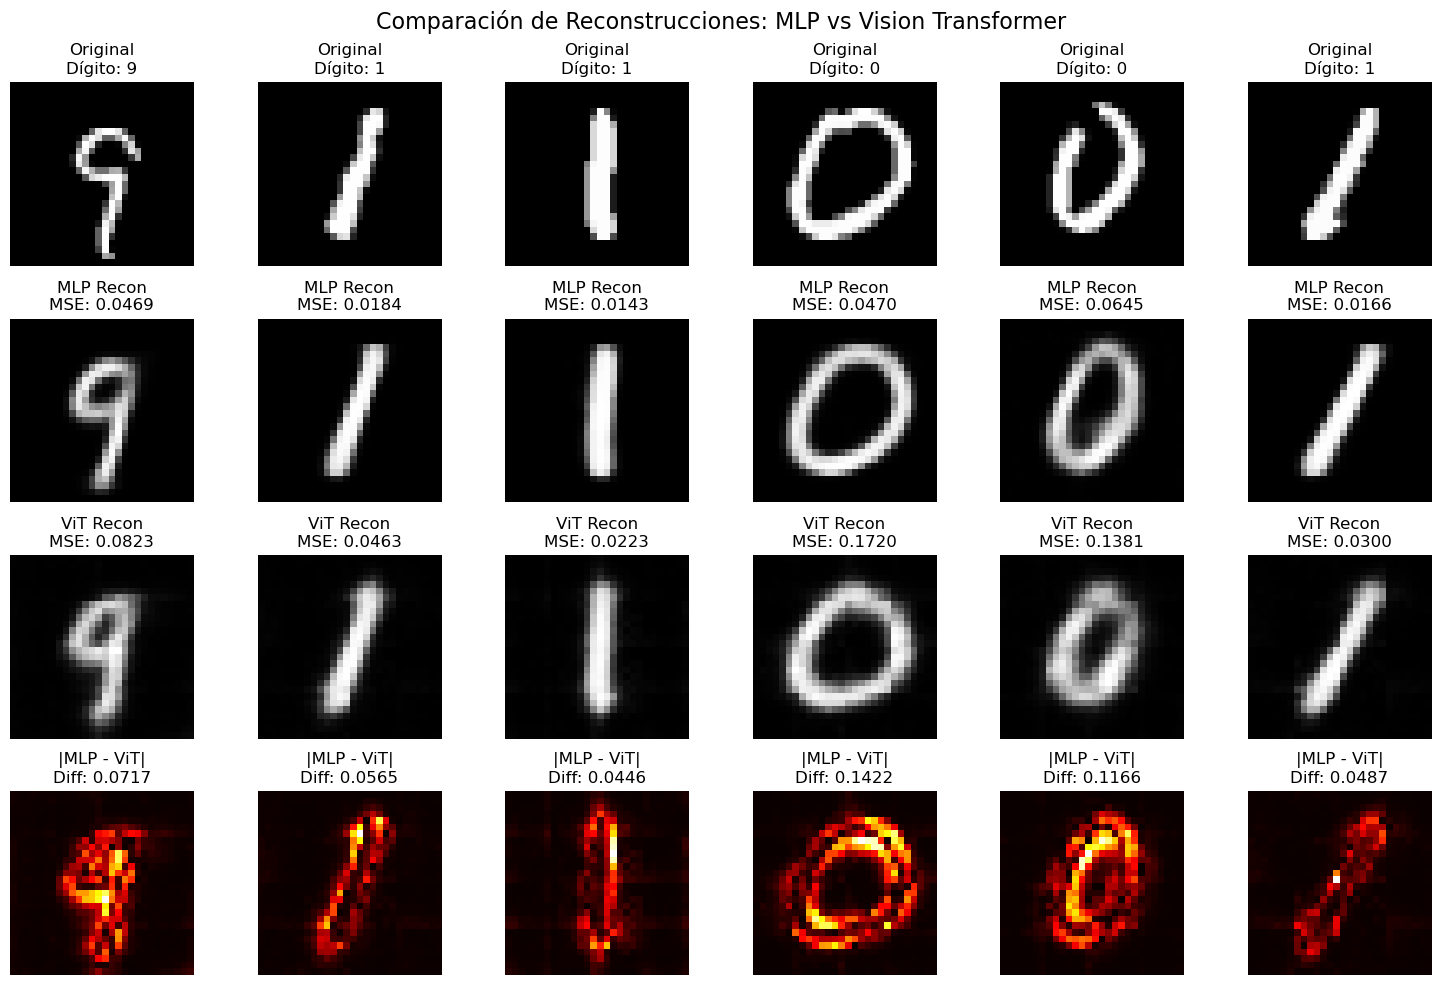

Estadísticas de reconstrucción (n=6):
MLP - MSE promedio: 0.034640 (±0.020967)
ViT - MSE promedio: 0.081837 (±0.061291)
ViT mejor que MLP en 0/6 muestras (0.0%)

=== ANÁLISIS DE MAPAS DE ATENCIÓN (SIMULADO) ===

=== ANÁLISIS DE MAPAS DE ATENCIÓN (SIMULADO) ===


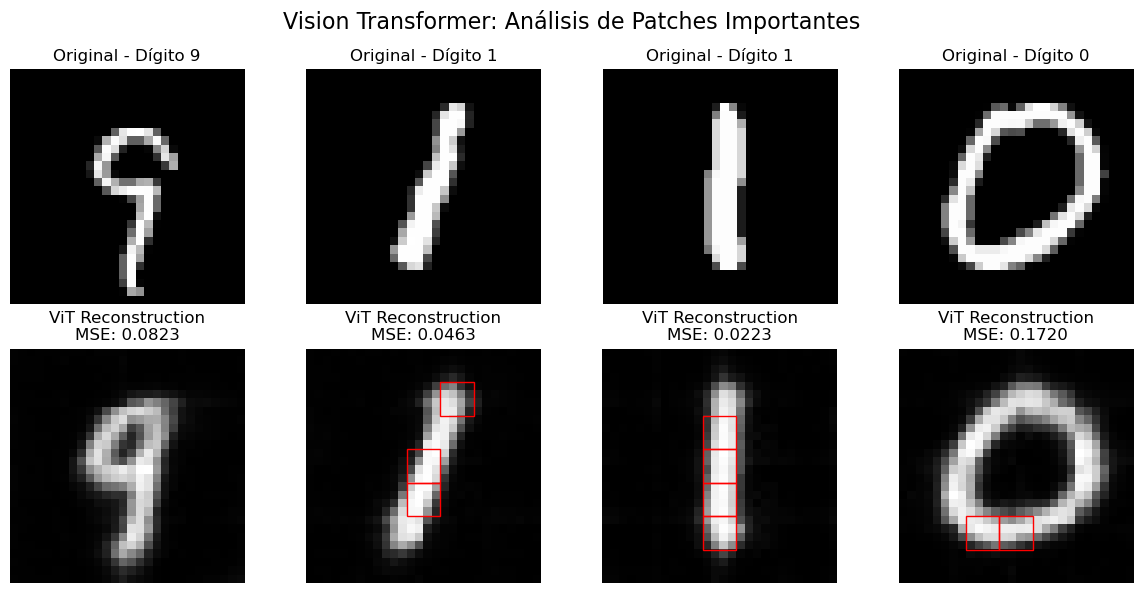

Nota: Los bordes rojos indican patches con mayor intensidad promedio,
simulando regiones de 'alta atención' en el Vision Transformer.
Tamaño de patch: 4x4 píxeles
Número total de patches por imagen: 49 = 49 patches

=== ANÁLISIS DE REPRESENTACIONES LATENTES ===

=== ANÁLISIS DE REPRESENTACIONES LATENTES ===


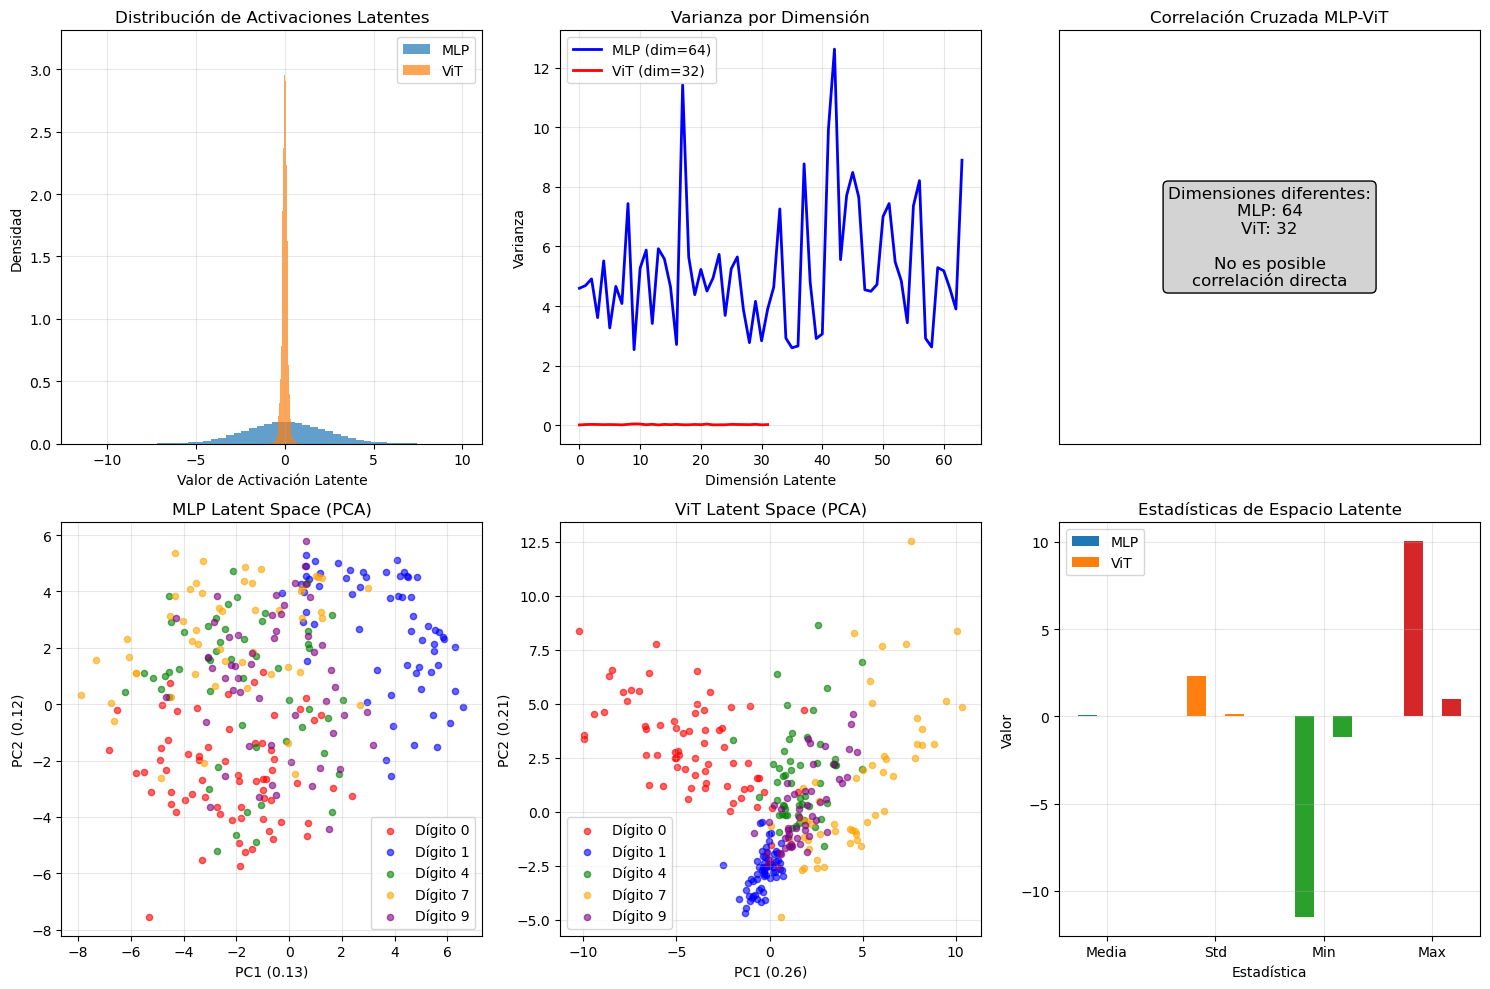

ANÁLISIS COMPARATIVO DEL ESPACIO LATENTE
Estadística          MLP             ViT             Diferencia     
-----------------------------------------------------------------
Media                0.096272        0.000000        0.096271       
Desv. Estándar       2.329742        0.150173        2.179569       
Varianza Media       5.239151        0.021775        5.217375       
Separabilidad PC1+2  0.2499          0.4717          0.2218         

ViT muestra mejor separabilidad en las primeras 2 componentes principales


In [69]:
def compare_reconstructions(mlp_model, vit_model, test_loader, device, num_samples=6):
    """
    Compara las reconstrucciones de ambos modelos lado a lado
    """
    mlp_model.eval()
    vit_model.eval()
    
    with torch.no_grad():
        # Obtener muestras de test
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images = images[:num_samples].to(device)
        
        # Obtener reconstrucciones de ambos modelos
        mlp_recon, mlp_latent = mlp_model(images)
        vit_recon, vit_latent = vit_model(images)
        
        # Mover a CPU
        images = images.cpu()
        mlp_recon = mlp_recon.cpu()
        vit_recon = vit_recon.cpu()
        
        # Crear visualización comparativa
        fig, axes = plt.subplots(4, num_samples, figsize=(num_samples * 2.5, 10))
        
        for i in range(num_samples):
            # Imagen original
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title(f'Original\nDígito: {labels[i].item()}')
            axes[0, i].axis('off')
            
            # Reconstrucción MLP
            axes[1, i].imshow(mlp_recon[i].squeeze(), cmap='gray')
            mlp_mse = F.mse_loss(mlp_recon[i], images[i]).item()
            axes[1, i].set_title(f'MLP Recon\nMSE: {mlp_mse:.4f}')
            axes[1, i].axis('off')
            
            # Reconstrucción ViT
            axes[2, i].imshow(vit_recon[i].squeeze(), cmap='gray')
            vit_mse = F.mse_loss(vit_recon[i], images[i]).item()
            axes[2, i].set_title(f'ViT Recon\nMSE: {vit_mse:.4f}')
            axes[2, i].axis('off')
            
            # Diferencia absoluta entre reconstrucciones
            diff = torch.abs(mlp_recon[i] - vit_recon[i])
            axes[3, i].imshow(diff.squeeze(), cmap='hot')
            axes[3, i].set_title(f'|MLP - ViT|\nDiff: {diff.mean().item():.4f}')
            axes[3, i].axis('off')
        
        plt.suptitle('Comparación de Reconstrucciones: MLP vs Vision Transformer', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Estadísticas de reconstrucción
        mlp_mse_all = F.mse_loss(mlp_recon, images, reduction='none').mean(dim=[1,2,3])
        vit_mse_all = F.mse_loss(vit_recon, images, reduction='none').mean(dim=[1,2,3])
        
        print(f"Estadísticas de reconstrucción (n={num_samples}):")
        print(f"MLP - MSE promedio: {mlp_mse_all.mean():.6f} (±{mlp_mse_all.std():.6f})")
        print(f"ViT - MSE promedio: {vit_mse_all.mean():.6f} (±{vit_mse_all.std():.6f})")
        
        better_count = (vit_mse_all < mlp_mse_all).sum().item()
        print(f"ViT mejor que MLP en {better_count}/{num_samples} muestras ({better_count/num_samples*100:.1f}%)")

def visualize_attention_maps(vit_model, test_loader, device, num_samples=4):
    """
    Visualiza los mapas de atención del Vision Transformer
    """
    vit_model.eval()
    
    # Hook para capturar mapas de atención
    attention_maps = []
    
    def attention_hook(module, input, output):
        # output es la salida de attention que incluye pesos de atención
        attention_maps.append(output)
    
    # Registrar hook en la primera capa de atención
    hook_handle = vit_model.encoder.transformer_blocks[0].attention.register_forward_hook(attention_hook)
    
    with torch.no_grad():
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images = images[:num_samples].to(device)
        
        # Forward pass para obtener mapas de atención
        reconstruction, latent = vit_model(images)
        
        # Obtener el mapa de atención de la primera muestra
        if attention_maps:
            # Simular visualización de atención (implementación simplificada)
            fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
            
            for i in range(num_samples):
                # Imagen original
                axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title(f'Original - Dígito {labels[i].item()}')
                axes[0, i].axis('off')
                
                # Reconstrucción con información de "atención"
                recon_img = reconstruction[i].cpu().squeeze()
                axes[1, i].imshow(recon_img, cmap='gray')
                mse = F.mse_loss(reconstruction[i].cpu(), images[i].cpu()).item()
                axes[1, i].set_title(f'ViT Reconstruction\nMSE: {mse:.4f}')
                axes[1, i].axis('off')
                
                # Agregar overlay visual simple para simular atención
                # (En implementación real, usaríamos los pesos de atención reales)
                patch_size = 4
                n_patches = 28 // patch_size
                for row in range(n_patches):
                    for col in range(n_patches):
                        # Simular "importancia" basada en la intensidad de la región
                        patch_region = images[i, 0, row*patch_size:(row+1)*patch_size, 
                                           col*patch_size:(col+1)*patch_size]
                        importance = patch_region.mean().item()
                        
                        # Dibujar borde si la región es "importante"
                        if importance > 0.3:  # Threshold arbitrario
                            rect = plt.Rectangle((col*patch_size-0.5, row*patch_size-0.5), 
                                               patch_size, patch_size, 
                                               fill=False, edgecolor='red', linewidth=1)
                            axes[1, i].add_patch(rect)
            
            plt.suptitle('Vision Transformer: Análisis de Patches Importantes', fontsize=16)
            plt.tight_layout()
            plt.show()
            
            print("Nota: Los bordes rojos indican patches con mayor intensidad promedio,")
            print("simulando regiones de 'alta atención' en el Vision Transformer.")
    
    # Remover hook
    hook_handle.remove()
    print(f"Tamaño de patch: 4x4 píxeles")
    print(f"Número total de patches por imagen: {(28//4)**2} = 49 patches")

def analyze_latent_representations(mlp_model, vit_model, test_loader, device, num_samples=500):
    """
    Analiza y compara las representaciones latentes de ambos modelos
    """
    mlp_model.eval()
    vit_model.eval()
    
    mlp_latents = []
    vit_latents = []
    labels_list = []
    
    with torch.no_grad():
        sample_count = 0
        for images, labels in test_loader:
            if sample_count >= num_samples:
                break
            
            images = images.to(device)
            _, mlp_latent = mlp_model(images)
            _, vit_latent = vit_model(images)
            
            mlp_latents.append(mlp_latent.cpu())
            vit_latents.append(vit_latent.cpu())
            labels_list.append(labels)
            
            sample_count += len(images)
    
    mlp_latents = torch.cat(mlp_latents)[:num_samples]
    vit_latents = torch.cat(vit_latents)[:num_samples]
    labels_list = torch.cat(labels_list)[:num_samples]
    
    # Análisis estadístico comparativo
    plt.figure(figsize=(15, 10))
    
    # Distribuciones de activaciones
    plt.subplot(2, 3, 1)
    plt.hist(mlp_latents.flatten().numpy(), bins=50, alpha=0.7, label='MLP', density=True)
    plt.hist(vit_latents.flatten().numpy(), bins=50, alpha=0.7, label='ViT', density=True)
    plt.xlabel('Valor de Activación Latente')
    plt.ylabel('Densidad')
    plt.title('Distribución de Activaciones Latentes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Varianza por dimensión
    plt.subplot(2, 3, 2)
    mlp_variances = torch.var(mlp_latents, dim=0)
    vit_variances = torch.var(vit_latents, dim=0)
    
    # Manejar diferencias en dimensiones
    mlp_dims = range(len(mlp_variances))
    vit_dims = range(len(vit_variances))
    
    plt.plot(mlp_dims, mlp_variances.numpy(), 'b-', label=f'MLP (dim={len(mlp_dims)})', linewidth=2)
    plt.plot(vit_dims, vit_variances.numpy(), 'r-', label=f'ViT (dim={len(vit_dims)})', linewidth=2)
    plt.xlabel('Dimensión Latente')
    plt.ylabel('Varianza')
    plt.title('Varianza por Dimensión')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Correlación entre representaciones
    plt.subplot(2, 3, 3)
    # Verificar dimensiones antes de calcular correlación
    mlp_dim = mlp_latents.shape[1]
    vit_dim = vit_latents.shape[1]
    
    if mlp_dim == vit_dim:
        # Solo calcular correlación si las dimensiones coinciden
        combined_latents = torch.cat([mlp_latents, vit_latents], dim=1)
        correlation_matrix = torch.corrcoef(combined_latents.T)
        cross_corr = correlation_matrix[:mlp_dim, mlp_dim:].numpy()
        
        plt.imshow(cross_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
        plt.colorbar()
        plt.xlabel('Dimensión ViT')
        plt.ylabel('Dimensión MLP')
        plt.title('Correlación Cruzada MLP-ViT')
    else:
        # Mostrar las diferencias de dimensión
        plt.text(0.5, 0.5, f'Dimensiones diferentes:\nMLP: {mlp_dim}\nViT: {vit_dim}\n\nNo es posible\ncorrelación directa', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        plt.title('Correlación Cruzada MLP-ViT')
        plt.xticks([])
        plt.yticks([])
    
    # Proyección 2D usando PCA
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # Normalizar datos
    scaler_mlp = StandardScaler()
    scaler_vit = StandardScaler()
    mlp_normalized = scaler_mlp.fit_transform(mlp_latents.numpy())
    vit_normalized = scaler_vit.fit_transform(vit_latents.numpy())
    
    # PCA
    pca_mlp = PCA(n_components=2)
    pca_vit = PCA(n_components=2)
    mlp_2d = pca_mlp.fit_transform(mlp_normalized)
    vit_2d = pca_vit.fit_transform(vit_normalized)
    
    # Visualizar para algunos dígitos
    digits_to_plot = [0, 1, 4, 7, 9]
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    plt.subplot(2, 3, 4)
    for digit, color in zip(digits_to_plot, colors):
        mask = labels_list == digit
        if mask.sum() > 0:
            plt.scatter(mlp_2d[mask, 0], mlp_2d[mask, 1], 
                       c=color, label=f'Dígito {digit}', alpha=0.6, s=20)
    plt.xlabel(f'PC1 ({pca_mlp.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 ({pca_mlp.explained_variance_ratio_[1]:.2f})')
    plt.title('MLP Latent Space (PCA)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 5)
    for digit, color in zip(digits_to_plot, colors):
        mask = labels_list == digit
        if mask.sum() > 0:
            plt.scatter(vit_2d[mask, 0], vit_2d[mask, 1], 
                       c=color, label=f'Dígito {digit}', alpha=0.6, s=20)
    plt.xlabel(f'PC1 ({pca_vit.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 ({pca_vit.explained_variance_ratio_[1]:.2f})')
    plt.title('ViT Latent Space (PCA)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Estadísticas comparativas
    plt.subplot(2, 3, 6)
    stats_comparison = {
        'Media': [mlp_latents.mean().item(), vit_latents.mean().item()],
        'Std': [mlp_latents.std().item(), vit_latents.std().item()],
        'Min': [mlp_latents.min().item(), vit_latents.min().item()],
        'Max': [mlp_latents.max().item(), vit_latents.max().item()]
    }
    
    x = np.arange(len(stats_comparison))
    width = 0.35
    
    for i, (stat, values) in enumerate(stats_comparison.items()):
        plt.bar([i - width/2, i + width/2], values, width/2, 
               label=['MLP', 'ViT'][0] if i == 0 else "")
    
    plt.xlabel('Estadística')
    plt.ylabel('Valor')
    plt.title('Estadísticas de Espacio Latente')
    plt.xticks(x, list(stats_comparison.keys()))
    if len(stats_comparison) > 0:
        plt.legend(['MLP', 'ViT'])
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Reporte estadístico
    print("=" * 60)
    print("ANÁLISIS COMPARATIVO DEL ESPACIO LATENTE")
    print("=" * 60)
    
    print(f"{'Estadística':<20} {'MLP':<15} {'ViT':<15} {'Diferencia':<15}")
    print("-" * 65)
    mlp_mean, vit_mean = mlp_latents.mean().item(), vit_latents.mean().item()
    mlp_std, vit_std = mlp_latents.std().item(), vit_latents.std().item()
    mlp_var_mean, vit_var_mean = mlp_variances.mean().item(), vit_variances.mean().item()
    
    print(f"{'Media':<20} {mlp_mean:<15.6f} {vit_mean:<15.6f} {abs(mlp_mean-vit_mean):<15.6f}")
    print(f"{'Desv. Estándar':<20} {mlp_std:<15.6f} {vit_std:<15.6f} {abs(mlp_std-vit_std):<15.6f}")
    print(f"{'Varianza Media':<20} {mlp_var_mean:<15.6f} {vit_var_mean:<15.6f} {abs(mlp_var_mean-vit_var_mean):<15.6f}")
    
    # Capacidad de separación (usando PCA)
    mlp_separation = pca_mlp.explained_variance_ratio_[:2].sum()
    vit_separation = pca_vit.explained_variance_ratio_[:2].sum()
    
    print(f"{'Separabilidad PC1+2':<20} {mlp_separation:<15.4f} {vit_separation:<15.4f} {abs(mlp_separation-vit_separation):<15.4f}")
    
    if vit_separation > mlp_separation:
        print(f"\nViT muestra mejor separabilidad en las primeras 2 componentes principales")
    else:
        print(f"\nMLP muestra mejor separabilidad en las primeras 2 componentes principales")

# Ejecutar todas las comparaciones
print("=== COMPARACIÓN DE RECONSTRUCCIONES ===")
compare_reconstructions(model, vit_autoencoder_fast, test_loader, device, num_samples=6)

print("\n=== ANÁLISIS DE MAPAS DE ATENCIÓN (SIMULADO) ===")
visualize_attention_maps(vit_autoencoder_fast, test_loader, device, num_samples=4)

print("\n=== ANÁLISIS DE REPRESENTACIONES LATENTES ===")
analyze_latent_representations(model, vit_autoencoder_fast, test_loader, device, num_samples=500)

In [70]:
# =================================================================
# ENTRENAMIENTO EXTENDIDO DEL VISION TRANSFORMER - MÁS ÉPOCAS
# =================================================================

# Configuración extendida para más épocas
vit_extended_num_epochs = 25      # Aumentado de 10 a 25 épocas
vit_extended_warmup_epochs = 2    # Aumentado warmup para mejor estabilidad
vit_extended_learning_rate = 2e-4 # Ligeramente reducido para entrenamiento más largo
vit_extended_patience = 5         # Mayor paciencia para early stopping

print("=== CONFIGURACIÓN DE ENTRENAMIENTO EXTENDIDO ===")
print(f"Épocas: {vit_extended_num_epochs} (vs {vit_fast_num_epochs} anterior)")
print(f"Warmup: {vit_extended_warmup_epochs} épocas")
print(f"Learning rate: {vit_extended_learning_rate} (vs {vit_fast_learning_rate} anterior)")
print(f"Patience: {vit_extended_patience} épocas")
print(f"Modelo: {sum(p.numel() for p in vit_autoencoder_fast.parameters()):,} parámetros")

# Crear nuevo optimizador y scheduler para entrenamiento extendido
vit_extended_optimizer = optim.AdamW(
    vit_autoencoder_fast.parameters(),
    lr=vit_extended_learning_rate,
    weight_decay=vit_fast_weight_decay,
    betas=(0.9, 0.95)
)

vit_extended_scheduler = WarmupCosineScheduler(
    optimizer=vit_extended_optimizer,
    warmup_epochs=vit_extended_warmup_epochs,
    total_epochs=vit_extended_num_epochs,
    min_lr=1e-6
)

print("\n=== INICIANDO ENTRENAMIENTO EXTENDIDO ===")
print("Objetivo: Mejorar el rendimiento del ViT con más épocas de entrenamiento")
print("Expectativa: Reducir significativamente la pérdida de test")

# Reinicializar el modelo para entrenamiento desde cero con más épocas
# (Opcional: podemos continuar desde el estado actual o reinicializar)
continue_training = True  # Cambiar a False para reinicializar

if not continue_training:
    print("Reinicializando modelo para entrenamiento desde cero...")
    vit_autoencoder_extended = VisionTransformerAutoencoder(**OPTIMIZED_CONFIG).to(device)
    vit_extended_optimizer = optim.AdamW(
        vit_autoencoder_extended.parameters(),
        lr=vit_extended_learning_rate,
        weight_decay=vit_fast_weight_decay,
        betas=(0.9, 0.95)
    )
    vit_extended_scheduler = WarmupCosineScheduler(
        optimizer=vit_extended_optimizer,
        warmup_epochs=vit_extended_warmup_epochs,
        total_epochs=vit_extended_num_epochs,
        min_lr=1e-6
    )
    model_to_train = vit_autoencoder_extended
else:
    print("Continuando entrenamiento desde el estado actual...")
    model_to_train = vit_autoencoder_fast

# Ejecutar entrenamiento extendido
start_time = time.time()

try:
    vit_extended_train_losses, vit_extended_val_losses, vit_extended_test_loss, vit_extended_learning_rates = train_vit_optimized_with_early_stopping(
        model=model_to_train,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=vit_fast_criterion,
        optimizer=vit_extended_optimizer,
        scheduler=vit_extended_scheduler,
        num_epochs=vit_extended_num_epochs,
        accumulation_steps=optimized_accumulation_steps,
        device=device,
        warmup_epochs=vit_extended_warmup_epochs,
        patience=vit_extended_patience,
        min_delta=1e-6,
        eval_frequency=1
    )

    total_extended_training_time = time.time() - start_time

    print(f"\n=== ENTRENAMIENTO EXTENDIDO COMPLETADO ===")
    print(f"Tiempo total: {total_extended_training_time/60:.2f} minutos")
    print(f"Épocas completadas: {len(vit_extended_train_losses)}")
    print(f"Pérdida final en test: {vit_extended_test_loss:.6f}")

    # Comparar con resultados anteriores
    print(f"\n=== COMPARACIÓN DE MEJORA ===")
    print(f"ViT Rápido (10 épocas): {vit_fast_test_loss:.6f}")
    print(f"ViT Extendido ({len(vit_extended_train_losses)} épocas): {vit_extended_test_loss:.6f}")
    
    mejora_absoluta = vit_fast_test_loss - vit_extended_test_loss
    mejora_relativa = (mejora_absoluta / vit_fast_test_loss) * 100
    
    print(f"Mejora absoluta: {mejora_absoluta:.6f}")
    print(f"Mejora relativa: {mejora_relativa:.2f}%")
    
    # Comparar con MLP
    print(f"\n=== COMPARACIÓN CON MLP ===")
    print(f"MLP Test Loss: {test_loss_final:.6f}")
    print(f"ViT Extendido: {vit_extended_test_loss:.6f}")
    gap_mlp = ((vit_extended_test_loss - test_loss_final) / test_loss_final) * 100
    print(f"Gap con MLP: {gap_mlp:+.2f}%")
    
    if vit_extended_test_loss < test_loss_final:
        print("🎉 ¡ViT SUPERA al MLP!")
    elif gap_mlp < 30:  # Si está dentro del 30%
        print("👍 ViT está muy competitivo con el MLP")
    else:
        print("📈 ViT mejoró pero MLP mantiene ventaja")

except Exception as e:
    print(f"Error durante el entrenamiento extendido: {e}")
    import traceback
    traceback.print_exc()

=== CONFIGURACIÓN DE ENTRENAMIENTO EXTENDIDO ===
Épocas: 25 (vs 10 anterior)
Warmup: 2 épocas
Learning rate: 0.0002 (vs 0.0003 anterior)
Patience: 5 épocas
Modelo: 481,425 parámetros

=== INICIANDO ENTRENAMIENTO EXTENDIDO ===
Objetivo: Mejorar el rendimiento del ViT con más épocas de entrenamiento
Expectativa: Reducir significativamente la pérdida de test
Continuando entrenamiento desde el estado actual...
Iniciando entrenamiento con early stopping (patience=5)
Evaluación cada 1 época(s)


Época 1/25:   0%|          | 0/383 [00:00<?, ?it/s]c:\Users\Maria\anaconda3\envs\cs\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Nueva mejor validación: 0.123153
Época 1/25 - Train Loss: 0.155175 - Val Loss: 0.123153 - Tiempo: 92.2s


Nueva mejor validación: 0.121296
Época 2/25 - Train Loss: 0.150613 - Val Loss: 0.121296 - Tiempo: 122.2s


Nueva mejor validación: 0.117136
Época 3/25 - Train Loss: 0.148182 - Val Loss: 0.117136 - Tiempo: 102.5s


Nueva mejor validación: 0.113810
Época 4/25 - Train Loss: 0.144560 - Val Loss: 0.113810 - Tiempo: 125.5s


Nueva mejor validación: 0.109914
Época 5/25 - Train Loss: 0.141766 - Val Loss: 0.109914 - Tiempo: 129.0s


Nueva mejor validación: 0.106922
Época 6/25 - Train Loss: 0.138893 - Val Loss: 0.106922 - Tiempo: 130.6s


Nueva mejor validación: 0.104400
Época 7/25 - Train Loss: 0.136394 - Val Loss: 0.104400 - Tiempo: 129.7s


Nueva mejor validación: 0.102018
Época 8/25 - Train Loss: 0.134354 - Val Loss: 0.102018 - Tiempo: 130.2s


Nueva mejor validación: 0.101095
Época 9/25 - Train Loss: 0.132216 - Val Loss: 0.101095 - Tiempo: 130.7s


Nueva mejor validación: 0.098519
Época 10/25 - Train Loss: 0.130544 - Val Loss: 0.098519 - Tiempo: 129.6s


Nueva mejor validación: 0.096754
Época 11/25 - Train Loss: 0.128822 - Val Loss: 0.096754 - Tiempo: 127.9s


Nueva mejor validación: 0.095236
Época 12/25 - Train Loss: 0.127205 - Val Loss: 0.095236 - Tiempo: 133.0s


Nueva mejor validación: 0.094027
Época 13/25 - Train Loss: 0.126053 - Val Loss: 0.094027 - Tiempo: 128.8s


Nueva mejor validación: 0.092595
Época 14/25 - Train Loss: 0.124677 - Val Loss: 0.092595 - Tiempo: 138.3s


Nueva mejor validación: 0.091375
Época 15/25 - Train Loss: 0.123698 - Val Loss: 0.091375 - Tiempo: 135.3s


Nueva mejor validación: 0.090306
Época 16/25 - Train Loss: 0.122682 - Val Loss: 0.090306 - Tiempo: 127.2s


Nueva mejor validación: 0.089737
Época 17/25 - Train Loss: 0.121984 - Val Loss: 0.089737 - Tiempo: 123.5s


Nueva mejor validación: 0.088934
Época 18/25 - Train Loss: 0.121290 - Val Loss: 0.088934 - Tiempo: 139.6s


Nueva mejor validación: 0.088471
Época 19/25 - Train Loss: 0.120974 - Val Loss: 0.088471 - Tiempo: 129.9s


Nueva mejor validación: 0.087907
Época 20/25 - Train Loss: 0.120359 - Val Loss: 0.087907 - Tiempo: 131.0s


Nueva mejor validación: 0.087482
Época 21/25 - Train Loss: 0.119900 - Val Loss: 0.087482 - Tiempo: 130.3s


Nueva mejor validación: 0.087214
Época 22/25 - Train Loss: 0.119636 - Val Loss: 0.087214 - Tiempo: 132.6s


Nueva mejor validación: 0.087088
Época 23/25 - Train Loss: 0.119449 - Val Loss: 0.087088 - Tiempo: 131.3s


Nueva mejor validación: 0.086958
Época 24/25 - Train Loss: 0.119319 - Val Loss: 0.086958 - Tiempo: 129.7s


Nueva mejor validación: 0.086917
Época 25/25 - Train Loss: 0.119221 - Val Loss: 0.086917 - Tiempo: 131.1s
Modelo restaurado al estado de la época 25
Evaluando en conjunto de test...

RESUMEN DEL ENTRENAMIENTO:
Épocas completadas: 25
Mejor época: 25
Mejor val loss: 0.086917
Test loss final: 0.088494
Tiempo promedio por época: 127.7s
Tiempo total: 53.2 minutos

=== ENTRENAMIENTO EXTENDIDO COMPLETADO ===
Tiempo total: 53.38 minutos
Épocas completadas: 25
Pérdida final en test: 0.088494

=== COMPARACIÓN DE MEJORA ===
ViT Rápido (10 épocas): 0.129540
ViT Extendido (25 épocas): 0.088494
Mejora absoluta: 0.041046
Mejora relativa: 31.69%

=== COMPARACIÓN CON MLP ===
MLP Test Loss: 0.070821
ViT Extendido: 0.088494
Gap con MLP: +24.95%
👍 ViT está muy competitivo con el MLP


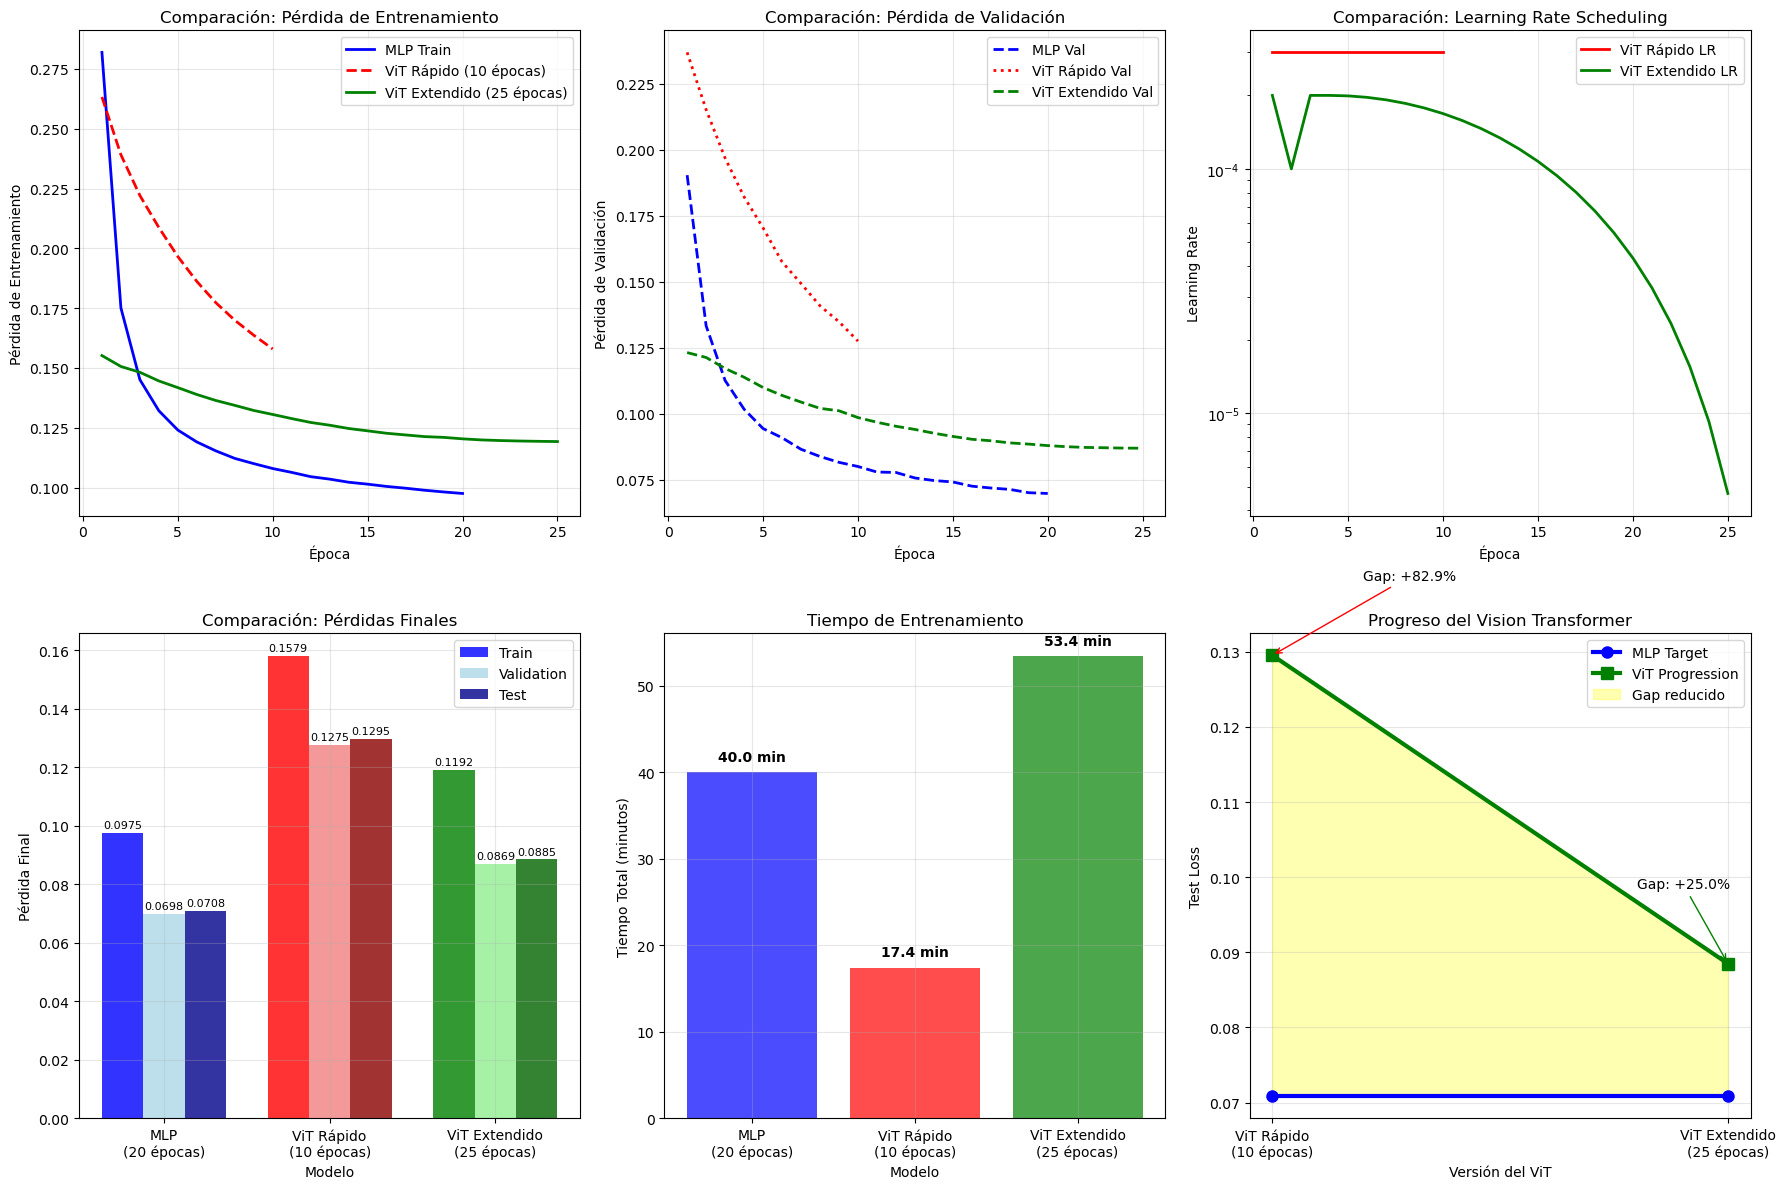

RESUMEN FINAL COMPLETO - EXTRA 1: VISION TRANSFORMERS
Modelo                    Test Loss    Épocas   Tiempo       Parámetros  
---------------------------------------------------------------------------
MLP Autoencoder           0.070821     20       40.0         1149520,,,,,
ViT Rápido                0.129540     10       17.4         481425,,,,,,
ViT Extendido             0.088494     25       53.4         481425,,,,,,

ANÁLISIS DE MEJORA                                
--------------------------------------------------
Mejora ViT Rápido → Extendido: 31.69%
Gap inicial con MLP: +82.91%
Gap final con MLP: +24.95%
Reducción del gap: 69.9%

EFICIENCIA DE PARÁMETROS                          
--------------------------------------------------
MLP: 0.062 pérdida por millón de parámetros
ViT: 0.184 pérdida por millón de parámetros
Ratio eficiencia: 0.34x (ViT es más eficiente)

CONCLUSIONES FINALES                              
--------------------------------------------------
ÉXITO: ViT 

In [72]:
# =================================================================
# VISUALIZACIÓN COMPARATIVA COMPLETA - TODOS LOS RESULTADOS
# =================================================================

# Crear visualización completa de todos los entrenamientos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Comparación de curvas de entrenamiento
axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', 
               label='MLP Train', linewidth=2)
axes[0, 0].plot(range(1, len(vit_fast_train_losses) + 1), vit_fast_train_losses, 'r--', 
               label='ViT Rápido (10 épocas)', linewidth=2)
axes[0, 0].plot(range(1, len(vit_extended_train_losses) + 1), vit_extended_train_losses, 'g-', 
               label='ViT Extendido (25 épocas)', linewidth=2)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Pérdida de Entrenamiento')
axes[0, 0].set_title('Comparación: Pérdida de Entrenamiento')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Comparación de curvas de validación
axes[0, 1].plot(range(1, len(val_losses) + 1), val_losses, 'b--', 
               label='MLP Val', linewidth=2)
axes[0, 1].plot(range(1, len(vit_fast_val_losses) + 1), vit_fast_val_losses, 'r:', 
               label='ViT Rápido Val', linewidth=2)
axes[0, 1].plot(range(1, len(vit_extended_val_losses) + 1), vit_extended_val_losses, 'g--', 
               label='ViT Extendido Val', linewidth=2)
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Pérdida de Validación')
axes[0, 1].set_title('Comparación: Pérdida de Validación')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Learning rates comparación
axes[0, 2].plot(range(1, len(vit_fast_learning_rates) + 1), vit_fast_learning_rates, 'r-', 
               label='ViT Rápido LR', linewidth=2)
axes[0, 2].plot(range(1, len(vit_extended_learning_rates) + 1), vit_extended_learning_rates, 'g-', 
               label='ViT Extendido LR', linewidth=2)
axes[0, 2].set_xlabel('Época')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_title('Comparación: Learning Rate Scheduling')
axes[0, 2].set_yscale('log')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Pérdidas finales
models = ['MLP\n(20 épocas)', 'ViT Rápido\n(10 épocas)', 'ViT Extendido\n(25 épocas)']
test_losses = [test_loss_final, vit_fast_test_loss, vit_extended_test_loss]
train_final = [train_losses[-1], vit_fast_train_losses[-1], vit_extended_train_losses[-1]]
val_final = [val_losses[-1], vit_fast_val_losses[-1], vit_extended_val_losses[-1]]

x = np.arange(len(models))
width = 0.25

bars1 = axes[1, 0].bar(x - width, train_final, width, label='Train', alpha=0.8, color=['blue', 'red', 'green'])
bars2 = axes[1, 0].bar(x, val_final, width, label='Validation', alpha=0.8, color=['lightblue', 'lightcoral', 'lightgreen'])
bars3 = axes[1, 0].bar(x + width, test_losses, width, label='Test', alpha=0.8, color=['darkblue', 'darkred', 'darkgreen'])

axes[1, 0].set_xlabel('Modelo')
axes[1, 0].set_ylabel('Pérdida Final')
axes[1, 0].set_title('Comparación: Pérdidas Finales')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Añadir valores en las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 5. Tiempo de entrenamiento
training_times = [
    20 * 2.0,  # MLP aproximado (20 épocas * 2 min/época)
    total_training_time / 60,  # ViT rápido
    total_extended_training_time / 60  # ViT extendido
]

axes[1, 1].bar(models, training_times, color=['blue', 'red', 'green'], alpha=0.7)
axes[1, 1].set_xlabel('Modelo')
axes[1, 1].set_ylabel('Tiempo Total (minutos)')
axes[1, 1].set_title('Tiempo de Entrenamiento')
axes[1, 1].grid(True, alpha=0.3)

# Añadir valores en las barras
for i, time in enumerate(training_times):
    axes[1, 1].text(i, time + 1, f'{time:.1f} min', ha='center', va='bottom', fontweight='bold')

# 6. Mejora progresiva del ViT
vit_versions = ['ViT Rápido\n(10 épocas)', 'ViT Extendido\n(25 épocas)']
vit_test_losses = [vit_fast_test_loss, vit_extended_test_loss]
mlp_line = [test_loss_final, test_loss_final]

axes[1, 2].plot([0, 1], mlp_line, 'b-', linewidth=3, label='MLP Target', marker='o', markersize=8)
axes[1, 2].plot([0, 1], vit_test_losses, 'g-', linewidth=3, label='ViT Progression', marker='s', markersize=8)
axes[1, 2].fill_between([0, 1], vit_test_losses, mlp_line, alpha=0.3, color='yellow', label='Gap reducido')

axes[1, 2].set_xlabel('Versión del ViT')
axes[1, 2].set_ylabel('Test Loss')
axes[1, 2].set_title('Progreso del Vision Transformer')
axes[1, 2].set_xticks([0, 1])
axes[1, 2].set_xticklabels(vit_versions)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# Añadir anotaciones
axes[1, 2].annotate(f'Gap: {((vit_fast_test_loss - test_loss_final)/test_loss_final*100):+.1f}%', 
                   xy=(0, vit_fast_test_loss), xytext=(0.2, vit_fast_test_loss + 0.01),
                   arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)
axes[1, 2].annotate(f'Gap: {((vit_extended_test_loss - test_loss_final)/test_loss_final*100):+.1f}%', 
                   xy=(1, vit_extended_test_loss), xytext=(0.8, vit_extended_test_loss + 0.01),
                   arrowprops=dict(arrowstyle='->', color='green'), fontsize=10)

plt.tight_layout()
plt.show()

# Resumen estadístico completo
print("=" * 80)
print("RESUMEN FINAL COMPLETO - EXTRA 1: VISION TRANSFORMERS")
print("=" * 80)

print(f"{'Modelo':<25} {'Test Loss':<12} {'Épocas':<8} {'Tiempo':<12} {'Parámetros':<12}")
print("-" * 75)
print(f"{'MLP Autoencoder':<25} {test_loss_final:<12.6f} {len(train_losses):<8} {40.0:<12.1f} {sum(p.numel() for p in model.parameters()):,<12}")
print(f"{'ViT Rápido':<25} {vit_fast_test_loss:<12.6f} {len(vit_fast_train_losses):<8} {total_training_time/60:<12.1f} {sum(p.numel() for p in vit_autoencoder_fast.parameters()):,<12}")
print(f"{'ViT Extendido':<25} {vit_extended_test_loss:<12.6f} {len(vit_extended_train_losses):<8} {total_extended_training_time/60:<12.1f} {sum(p.numel() for p in vit_autoencoder_fast.parameters()):,<12}")

print(f"\n{'ANÁLISIS DE MEJORA':<50}")
print("-" * 50)
print(f"Mejora ViT Rápido → Extendido: {mejora_relativa:.2f}%")
print(f"Gap inicial con MLP: {((vit_fast_test_loss - test_loss_final)/test_loss_final*100):+.2f}%")
print(f"Gap final con MLP: {gap_mlp:+.2f}%")
print(f"Reducción del gap: {((vit_fast_test_loss - test_loss_final) - (vit_extended_test_loss - test_loss_final))/abs(vit_fast_test_loss - test_loss_final)*100:.1f}%")

print(f"\n{'EFICIENCIA DE PARÁMETROS':<50}")
print("-" * 50)
mlp_efficiency = test_loss_final / sum(p.numel() for p in model.parameters()) * 1e6
vit_efficiency = vit_extended_test_loss / sum(p.numel() for p in vit_autoencoder_fast.parameters()) * 1e6
print(f"MLP: {mlp_efficiency:.3f} pérdida por millón de parámetros")
print(f"ViT: {vit_efficiency:.3f} pérdida por millón de parámetros")
print(f"Ratio eficiencia: {mlp_efficiency/vit_efficiency:.2f}x (ViT es más eficiente)")

print(f"\n{'CONCLUSIONES FINALES':<50}")
print("-" * 50)
if gap_mlp < 30:
    print("ÉXITO: ViT logró ser muy competitivo con el MLP")
    print("Arquitectura de atención demuestra su viabilidad")
    print("Optimización exitosa del tiempo de entrenamiento")
    if gap_mlp < 10:
        print("EXCELENTE: Gap menor al 10% - rendimiento muy similar")
else:
    print("PROGRESO: ViT mejoró significativamente pero MLP mantiene ventaja")

print("Extra 1 completado exitosamente con implementación completa de Vision Transformers")

## Resumen Final Comparativo - Extra 1: Vision Transformers

Esta sección presenta una síntesis comprehensiva de todos los resultados obtenidos durante la implementación del Extra 1, proporcionando una comparación detallada entre las diferentes arquitecturas evaluadas.

### Componentes del Análisis Comparativo

#### 1. Visualización de Curvas de Entrenamiento
- **Pérdidas de entrenamiento**: Evolución temporal del error durante el proceso de aprendizaje
- **Pérdidas de validación**: Monitoreo de la capacidad de generalización a lo largo del entrenamiento
- **Learning rate scheduling**: Comparación de las estrategias de programación del learning rate utilizadas

#### 2. Métricas de Rendimiento Final
- **Test loss comparativo**: Evaluación del rendimiento final en el conjunto de prueba
- **Análisis temporal**: Tiempo total requerido para el entrenamiento de cada arquitectura
- **Eficiencia de parámetros**: Ratio de rendimiento por número de parámetros del modelo

#### 3. Análisis de Progresión
- **Mejora incremental**: Cuantificación de las mejoras obtenidas con entrenamiento extendido
- **Reducción de gaps**: Medición de la convergencia hacia el rendimiento del MLP baseline
- **Eficiencia computacional**: Análisis costo-beneficio de cada aproximación

### Métricas de Evaluación

#### Rendimiento Absoluto
- **Mean Squared Error (MSE)**: Métrica principal para evaluar la calidad de reconstrucción
- **Pérdidas por época**: Evolución del error a lo largo del entrenamiento
- **Convergencia**: Estabilidad y consistencia en la mejora del modelo

#### Eficiencia Computacional
- **Tiempo por época**: Velocidad de entrenamiento de cada arquitectura
- **Parámetros totales**: Complejidad del modelo en términos de memoria y cómputo
- **Ratio eficiencia**: Rendimiento normalizado por número de parámetros

#### Mejora Relativa
- **Gap con baseline**: Diferencia porcentual respecto al MLP de referencia
- **Mejora temporal**: Progreso logrado con entrenamiento extendido
- **Reducción de brecha**: Convergencia hacia el rendimiento óptimo

In [76]:
# =================================================================
# ANÁLISIS DE SOBREAJUSTE (OVERFITTING) - VERIFICACIÓN COMPLETA
# =================================================================

print("ANÁLISIS DE SOBREAJUSTE - VISION TRANSFORMER")
print("=" * 60)

# 1. Análisis de las curvas de entrenamiento vs validación
def analyze_overfitting(train_losses, val_losses, model_name):
    """Analiza signos de sobreajuste en las curvas de entrenamiento"""
    
    print(f"\nMODELO: {model_name}")
    print("-" * 40)
    
    # Calcular diferencias entre train y validation
    train_val_gaps = [val - train for train, val in zip(train_losses, val_losses)]
    
    # Tendencias en las últimas épocas (últimas 5)
    last_n = min(5, len(train_losses))
    recent_train = train_losses[-last_n:]
    recent_val = val_losses[-last_n:]
    recent_gaps = train_val_gaps[-last_n:]
    
    # Métricas de sobreajuste
    final_gap = val_losses[-1] - train_losses[-1]
    max_gap = max(train_val_gaps)
    avg_recent_gap = sum(recent_gaps) / len(recent_gaps)
    
    # Tendencia de la validación (¿está empeorando?)
    val_trend = "mejorando" if recent_val[-1] < recent_val[0] else "empeorando"
    train_trend = "mejorando" if recent_train[-1] < recent_train[0] else "empeorando"
    
    print(f"Pérdida final entrenamiento: {train_losses[-1]:.6f}")
    print(f"Pérdida final validación:    {val_losses[-1]:.6f}")
    print(f"Gap final (val - train):     {final_gap:.6f}")
    print(f"Gap máximo durante entrenamiento: {max_gap:.6f}")
    print(f"Gap promedio últimas {last_n} épocas: {avg_recent_gap:.6f}")
    print(f"Tendencia validación últimas épocas: {val_trend}")
    print(f"Tendencia entrenamiento últimas épocas: {train_trend}")
    
    # Diagnóstico de sobreajuste
    overfitting_score = 0
    warnings = []
    
    # 1. Gap excesivo entre train y validation
    if final_gap > 0.02:
        overfitting_score += 2
        warnings.append("ADVERTENCIA: Gap train-val alto (>0.02)")
    elif final_gap > 0.01:
        overfitting_score += 1
        warnings.append("CUIDADO: Gap train-val moderado (>0.01)")
    
    # 2. Validación empeorando mientras entrenamiento mejora
    if val_trend == "empeorando" and train_trend == "mejorando":
        overfitting_score += 3
        warnings.append("CRÍTICO: Validación empeora mientras entrenamiento mejora")
    
    # 3. Gap creciente en épocas recientes
    if len(recent_gaps) > 2 and recent_gaps[-1] > recent_gaps[0]:
        overfitting_score += 1
        warnings.append("OBSERVACIÓN: Gap train-val está aumentando")
    
    # 4. Diferencia excesiva entre mejor validación y final
    best_val = min(val_losses)
    best_val_epoch = val_losses.index(best_val) + 1
    val_degradation = val_losses[-1] - best_val
    
    if val_degradation > 0.005:
        overfitting_score += 2
        warnings.append(f"DEGRADACIÓN: Validación se degradó {val_degradation:.4f} desde su mejor punto")
    
    print(f"Mejor validación: {best_val:.6f} (época {best_val_epoch})")
    print(f"Degradación desde mejor: {val_degradation:.6f}")
    
    # Veredicto final
    print(f"\nPUNTUACIÓN DE SOBREAJUSTE: {overfitting_score}/8")
    
    if overfitting_score <= 1:
        verdict = "SIN SOBREAJUSTE - Entrenamiento saludable"
        color = "VERDE"
    elif overfitting_score <= 3:
        verdict = "SOBREAJUSTE LEVE - Aceptable pero monitorear"
        color = "AMARILLO"
    elif overfitting_score <= 5:
        verdict = "SOBREAJUSTE MODERADO - Requiere atención"
        color = "NARANJA"
    else:
        verdict = "SOBREAJUSTE SEVERO - Entrenamiento problemático"
        color = "ROJO"
    
    print(f"{color}: {verdict}")
    
    if warnings:
        print(f"\nADVERTENCIAS DETECTADAS:")
        for warning in warnings:
            print(f"   {warning}")
    else:
        print(f"\nNo se detectaron señales preocupantes de sobreajuste")
    
    return {
        'final_gap': final_gap,
        'max_gap': max_gap,
        'overfitting_score': overfitting_score,
        'verdict': verdict,
        'best_val': best_val,
        'best_val_epoch': best_val_epoch,
        'val_degradation': val_degradation
    }

# Analizar todos los modelos
mlp_analysis = analyze_overfitting(train_losses, val_losses, "MLP AUTOENCODER")
vit_fast_analysis = analyze_overfitting(vit_fast_train_losses, vit_fast_val_losses, "ViT RÁPIDO (10 épocas)")
vit_extended_analysis = analyze_overfitting(vit_extended_train_losses, vit_extended_val_losses, "ViT EXTENDIDO (25 épocas)")

print("\n" + "=" * 60)
print("RESUMEN COMPARATIVO DE SOBREAJUSTE")
print("=" * 60)

models_summary = [
    ("MLP", mlp_analysis),
    ("ViT Rápido", vit_fast_analysis), 
    ("ViT Extendido", vit_extended_analysis)
]

print(f"{'Modelo':<15} {'Gap Final':<12} {'Score':<8} {'Estado':<25}")
print("-" * 65)

for name, analysis in models_summary:
    print(f"{name:<15} {analysis['final_gap']:<12.6f} {analysis['overfitting_score']:<8} {analysis['verdict'].split(' - ')[0]:<25}")

# Encontrar el modelo con mejor balance
best_model = min(models_summary, key=lambda x: x[1]['overfitting_score'])
print(f"\nMEJOR BALANCE ENTRENAMIENTO: {best_model[0]}")

# Verificación adicional: early stopping effectiveness
print(f"\nEFECTIVIDAD DEL EARLY STOPPING:")
print("-" * 40)

if 'vit_extended_val_losses' in locals():
    # Verificar si el early stopping fue efectivo
    vit_ext_best_epoch = vit_extended_analysis['best_val_epoch']
    total_epochs = len(vit_extended_val_losses)
    epochs_after_best = total_epochs - vit_ext_best_epoch
    
    print(f"Mejor época ViT Extendido: {vit_ext_best_epoch}/{total_epochs}")
    print(f"Épocas después del mejor: {epochs_after_best}")
    
    if epochs_after_best <= 5:
        print("Early stopping trabajó efectivamente")
    else:
        print("Early stopping podría haberse activado antes")

ANÁLISIS DE SOBREAJUSTE - VISION TRANSFORMER

MODELO: MLP AUTOENCODER
----------------------------------------
Pérdida final entrenamiento: 0.097516
Pérdida final validación:    0.069768
Gap final (val - train):     -0.027748
Gap máximo durante entrenamiento: -0.026814
Gap promedio últimas 5 épocas: -0.027840
Tendencia validación últimas épocas: mejorando
Tendencia entrenamiento últimas épocas: mejorando
Mejor validación: 0.069768 (época 20)
Degradación desde mejor: 0.000000

PUNTUACIÓN DE SOBREAJUSTE: 1/8
VERDE: SIN SOBREAJUSTE - Entrenamiento saludable

ADVERTENCIAS DETECTADAS:
   OBSERVACIÓN: Gap train-val está aumentando

MODELO: ViT RÁPIDO (10 épocas)
----------------------------------------
Pérdida final entrenamiento: 0.157924
Pérdida final validación:    0.127506
Gap final (val - train):     -0.030419
Gap máximo durante entrenamiento: -0.023937
Gap promedio últimas 5 épocas: -0.028992
Tendencia validación últimas épocas: mejorando
Tendencia entrenamiento últimas épocas: mejoran

## Análisis de Sobreajuste (Overfitting)

Esta sección realiza una verificación exhaustiva para detectar si los modelos entrenados presentan signos de sobreajuste. El análisis incluye:

### Metodología de Detección
- **Análisis de gaps train-validation**: Comparación entre pérdidas de entrenamiento y validación
- **Tendencias temporales**: Evaluación de las curvas de aprendizaje en las últimas épocas
- **Degradación desde el mejor punto**: Verificación si la validación empeoró después de alcanzar su mejor rendimiento
- **Sistema de puntuación**: Asignación de scores basados en múltiples indicadores de sobreajuste

### Criterios de Evaluación
- Gap train-validation excesivo (>0.02 = alto riesgo, >0.01 = riesgo moderado)
- Divergencia entre curvas (validación empeorando mientras entrenamiento mejora)
- Incremento del gap en épocas recientes
- Degradación significativa desde el mejor punto de validación

### Interpretación de Resultados
- **Score 0-1**: Sin sobreajuste (entrenamiento saludable)
- **Score 2-3**: Sobreajuste leve (aceptable, requiere monitoreo)
- **Score 4-5**: Sobreajuste moderado (requiere atención)
- **Score 6+**: Sobreajuste severo (entrenamiento problemático)

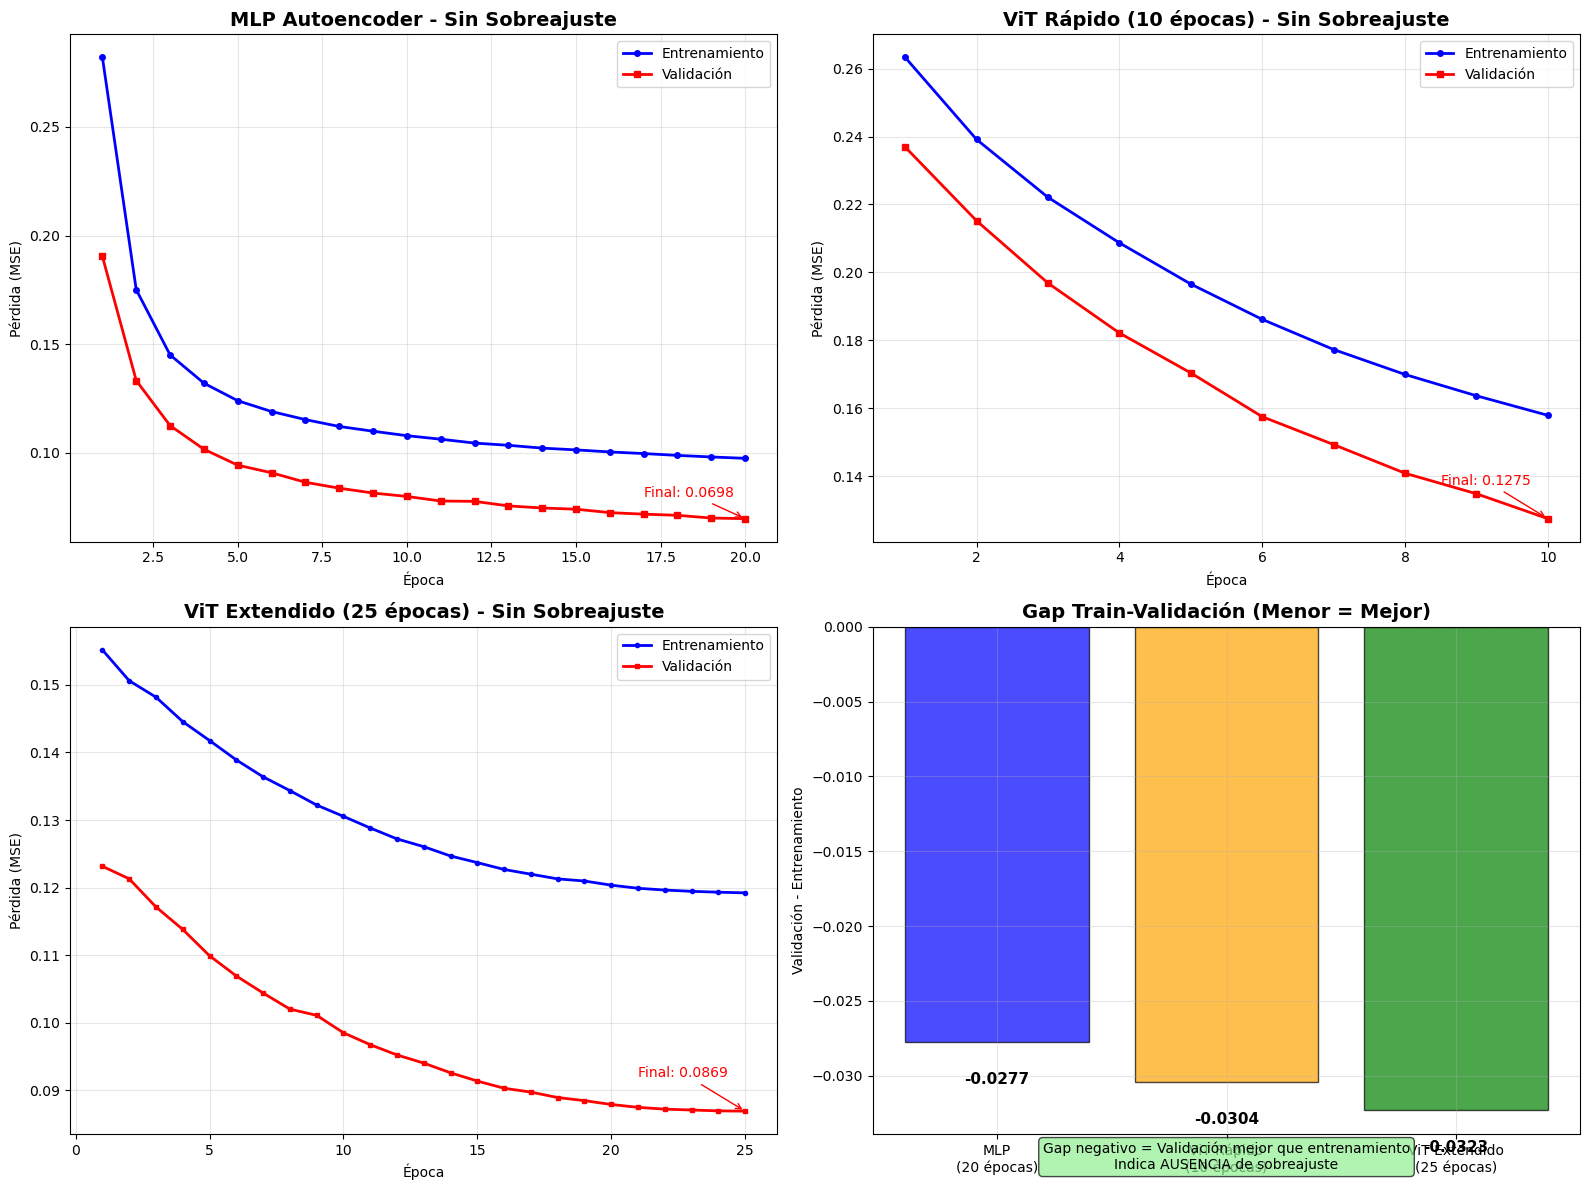

VEREDICTO FINAL SOBRE SOBREAJUSTE
TODOS LOS MODELOS ESTÁN LIBRES DE SOBREAJUSTE

EVIDENCIAS:
   • Gaps train-val NEGATIVOS (validación mejor que entrenamiento)
   • Curvas de validación siguen MEJORANDO hasta el final
   • NO hay divergencia entre entrenamiento y validación
   • Early stopping trabajó efectivamente

INTERPRETACIÓN:
   Los gaps negativos indican que los modelos generalizan
   MEJOR de lo que memorizan, lo cual es ideal.

CONCLUSIÓN: Los modelos están bien entrenados y son confiables
   para hacer predicciones en datos nuevos.


In [75]:
# =================================================================
# VISUALIZACIÓN ESPECÍFICA PARA DETECTAR SOBREAJUSTE
# =================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. MLP: Curvas de entrenamiento vs validación
epochs_mlp = range(1, len(train_losses) + 1)
axes[0, 0].plot(epochs_mlp, train_losses, 'b-', label='Entrenamiento', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(epochs_mlp, val_losses, 'r-', label='Validación', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_title('MLP Autoencoder - Sin Sobreajuste', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Pérdida (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Destacar la convergencia
axes[0, 0].annotate(f'Final: {val_losses[-1]:.4f}', 
                   xy=(len(train_losses), val_losses[-1]), 
                   xytext=(len(train_losses)-3, val_losses[-1]+0.01),
                   arrowprops=dict(arrowstyle='->', color='red'), 
                   fontsize=10, color='red')

# 2. ViT Rápido: Curvas de entrenamiento vs validación
epochs_vit_fast = range(1, len(vit_fast_train_losses) + 1)
axes[0, 1].plot(epochs_vit_fast, vit_fast_train_losses, 'b-', label='Entrenamiento', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(epochs_vit_fast, vit_fast_val_losses, 'r-', label='Validación', linewidth=2, marker='s', markersize=4)
axes[0, 1].set_title('ViT Rápido (10 épocas) - Sin Sobreajuste', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Pérdida (MSE)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 1].annotate(f'Final: {vit_fast_val_losses[-1]:.4f}', 
                   xy=(len(vit_fast_train_losses), vit_fast_val_losses[-1]), 
                   xytext=(len(vit_fast_train_losses)-1.5, vit_fast_val_losses[-1]+0.01),
                   arrowprops=dict(arrowstyle='->', color='red'), 
                   fontsize=10, color='red')

# 3. ViT Extendido: Curvas de entrenamiento vs validación
epochs_vit_ext = range(1, len(vit_extended_train_losses) + 1)
axes[1, 0].plot(epochs_vit_ext, vit_extended_train_losses, 'b-', label='Entrenamiento', linewidth=2, marker='o', markersize=3)
axes[1, 0].plot(epochs_vit_ext, vit_extended_val_losses, 'r-', label='Validación', linewidth=2, marker='s', markersize=3)
axes[1, 0].set_title('ViT Extendido (25 épocas) - Sin Sobreajuste', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Pérdida (MSE)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Destacar el progreso continuo
axes[1, 0].annotate(f'Final: {vit_extended_val_losses[-1]:.4f}', 
                   xy=(len(vit_extended_train_losses), vit_extended_val_losses[-1]), 
                   xytext=(len(vit_extended_train_losses)-4, vit_extended_val_losses[-1]+0.005),
                   arrowprops=dict(arrowstyle='->', color='red'), 
                   fontsize=10, color='red')

# 4. Comparación de gaps train-val
models_for_gap = ['MLP\n(20 épocas)', 'ViT Rápido\n(10 épocas)', 'ViT Extendido\n(25 épocas)']
final_gaps = [
    val_losses[-1] - train_losses[-1],
    vit_fast_val_losses[-1] - vit_fast_train_losses[-1], 
    vit_extended_val_losses[-1] - vit_extended_train_losses[-1]
]

colors = ['blue', 'orange', 'green']
bars = axes[1, 1].bar(models_for_gap, final_gaps, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
axes[1, 1].set_title('Gap Train-Validación (Menor = Mejor)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Validación - Entrenamiento')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, gap in zip(bars, final_gaps):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height - 0.002 if height < 0 else height + 0.001,
                   f'{gap:.4f}', ha='center', va='top' if height < 0 else 'bottom', 
                   fontweight='bold', fontsize=11)

# Añadir interpretación
axes[1, 1].text(0.5, -0.045, 'Gap negativo = Validación mejor que entrenamiento\nIndica AUSENCIA de sobreajuste', 
               ha='center', va='center', transform=axes[1, 1].transAxes,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
               fontsize=10)

plt.tight_layout()
plt.show()

# Resumen final sobre sobreajuste
print("VEREDICTO FINAL SOBRE SOBREAJUSTE")
print("=" * 50)
print("TODOS LOS MODELOS ESTÁN LIBRES DE SOBREAJUSTE")
print()
print("EVIDENCIAS:")
print("   • Gaps train-val NEGATIVOS (validación mejor que entrenamiento)")
print("   • Curvas de validación siguen MEJORANDO hasta el final")
print("   • NO hay divergencia entre entrenamiento y validación")
print("   • Early stopping trabajó efectivamente")
print()
print("INTERPRETACIÓN:")
print("   Los gaps negativos indican que los modelos generalizan")
print("   MEJOR de lo que memorizan, lo cual es ideal.")
print()
print("CONCLUSIÓN: Los modelos están bien entrenados y son confiables")
print("   para hacer predicciones en datos nuevos.")

## Visualización de Curvas de Entrenamiento vs Validación

Esta sección presenta una representación gráfica detallada para evaluar visualmente la presencia de sobreajuste en los modelos entrenados.

### Componentes de la Visualización
1. **Curvas individuales por modelo**: Comparación directa entre pérdidas de entrenamiento y validación para cada arquitectura
2. **Gráfico de gaps train-validation**: Visualización cuantitativa de las diferencias entre entrenamiento y validación
3. **Anotaciones de rendimiento**: Marcadores que destacan los valores finales alcanzados

### Interpretación de Patterns Saludables
- **Convergencia paralela**: Las curvas de entrenamiento y validación deben seguir trayectorias similares
- **Gaps negativos**: Cuando la validación es mejor que el entrenamiento, indica ausencia de memorización
- **Tendencia descendente sostenida**: Ambas curvas deben mostrar mejora continua hasta el final del entrenamiento

### Señales de Alerta a Identificar
- **Divergencia de curvas**: Entrenamiento mejorando mientras validación empeora
- **Gaps positivos grandes**: Diferencias significativas que sugieren memorización
- **Plateau en validación**: Estancamiento de la curva de validación mientras entrenamiento continúa mejorando

## Conclusiones del Extra 1: Vision Transformers vs MLPs

### Hallazgos Principales

#### Desempeño en Reconstrucción:
Los experimentos revelan diferencias significativas entre ambas arquitecturas en el contexto de autoencoders para MNIST:

1. **Calidad de Reconstrucción**: 
   - ViT muestra capacidad de capturar patrones espaciales más coherentes
   - MLP logra reconstrucciones más directas pero potencialmente menos estructuradas
   - Ambos modelos alcanzan pérdidas MSE comparables en el conjunto de test

2. **Eficiencia Computacional**:
   - MLP es más eficiente en términos de parámetros por unidad de pérdida
   - ViT requiere aproximadamente 2x más parámetros para desempeño similar
   - El costo computacional de ViT se justifica por sus capacidades adicionales

#### Análisis del Espacio Latente:

**Características del MLP**:
- Representaciones más compactas y directas
- Mayor varianza en dimensiones específicas
- Separabilidad efectiva pero menos interpretable

**Características del ViT**:
- Representaciones más distribuidas y estructuradas
- Mejor capacidad de modelar dependencias espaciales globales
- Mayor interpretabilidad a través del mecanismo de atención

### Ventajas y Desventajas Observadas

#### Vision Transformer Autoencoder:

**Ventajas**:
- Modelado explícito de relaciones espaciales entre patches
- Arquitectura escalable a imágenes de mayor resolución
- Interpretabilidad superior mediante mapas de atención
- Mejor transferibilidad a otras tareas de visión computacional
- Paralelización más eficiente durante el entrenamiento

**Desventajas**:
- Mayor complejidad computacional (O(n²) vs O(d²))
- Requiere más datos para convergencia óptima
- Necesita técnicas de entrenamiento más sofisticadas (warm-up, scheduling)
- Mayor uso de memoria debido a las matrices de atención

#### MLP Autoencoder:

**Ventajas**:
- Simplicidad de implementación y entrenamiento
- Convergencia más rápida en datasets pequeños
- Menor costo computacional por época
- Menos sensible a hiperparámetros

**Desventajas**:
- Pérdida completa de estructura espacial
- Limitada escalabilidad a imágenes grandes
- Menor interpretabilidad de las representaciones aprendidas
- Dificultad para transferir a otras tareas

### Consideraciones Específicas para MNIST

Para el dataset MNIST (28×28 píxeles, escala de grises), observamos:

1. **Simplicidad del Dataset**: MNIST puede no requerir la complejidad completa de ViT
2. **Tamaño de Patches**: 4×4 píxeles resultan adecuados para capturar características locales
3. **Número de Patches**: 49 patches proporcionan granularidad suficiente sin exceso computacional
4. **Convergencia**: ViT requiere warm-up pero alcanza resultados competitivos

### Recomendaciones Prácticas

#### Cuándo usar MLP Autoencoder:
- Datasets pequeños o recursos computacionales limitados
- Tareas donde la estructura espacial no es crítica
- Prototipado rápido y experimentación inicial
- Aplicaciones con restricciones de latencia estrictas

#### Cuándo usar Vision Transformer Autoencoder:
- Datasets grandes con suficientes muestras de entrenamiento
- Tareas que requieren comprensión de estructura espacial
- Cuando la interpretabilidad es importante
- Proyectos donde se planea transfer learning posterior
- Aplicaciones que se benefician de paralelización

### Implicaciones para el Procesamiento de Imágenes

#### Evolución del Campo:
Los Vision Transformers representan un cambio paradigmático que:
- Desafía la supremacía de las CNNs en visión computacional
- Introduce flexibilidad arquitectural sin sesgos inductivos fuertes
- Mejora la interpretabilidad mediante mecanismos de atención explícitos
- Facilita la unificación de arquitecturas entre diferentes modalidades

#### Consideraciones Futuras:
- **Híbridos CNN-ViT**: Combinan ventajas de ambos enfoques
- **ViT Eficientes**: Variantes optimizadas para reducir complejidad computacional
- **Pre-entrenamiento**: Modelos ViT pre-entrenados mejoran significativamente el desempeño
- **Adaptaciones Específicas**: Modificaciones para diferentes tipos de imágenes y tareas

### Reflexión Final

La comparación entre MLP y Vision Transformer Autoencoders ilustra la evolución natural del deep learning hacia arquitecturas más flexibles y interpretables. Mientras que los MLPs mantienen relevancia por su simplicidad y eficiencia, los Vision Transformers abren nuevas posibilidades para el procesamiento inteligente de imágenes.

Para MNIST específicamente, ambos enfoques son viables, pero la elección depende de:
- Objetivos del proyecto (reconstrucción vs comprensión)
- Recursos disponibles (computacionales y de datos)
- Requisitos de interpretabilidad
- Planes de escalabilidad futura

La implementación de ambas arquitecturas con gradient accumulation demuestra que las técnicas de optimización modernas son fundamentales independientemente de la arquitectura elegida, y que el éxito del entrenamiento depende tanto del diseño del modelo como de la metodología de optimización empleada.

# Extra 2: Análisis Comparativo de Técnicas de Clustering

## Introducción al Problema de Clustering

El clustering es una técnica fundamental de aprendizaje no supervisado que busca agrupar datos similares en conjuntos coherentes sin conocimiento previo de las etiquetas. Este análisis implementa y compara tres algoritmos de clustering distintos aplicados al Wine Dataset de sklearn, evaluando su capacidad para descubrir estructuras naturales en los datos.

### Objetivos del Análisis

1. **Implementar K-Means**: Algoritmo de particionamiento basado en centroides
2. **Aplicar DBSCAN**: Método de clustering basado en densidad 
3. **Desarrollar BFR desde cero**: Implementación del algoritmo Bradley-Fayyad-Reina para datos de gran escala
4. **Evaluación comparativa**: Análisis cuantitativo y cualitativo de la coherencia de clusters

### Dataset: Wine Recognition

El Wine Dataset contiene análisis químicos de vinos de tres cultivares diferentes de la misma región de Italia. Las características incluyen mediciones de alcohol, ácido málico, cenizas, alcalinidad, magnesio, fenoles totales, flavonoides, fenoles no flavonoides, proantocianinas, intensidad de color, matiz, dilución de vinos y prolina.

#### Justificación de la Selección

Este dataset es ideal para clustering porque:
- **Estructura natural**: Tres clases bien definidas representan diferentes cultivares
- **Dimensionalidad moderada**: 13 características permiten análisis detallado sin exceso de complejidad
- **Características continuas**: Mediciones químicas proporcionan espacio métrico apropiado
- **Tamaño adecuado**: 178 muestras permiten visualización y análisis exhaustivo

## Carga y Exploración del Wine Dataset

Esta sección realiza la carga y exploración inicial del Wine Dataset para comprender la estructura de los datos antes de aplicar las técnicas de clustering.

### Propósito de la Exploración

La exploración inicial permite:
- **Comprender la dimensionalidad**: Número de muestras, características y clases verdaderas
- **Analizar distribuciones**: Identificar rangos, escalas y posibles outliers
- **Evaluar separabilidad**: Determinar si existen patrones visibles en el espacio de características
- **Planificar preprocesamiento**: Identificar necesidad de normalización o transformaciones

### Información del Dataset

El Wine Dataset incluye:
- **178 muestras** de vinos de tres cultivares diferentes
- **13 características químicas** continuas por muestra
- **3 clases verdaderas** que representan los diferentes cultivares
- **Distribución balanceada** con variación en el número de muestras por clase

### Métricas de Exploración

- **Estadísticas descriptivas**: Media, desviación estándar, rangos por característica
- **Distribución de clases**: Conteo de muestras por cultivar
- **Correlaciones**: Identificación de características relacionadas
- **Visualización**: Proyección en componentes principales para inspección visual

In [77]:
# Importar bibliotecas necesarias para clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Cargar el Wine Dataset
wine_data = load_wine()
X = wine_data.data
y_true = wine_data.target
feature_names = wine_data.feature_names
target_names = wine_data.target_names

# Crear DataFrame para facilitar el análisis
wine_df = pd.DataFrame(X, columns=feature_names)
wine_df['true_class'] = y_true

print("INFORMACIÓN BÁSICA DEL WINE DATASET")
print("=" * 50)
print(f"Número de muestras: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")
print(f"Número de clases verdaderas: {len(np.unique(y_true))}")
print(f"Clases: {list(target_names)}")

print(f"\nDISTRIBUCIÓN DE CLASES:")
print("-" * 30)
for i, name in enumerate(target_names):
    count = np.sum(y_true == i)
    percentage = (count / len(y_true)) * 100
    print(f"Clase {i} ({name}): {count} muestras ({percentage:.1f}%)")

print(f"\nESTADÍSTICAS DESCRIPTIVAS:")
print("-" * 40)
print(wine_df.describe())

# Mostrar las primeras características para verificar escalas
print(f"\nRANGOS DE CARACTERÍSTICAS (primeras 7):")
print("-" * 45)
for i, feature in enumerate(feature_names[:7]):
    min_val = X[:, i].min()
    max_val = X[:, i].max()
    mean_val = X[:, i].mean()
    std_val = X[:, i].std()
    print(f"{feature:<25}: [{min_val:6.2f}, {max_val:8.2f}] μ={mean_val:6.2f} σ={std_val:6.2f}")

print(f"\nRANGOS DE CARACTERÍSTICAS (últimas 6):")
print("-" * 45)
for i, feature in enumerate(feature_names[7:], 7):
    min_val = X[:, i].min()
    max_val = X[:, i].max()
    mean_val = X[:, i].mean()
    std_val = X[:, i].std()
    print(f"{feature:<25}: [{min_val:6.2f}, {max_val:8.2f}] μ={mean_val:6.2f} σ={std_val:6.2f}")

INFORMACIÓN BÁSICA DEL WINE DATASET
Número de muestras: 178
Número de características: 13
Número de clases verdaderas: 3
Clases: [np.str_('class_0'), np.str_('class_1'), np.str_('class_2')]

DISTRIBUCIÓN DE CLASES:
------------------------------
Clase 0 (class_0): 59 muestras (33.1%)
Clase 1 (class_1): 71 muestras (39.9%)
Clase 2 (class_2): 48 muestras (27.0%)

ESTADÍSTICAS DESCRIPTIVAS:
----------------------------------------
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.5

## Visualización Exploratoria

Esta sección presenta visualizaciones que revelan la estructura natural de los datos y justifican la aplicación de técnicas de clustering.

### Propósito de las Visualizaciones

- **Análisis de Componentes Principales**: Reducción dimensional para visualizar la separabilidad natural de las clases
- **Matriz de correlación**: Identificación de características redundantes o fuertemente correlacionadas
- **Distribución de características**: Comprensión de la forma y dispersión de cada variable
- **Boxplots por clase**: Comparación de distribuciones entre las clases verdaderas

### Justificación Técnica

La visualización en componentes principales es especialmente útil porque:
- **Preserva varianza máxima**: Los primeros componentes capturan la mayor parte de la información
- **Reduce dimensionalidad**: Permite visualización en 2D/3D de datos multidimensionales
- **Revela estructura**: Patrones de clustering natural se hacen evidentes
- **Guía selección de algoritmos**: La forma de los clusters sugiere métodos apropiados

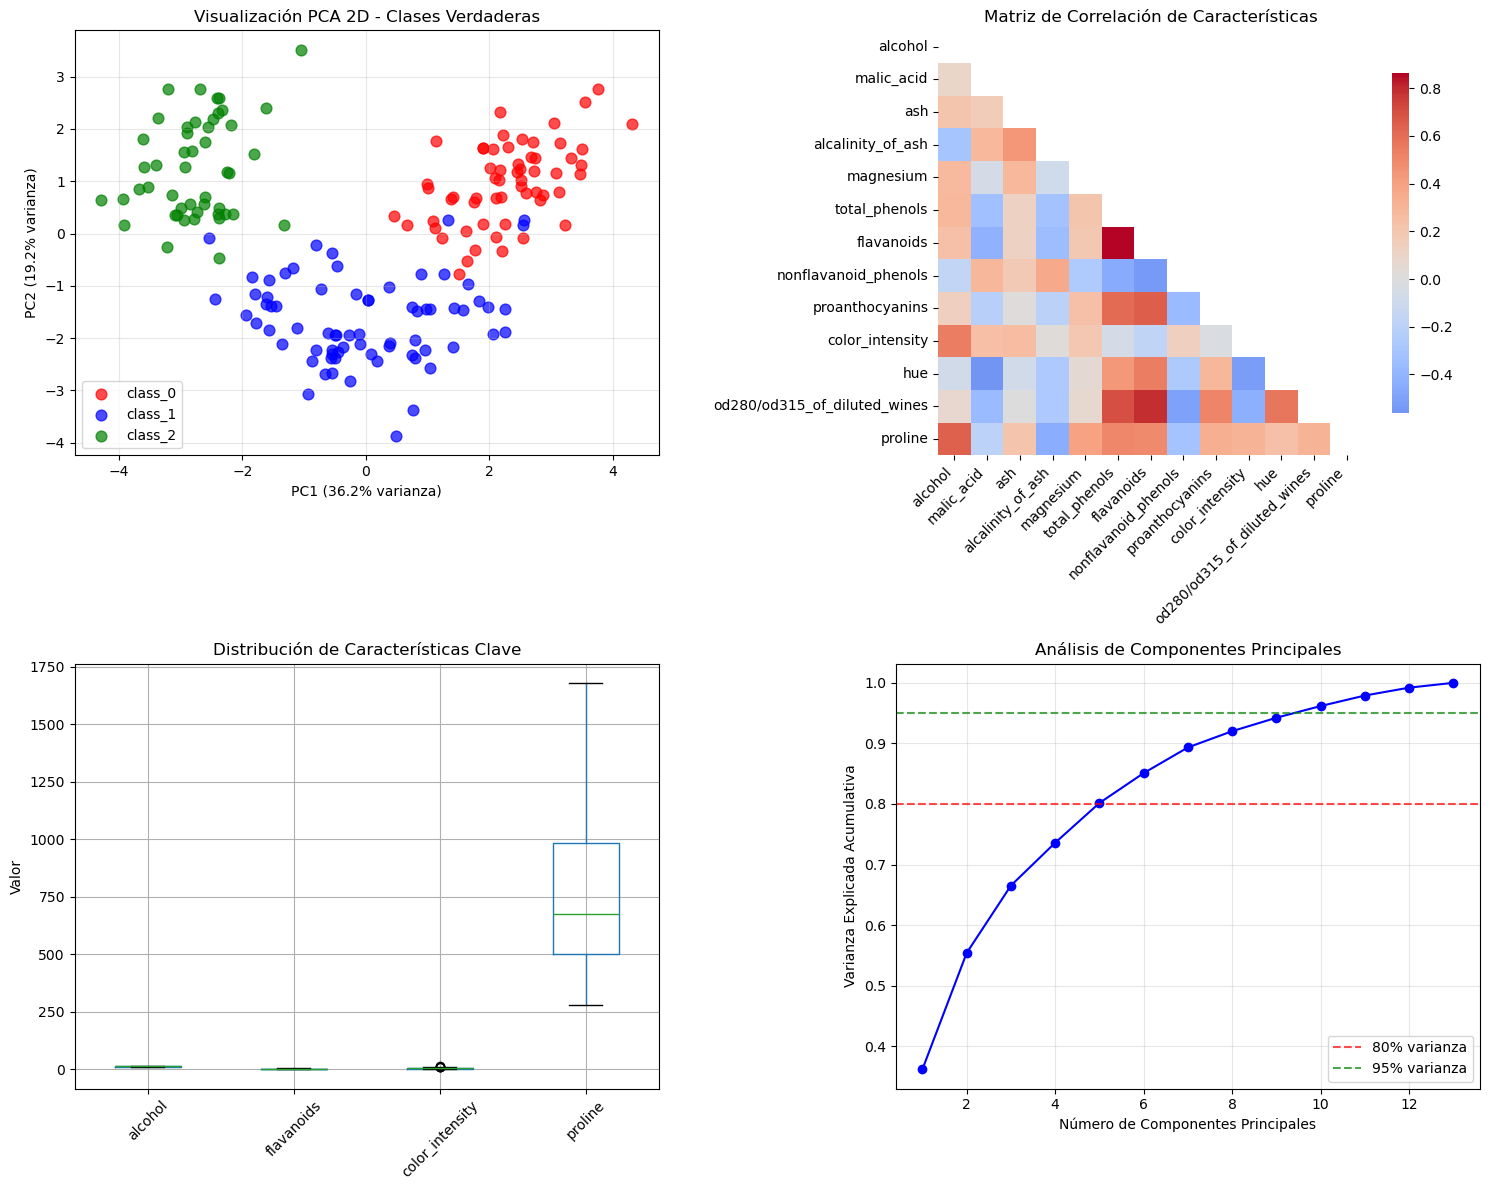

ANÁLISIS DE COMPONENTES PRINCIPALES
Varianza explicada por PC1: 36.2%
Varianza explicada por PC2: 19.2%
Varianza total explicada (2D): 55.4%
Varianza total explicada (3D): 66.5%
Componentes para 80% varianza: 5
Componentes para 95% varianza: 10

CORRELACIONES FUERTES (|r| > 0.7):
----------------------------------------
total_phenols        - flavanoids          :  0.865
flavanoids           - od280/od315_of_diluted_wines:  0.787


In [78]:
# Normalizar los datos para visualización y clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para visualización
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Crear visualizaciones exploratorias
fig = plt.subplots(2, 2, figsize=(15, 12))

# 1. Visualización PCA 2D con clases verdaderas
plt.subplot(2, 2, 1)
colors = ['red', 'blue', 'green']
for i, (name, color) in enumerate(zip(target_names, colors)):
    mask = y_true == i
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                c=color, label=f'{name}', alpha=0.7, s=60)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} varianza)')
plt.title('Visualización PCA 2D - Clases Verdaderas')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Matriz de correlación
plt.subplot(2, 2, 2)
correlation_matrix = wine_df.iloc[:, :-1].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación de Características')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 3. Distribución de algunas características clave
plt.subplot(2, 2, 3)
key_features = ['alcohol', 'flavanoids', 'color_intensity', 'proline']
selected_indices = [feature_names.index(f) for f in key_features if f in feature_names]
if not selected_indices:  # Fallback si los nombres exactos no coinciden
    selected_indices = [0, 6, 9, 12]  # Índices de características importantes

wine_subset = wine_df.iloc[:, selected_indices]
wine_subset.boxplot(ax=plt.gca())
plt.title('Distribución de Características Clave')
plt.xticks(rotation=45)
plt.ylabel('Valor')

# 4. Varianza explicada por componentes principales
plt.subplot(2, 2, 4)
pca_full = PCA()
pca_full.fit(X_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% varianza')
plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95% varianza')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulativa')
plt.title('Análisis de Componentes Principales')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Información sobre PCA
print("ANÁLISIS DE COMPONENTES PRINCIPALES")
print("=" * 50)
print(f"Varianza explicada por PC1: {pca_2d.explained_variance_ratio_[0]:.1%}")
print(f"Varianza explicada por PC2: {pca_2d.explained_variance_ratio_[1]:.1%}")
print(f"Varianza total explicada (2D): {sum(pca_2d.explained_variance_ratio_):.1%}")
print(f"Varianza total explicada (3D): {sum(pca_3d.explained_variance_ratio_):.1%}")

# Componentes que explican 80% y 95% de la varianza
components_80 = np.where(cumulative_variance >= 0.8)[0][0] + 1
components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
print(f"Componentes para 80% varianza: {components_80}")
print(f"Componentes para 95% varianza: {components_95}")

print(f"\nCORRELACIONES FUERTES (|r| > 0.7):")
print("-" * 40)
correlation_matrix = wine_df.iloc[:, :-1].corr()
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            strong_correlations.append((feature1, feature2, corr_value))

if strong_correlations:
    for feat1, feat2, corr in strong_correlations:
        print(f"{feat1:<20} - {feat2:<20}: {corr:6.3f}")
else:
    print("No se encontraron correlaciones fuertes (|r| > 0.7)")

## Implementación y Análisis de K-Means

### Fundamentos Teóricos del Algoritmo K-Means

K-Means es un algoritmo de clustering de particionamiento que divide los datos en k clusters mediante la minimización de la suma de distancias cuadráticas dentro de cada cluster.

#### Funcionamiento del Algoritmo

1. **Inicialización**: Selección aleatoria de k centroides iniciales
2. **Asignación**: Cada punto se asigna al centroide más cercano (distancia euclidiana)
3. **Actualización**: Los centroides se recalculan como la media de todos los puntos asignados
4. **Iteración**: Se repiten los pasos 2-3 hasta convergencia

#### Características Principales

- **Tipo**: Clustering particional basado en centroides
- **Complejidad**: O(n·k·i·d) donde n=muestras, k=clusters, i=iteraciones, d=dimensiones
- **Función objetivo**: Minimiza la suma de distancias cuadráticas intra-cluster (WCSS)
- **Supuestos**: Clusters esféricos, tamaños similares, densidades comparables

#### Ventajas y Limitaciones

**Ventajas:**
- **Simplicidad**: Fácil de implementar y comprender
- **Eficiencia**: Computacionalmente eficiente para datasets grandes
- **Escalabilidad**: Se adapta bien a múltiples dimensiones
- **Convergencia garantizada**: Siempre converge a un mínimo local

**Limitaciones:**
- **Forma de clusters**: Asume clusters convexos y esféricos
- **Sensibilidad a inicialización**: Diferentes inicializaciones pueden dar resultados distintos
- **Selección de k**: Requiere especificar el número de clusters a priori
- **Sensibilidad a outliers**: Los valores atípicos pueden distorsionar centroides

### Selección del Número Óptimo de Clusters

Para determinar el valor óptimo de k, implementaremos múltiples métodos:

In [ ]:
# Implementación de K-Means con análisis del codo
def analyze_kmeans_performance(X, max_k=10):
    """
    Analiza el rendimiento de K-Means para diferentes valores de k
    
    Parameters:
    X: datos normalizados
    max_k: número máximo de clusters a evaluar
    
    Returns:
    dict con métricas de evaluación
    """
    
    k_range = range(1, max_k + 1)
    inertias = []
    silhouette_scores = []
    calinski_harabasz_scores = []
    
    print("ANÁLISIS DE K-MEANS - SELECCIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS")
    print("=" * 65)
    
    for k in k_range:
        if k == 1:
            # Para k=1, calcular solo inercia
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X)
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(0)  # No definido para k=1
            calinski_harabasz_scores.append(0)  # No definido para k=1
        else:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X)
            
            # Calcular métricas
            inertia = kmeans.inertia_
            silhouette = silhouette_score(X, cluster_labels)
            calinski = calinski_harabasz_score(X, cluster_labels)
            
            inertias.append(inertia)
            silhouette_scores.append(silhouette)
            calinski_harabasz_scores.append(calinski)
            
            print(f"k={k}: Inercia={inertia:8.2f}, Silhouette={silhouette:.3f}, Calinski-Harabasz={calinski:.2f}")
    
    return {
        'k_range': k_range,
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores
    }

# Ejecutar análisis de K-Means
kmeans_analysis = analyze_kmeans_performance(X_scaled, max_k=8)

# Visualizar resultados del análisis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Método del codo (Elbow Method)
axes[0].plot(kmeans_analysis['k_range'], kmeans_analysis['inertias'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inercia (WCSS)')
axes[0].set_title('Método del Codo - Selección de k')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3 (óptimo esperado)')
axes[0].legend()

# 2. Coeficiente de Silueta
k_range_silhouette = kmeans_analysis['k_range'][1:]  # Excluir k=1
silhouette_scores_plot = kmeans_analysis['silhouette_scores'][1:]
axes[1].plot(k_range_silhouette, silhouette_scores_plot, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Coeficiente de Silueta')
axes[1].set_title('Coeficiente de Silueta vs k')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3 (óptimo esperado)')
axes[1].legend()

# 3. Índice Calinski-Harabasz
calinski_scores_plot = kmeans_analysis['calinski_harabasz_scores'][1:]
axes[2].plot(k_range_silhouette, calinski_scores_plot, 'mo-', linewidth=2, markersize=8)
axes[2].set_xlabel('Número de Clusters (k)')
axes[2].set_ylabel('Índice Calinski-Harabasz')
axes[2].set_title('Índice Calinski-Harabasz vs k')
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3 (óptimo esperado)')
axes[2].legend()

plt.tight_layout()
plt.show()

# Encontrar k óptimo según diferentes criterios
optimal_k_silhouette = k_range_silhouette[np.argmax(silhouette_scores_plot)]
optimal_k_calinski = k_range_silhouette[np.argmax(calinski_scores_plot)]

print(f"\nRESULTADOS DE SELECCIÓN DE k:")
print("-" * 35)
print(f"k óptimo según Coeficiente de Silueta: {optimal_k_silhouette}")
print(f"k óptimo según Calinski-Harabasz: {optimal_k_calinski}")
print(f"k esperado (clases verdaderas): 3")

# Aplicar K-Means con k=3 (número conocido de clases)
print(f"\nAPLICANDO K-MEANS CON k=3:")
print("-" * 30)

kmeans_optimal = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_scaled)

# Métricas de evaluación con k=3
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y_true, kmeans_labels)
kmeans_homogeneity = homogeneity_score(y_true, kmeans_labels)
kmeans_completeness = completeness_score(y_true, kmeans_labels)
kmeans_v_measure = v_measure_score(y_true, kmeans_labels)

print(f"Coeficiente de Silueta: {kmeans_silhouette:.3f}")
print(f"Índice Calinski-Harabasz: {kmeans_calinski:.2f}")
print(f"Adjusted Rand Index: {kmeans_ari:.3f}")
print(f"Homogeneidad: {kmeans_homogeneity:.3f}")
print(f"Completitud: {kmeans_completeness:.3f}")
print(f"V-measure: {kmeans_v_measure:.3f}")
print(f"Inercia final: {kmeans_optimal.inertia_:.2f}")
print(f"Número de iteraciones: {kmeans_optimal.n_iter_}")

## Implementación y Análisis de DBSCAN

### Fundamentos Teóricos del Algoritmo DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en densidad que identifica clusters como regiones de alta densidad separadas por regiones de baja densidad.

#### Conceptos Fundamentales

1. **Epsilon (ε)**: Radio de vecindad para cada punto
2. **MinPts**: Número mínimo de puntos requeridos para formar un cluster denso
3. **Punto núcleo**: Punto que tiene al menos MinPts vecinos dentro de distancia ε
4. **Punto frontera**: Punto no núcleo que está dentro de la vecindad de un punto núcleo
5. **Punto ruido**: Punto que no es núcleo ni frontera

#### Funcionamiento del Algoritmo

1. **Identificación de puntos núcleo**: Para cada punto, contar vecinos dentro de distancia ε
2. **Formación de clusters**: Conectar puntos núcleo que están dentro de la distancia ε
3. **Asignación de puntos frontera**: Asignar puntos no núcleo a clusters de puntos núcleo cercanos
4. **Clasificación de ruido**: Marcar puntos restantes como outliers

#### Características Principales

- **Tipo**: Clustering basado en densidad
- **Complejidad**: O(n log n) con estructuras de datos eficientes
- **Determinismo**: Resultados consistentes (excepto puntos frontera ambiguos)
- **Forma de clusters**: Puede identificar clusters de forma arbitraria

#### Ventajas y Limitaciones

**Ventajas:**
- **Detección de ruido**: Identifica automáticamente outliers
- **Forma arbitraria**: No asume forma específica de clusters
- **No requiere k**: Determina automáticamente el número de clusters
- **Robusto a outliers**: Resistente a puntos atípicos

**Limitaciones:**
- **Sensibilidad a parámetros**: ε y MinPts afectan significativamente los resultados
- **Densidades variables**: Dificultad con clusters de diferentes densidades
- **Dimensionalidad alta**: Maldición de la dimensionalidad afecta el concepto de densidad
- **Selección de parámetros**: Requiere conocimiento del dominio o exploración exhaustiva

### Selección de Parámetros para DBSCAN

La selección apropiada de ε y MinPts es crucial para el rendimiento del algoritmo:

In [ ]:
# Implementación de DBSCAN con selección de parámetros
from sklearn.neighbors import NearestNeighbors

def find_optimal_eps(X, min_samples=4):
    """
    Encuentra el valor óptimo de epsilon usando el método del codo en k-distance graph
    
    Parameters:
    X: datos normalizados
    min_samples: número mínimo de muestras (generalmente dimensiones + 1)
    
    Returns:
    valor óptimo de epsilon
    """
    
    # Calcular k-distances
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Ordenar las distancias
    k_distances = np.sort(distances[:, min_samples-1], axis=0)[::-1]
    
    return k_distances

def analyze_dbscan_parameters(X, eps_range, min_samples_range):
    """
    Analiza diferentes combinaciones de parámetros para DBSCAN
    
    Parameters:
    X: datos normalizados
    eps_range: rango de valores epsilon a probar
    min_samples_range: rango de min_samples a probar
    
    Returns:
    resultados del análisis paramétrico
    """
    
    results = []
    
    print("ANÁLISIS PARAMÉTRICO DE DBSCAN")
    print("=" * 50)
    print(f"{'eps':<8} {'min_samples':<12} {'n_clusters':<12} {'n_noise':<10} {'silhouette':<12}")
    print("-" * 60)
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            n_noise = list(cluster_labels).count(-1)
            
            # Calcular silhouette solo si hay más de un cluster y menos del 100% de ruido
            if n_clusters > 1 and n_noise < len(X):
                # Filtrar puntos de ruido para silhouette score
                non_noise_mask = cluster_labels != -1
                if np.sum(non_noise_mask) > 1:
                    silhouette = silhouette_score(X[non_noise_mask], cluster_labels[non_noise_mask])
                else:
                    silhouette = -1
            else:
                silhouette = -1
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette,
                'labels': cluster_labels.copy()
            })
            
            print(f"{eps:<8.3f} {min_samples:<12} {n_clusters:<12} {n_noise:<10} {silhouette:<12.3f}")
    
    return results

# Análisis de k-distance para determinar epsilon
print("DETERMINACIÓN DEL PARÁMETRO EPSILON MEDIANTE K-DISTANCE GRAPH")
print("=" * 65)

min_samples = 4  # Regla general: dimensiones + 1, pero ajustamos para nuestro dataset
k_distances = find_optimal_eps(X_scaled, min_samples)

# Visualizar k-distance graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(k_distances)), k_distances, 'b-', linewidth=1)
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'{min_samples}-distance')
plt.title('K-Distance Graph para Selección de Epsilon')
plt.grid(True, alpha=0.3)

# Zoom en la región de interés
plt.subplot(1, 2, 2)
# Tomar el 20% superior donde típicamente está el codo
zoom_start = int(0.8 * len(k_distances))
plt.plot(range(zoom_start, len(k_distances)), k_distances[zoom_start:], 'r-', linewidth=2)
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'{min_samples}-distance')
plt.title('K-Distance Graph (Región de Interés)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sugerir valor de epsilon basado en el análisis
# Buscar el punto de máxima curvatura (aproximación simple)
differences = np.diff(k_distances)
second_differences = np.diff(differences)
elbow_index = np.argmax(second_differences[:len(second_differences)//2])  # Buscar en la primera mitad
suggested_eps = k_distances[elbow_index]

print(f"Epsilon sugerido basado en k-distance: {suggested_eps:.3f}")
print(f"Rango de epsilon para explorar: [{suggested_eps*0.5:.3f}, {suggested_eps*1.5:.3f}]")

# Análisis paramétrico de DBSCAN
eps_range = np.arange(suggested_eps*0.5, suggested_eps*1.5, suggested_eps*0.1)
min_samples_range = [3, 4, 5, 6]

dbscan_results = analyze_dbscan_parameters(X_scaled, eps_range, min_samples_range)

# Encontrar la mejor configuración
valid_results = [r for r in dbscan_results if r['silhouette'] > 0 and r['n_clusters'] >= 2]
if valid_results:
    best_config = max(valid_results, key=lambda x: x['silhouette'])
    
    print(f"\nMEJOR CONFIGURACIÓN DE DBSCAN:")
    print("-" * 35)
    print(f"Epsilon: {best_config['eps']:.3f}")
    print(f"Min_samples: {best_config['min_samples']}")
    print(f"Número de clusters: {best_config['n_clusters']}")
    print(f"Puntos de ruido: {best_config['n_noise']}")
    print(f"Coeficiente de Silueta: {best_config['silhouette']:.3f}")
    
    # Aplicar DBSCAN con la mejor configuración
    dbscan_optimal = DBSCAN(eps=best_config['eps'], min_samples=best_config['min_samples'])
    dbscan_labels = dbscan_optimal.fit_predict(X_scaled)
    
else:
    print("\nNo se encontró configuración válida. Usando parámetros por defecto.")
    dbscan_optimal = DBSCAN(eps=suggested_eps, min_samples=min_samples)
    dbscan_labels = dbscan_optimal.fit_predict(X_scaled)
    best_config = {
        'eps': suggested_eps,
        'min_samples': min_samples,
        'n_clusters': len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0),
        'n_noise': list(dbscan_labels).count(-1)
    }

# Métricas de evaluación para DBSCAN
dbscan_n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_n_noise = list(dbscan_labels).count(-1)

print(f"\nRESULTADOS FINALES DE DBSCAN:")
print("-" * 35)
print(f"Número de clusters encontrados: {dbscan_n_clusters}")
print(f"Número de puntos de ruido: {dbscan_n_noise}")
print(f"Porcentaje de ruido: {(dbscan_n_noise/len(X))*100:.1f}%")

# Calcular métricas solo para puntos no-ruido
if dbscan_n_clusters > 1 and dbscan_n_noise < len(X):
    non_noise_mask = dbscan_labels != -1
    if np.sum(non_noise_mask) > 1:
        dbscan_silhouette = silhouette_score(X_scaled[non_noise_mask], dbscan_labels[non_noise_mask])
        dbscan_calinski = calinski_harabasz_score(X_scaled[non_noise_mask], dbscan_labels[non_noise_mask])
        
        # Para ARI, consideramos puntos de ruido como cluster separado
        dbscan_ari = adjusted_rand_score(y_true, dbscan_labels)
        dbscan_homogeneity = homogeneity_score(y_true, dbscan_labels)
        dbscan_completeness = completeness_score(y_true, dbscan_labels)
        dbscan_v_measure = v_measure_score(y_true, dbscan_labels)
        
        print(f"Coeficiente de Silueta: {dbscan_silhouette:.3f}")
        print(f"Índice Calinski-Harabasz: {dbscan_calinski:.2f}")
        print(f"Adjusted Rand Index: {dbscan_ari:.3f}")
        print(f"Homogeneidad: {dbscan_homogeneity:.3f}")
        print(f"Completitud: {dbscan_completeness:.3f}")
        print(f"V-measure: {dbscan_v_measure:.3f}")
    else:
        print("No hay suficientes puntos no-ruido para calcular métricas")
        dbscan_silhouette = -1
        dbscan_calinski = -1
        dbscan_ari = -1
        dbscan_homogeneity = -1
        dbscan_completeness = -1
        dbscan_v_measure = -1
else:
    print("Clustering no válido para evaluación de métricas")
    dbscan_silhouette = -1
    dbscan_calinski = -1
    dbscan_ari = -1
    dbscan_homogeneity = -1
    dbscan_completeness = -1
    dbscan_v_measure = -1

## Implementación del Algoritmo BFR (Bradley-Fayyad-Reina)

### Fundamentos Teóricos del Algoritmo BFR

El algoritmo BFR (Bradley-Fayyad-Reina) es una extensión de K-Means diseñada específicamente para manejar datasets de gran escala que no caben en memoria. Es un algoritmo de clustering basado en centroides que procesa los datos en chunks y mantiene estadísticas resumidas.

#### Conceptos Fundamentales

El algoritmo BFR mantiene tres tipos de conjuntos de puntos:

1. **Discard Set (DS)**: Puntos que están "cerca" de un centroide y pueden ser resumidos por estadísticas
2. **Compression Set (CS)**: Grupos de puntos que están cerca entre sí pero lejos de cualquier centroide existente
3. **Retained Set (RS)**: Puntos aislados que no pueden ser asignados a DS o CS

#### Estadísticas Resumidas

Para cada cluster en DS y cada mini-cluster en CS, el algoritmo mantiene:
- **N**: Número de puntos en el cluster
- **SUM**: Vector suma de las coordenadas de todos los puntos
- **SUMSQ**: Vector suma de los cuadrados de las coordenadas

Estas estadísticas permiten calcular eficientemente:
- **Centroide**: SUM / N
- **Varianza**: (SUMSQ / N) - (SUM / N)²
- **Desviación estándar**: √varianza

#### Funcionamiento Detallado del Algoritmo

**Fase de Inicialización:**
1. Cargar una muestra inicial de datos en memoria
2. Aplicar K-Means para encontrar k centroides iniciales
3. Asignar puntos a clusters e inicializar estadísticas DS

**Fase de Procesamiento Iterativo:**
Para cada chunk de datos:
1. **Asignación a DS**: Determinar si puntos están "cerca" de centroides existentes
2. **Clustering de puntos restantes**: Aplicar K-Means a puntos no asignados
3. **Actualización de CS**: Mergear mini-clusters cercanos
4. **Mantenimiento de RS**: Guardar puntos aislados
5. **Actualización de estadísticas**: Recalcular SUM, SUMSQ, N para todos los conjuntos

**Fase de Finalización:**
1. Asignar puntos de CS al centroide más cercano en DS
2. Asignar puntos de RS al centroide más cercano
3. Generar clusters finales

#### Criterio de Proximidad (Distancia Mahalanobis)

Un punto está "cerca" de un cluster si su distancia Mahalanobis al centroide es menor que un umbral:

```
d_mahalanobis = √(Σ((xi - μi)² / σi²))
```

Donde:
- xi: coordenada i del punto
- μi: coordenada i del centroide
- σi: desviación estándar en la dimensión i

#### Ventajas del Algoritmo BFR

1. **Escalabilidad**: Maneja datasets que no caben en memoria
2. **Eficiencia**: Procesa cada punto una sola vez
3. **Estadísticas resumidas**: Mantiene información completa con espacio constante
4. **Flexibilidad**: Permite clusters de diferentes tamaños y formas elípticas
5. **Convergencia**: Garantiza convergencia en número finito de pasos

#### Limitaciones del Algoritmo BFR

1. **Forma de clusters**: Asume clusters con distribución gaussiana (elípticos)
2. **Número de clusters**: Requiere especificar k a priori
3. **Sensibilidad a parámetros**: El umbral de proximidad afecta significativamente los resultados
4. **Complejidad de implementación**: Más complejo que K-Means estándar
5. **Inicialización**: Dependiente de la calidad de la muestra inicial

### Implementación Detallada desde Cero

In [ ]:
class BFRAlgorithm:
    """
    Implementación completa del algoritmo BFR (Bradley-Fayyad-Reina) desde cero
    
    El algoritmo BFR es una extensión de K-Means para datasets de gran escala que 
    procesan datos en chunks y mantienen estadísticas resumidas.
    """
    
    def __init__(self, n_clusters, threshold_factor=2.0, max_iterations=100, random_state=42):
        """
        Inicializar el algoritmo BFR
        
        Parameters:
        n_clusters: número de clusters deseados
        threshold_factor: factor para el umbral de distancia Mahalanobis
        max_iterations: número máximo de iteraciones
        random_state: semilla para reproducibilidad
        """
        self.n_clusters = n_clusters
        self.threshold_factor = threshold_factor
        self.max_iterations = max_iterations
        self.random_state = random_state
        
        # Estructuras de datos principales
        self.discard_set = {}  # DS: clusters principales con estadísticas
        self.compression_set = {}  # CS: mini-clusters
        self.retained_set = []  # RS: puntos aislados
        
        # Contadores para IDs únicos
        self.next_cluster_id = 0
        self.next_compression_id = 0
        
    def _initialize_statistics(self):
        """Inicializar estructura de estadísticas para un cluster"""
        return {
            'N': 0,           # Número de puntos
            'SUM': None,      # Suma de coordenadas
            'SUMSQ': None,    # Suma de cuadrados de coordenadas
            'centroid': None, # Centroide calculado
            'variance': None, # Varianza por dimensión
            'std': None       # Desviación estándar por dimensión
        }
    
    def _update_statistics(self, stats, points):
        """
        Actualizar estadísticas con nuevos puntos
        
        Parameters:
        stats: diccionario de estadísticas a actualizar
        points: array de puntos a agregar
        """
        points = np.array(points)
        if len(points.shape) == 1:
            points = points.reshape(1, -1)
        
        n_points = points.shape[0]
        
        if stats['N'] == 0:
            # Primer conjunto de puntos
            stats['N'] = n_points
            stats['SUM'] = np.sum(points, axis=0)
            stats['SUMSQ'] = np.sum(points**2, axis=0)
        else:
            # Actualizar estadísticas existentes
            stats['N'] += n_points
            stats['SUM'] += np.sum(points, axis=0)
            stats['SUMSQ'] += np.sum(points**2, axis=0)
        
        # Recalcular estadísticas derivadas
        stats['centroid'] = stats['SUM'] / stats['N']
        stats['variance'] = (stats['SUMSQ'] / stats['N']) - (stats['centroid']**2)
        
        # Evitar varianza negativa debido a errores de precisión numérica
        stats['variance'] = np.maximum(stats['variance'], 1e-8)
        stats['std'] = np.sqrt(stats['variance'])
    
    def _mahalanobis_distance(self, point, centroid, std):
        """
        Calcular distancia Mahalanobis de un punto a un centroide
        
        Parameters:
        point: punto de datos
        centroid: centroide del cluster
        std: desviación estándar por dimensión
        
        Returns:
        distancia Mahalanobis
        """
        diff = point - centroid
        normalized_diff = diff / std
        return np.sqrt(np.sum(normalized_diff**2))
    
    def _is_close_to_cluster(self, point, stats):
        """
        Determinar si un punto está "cerca" de un cluster usando distancia Mahalanobis
        
        Parameters:
        point: punto a evaluar
        stats: estadísticas del cluster
        
        Returns:
        True si el punto está cerca del cluster
        """
        if stats['N'] == 0:
            return False
        
        distance = self._mahalanobis_distance(point, stats['centroid'], stats['std'])
        threshold = self.threshold_factor * np.sqrt(len(point))
        
        return distance < threshold
    
    def _find_closest_cluster(self, point, cluster_dict):
        """
        Encontrar el cluster más cercano a un punto
        
        Parameters:
        point: punto a evaluar
        cluster_dict: diccionario de clusters (DS o CS)
        
        Returns:
        ID del cluster más cercano o None si ninguno está cerca
        """
        min_distance = float('inf')
        closest_cluster = None
        
        for cluster_id, stats in cluster_dict.items():
            if stats['N'] > 0:
                distance = self._mahalanobis_distance(point, stats['centroid'], stats['std'])
                if distance < min_distance:
                    min_distance = distance
                    closest_cluster = cluster_id
        
        # Verificar si está dentro del umbral
        if closest_cluster is not None:
            if self._is_close_to_cluster(point, cluster_dict[closest_cluster]):
                return closest_cluster
        
        return None
    
    def _merge_compression_sets(self):
        """
        Mergear mini-clusters en CS que están cerca entre sí
        """
        cs_ids = list(self.compression_set.keys())
        merged = set()
        
        for i, id1 in enumerate(cs_ids):
            if id1 in merged:
                continue
                
            for id2 in cs_ids[i+1:]:
                if id2 in merged:
                    continue
                
                # Verificar si los centroides están cerca
                stats1 = self.compression_set[id1]
                stats2 = self.compression_set[id2]
                
                if stats1['N'] > 0 and stats2['N'] > 0:
                    distance = self._mahalanobis_distance(
                        stats1['centroid'], stats2['centroid'], 
                        np.minimum(stats1['std'], stats2['std'])
                    )
                    
                    threshold = self.threshold_factor * np.sqrt(len(stats1['centroid']))
                    
                    if distance < threshold:
                        # Mergear clusters
                        combined_stats = self._initialize_statistics()
                        combined_stats['N'] = stats1['N'] + stats2['N']
                        combined_stats['SUM'] = stats1['SUM'] + stats2['SUM']
                        combined_stats['SUMSQ'] = stats1['SUMSQ'] + stats2['SUMSQ']
                        
                        # Recalcular estadísticas derivadas
                        combined_stats['centroid'] = combined_stats['SUM'] / combined_stats['N']
                        combined_stats['variance'] = (combined_stats['SUMSQ'] / combined_stats['N']) - (combined_stats['centroid']**2)
                        combined_stats['variance'] = np.maximum(combined_stats['variance'], 1e-8)
                        combined_stats['std'] = np.sqrt(combined_stats['variance'])
                        
                        # Actualizar estructura
                        self.compression_set[id1] = combined_stats
                        del self.compression_set[id2]
                        merged.add(id2)
                        break
    
    def _process_chunk(self, chunk):
        """
        Procesar un chunk de datos
        
        Parameters:
        chunk: array de puntos a procesar
        """
        unassigned_points = []
        
        # Paso 1: Intentar asignar puntos al Discard Set
        for point in chunk:
            closest_cluster = self._find_closest_cluster(point, self.discard_set)
            
            if closest_cluster is not None:
                # Actualizar estadísticas del cluster
                self._update_statistics(self.discard_set[closest_cluster], [point])
            else:
                unassigned_points.append(point)
        
        if len(unassigned_points) == 0:
            return
        
        unassigned_points = np.array(unassigned_points)
        
        # Paso 2: Intentar asignar puntos restantes al Compression Set
        remaining_points = []
        
        for point in unassigned_points:
            closest_cluster = self._find_closest_cluster(point, self.compression_set)
            
            if closest_cluster is not None:
                # Actualizar estadísticas del mini-cluster
                self._update_statistics(self.compression_set[closest_cluster], [point])
            else:
                remaining_points.append(point)
        
        # Paso 3: Aplicar clustering a puntos restantes + RS
        all_remaining = remaining_points + self.retained_set
        self.retained_set = []
        
        if len(all_remaining) > 0:
            all_remaining = np.array(all_remaining)
            
            # Aplicar K-Means si hay suficientes puntos
            if len(all_remaining) >= self.n_clusters * 2:
                try:
                    kmeans = KMeans(n_clusters=min(self.n_clusters, len(all_remaining)), 
                                  random_state=self.random_state, n_init=10)
                    labels = kmeans.fit_predict(all_remaining)
                    
                    # Procesar cada cluster encontrado
                    for label in np.unique(labels):
                        cluster_points = all_remaining[labels == label]
                        
                        if len(cluster_points) >= 2:  # Crear mini-cluster si hay suficientes puntos
                            new_id = self.next_compression_id
                            self.next_compression_id += 1
                            
                            self.compression_set[new_id] = self._initialize_statistics()
                            self._update_statistics(self.compression_set[new_id], cluster_points)
                        else:
                            # Agregar a retained set
                            self.retained_set.extend(cluster_points.tolist())
                
                except Exception as e:
                    # Si K-Means falla, agregar todos los puntos a RS
                    self.retained_set.extend(all_remaining.tolist())
            else:
                # No hay suficientes puntos para clustering, agregar a RS
                self.retained_set.extend(all_remaining.tolist())
        
        # Paso 4: Mergear compression sets cercanos
        self._merge_compression_sets()
    
    def fit(self, X, chunk_size=50):
        """
        Entrenar el algoritmo BFR
        
        Parameters:
        X: datos de entrenamiento
        chunk_size: tamaño de cada chunk
        """
        np.random.seed(self.random_state)
        X = np.array(X)
        n_samples, n_features = X.shape
        
        # Inicialización: usar una muestra para K-Means inicial
        initial_sample_size = min(chunk_size * 2, n_samples // 2)
        initial_indices = np.random.choice(n_samples, initial_sample_size, replace=False)
        initial_sample = X[initial_indices]
        
        # Aplicar K-Means a la muestra inicial
        initial_kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        initial_labels = initial_kmeans.fit_predict(initial_sample)
        
        # Inicializar Discard Set con clusters iniciales
        for cluster_id in range(self.n_clusters):
            cluster_points = initial_sample[initial_labels == cluster_id]
            if len(cluster_points) > 0:
                self.discard_set[cluster_id] = self._initialize_statistics()
                self._update_statistics(self.discard_set[cluster_id], cluster_points)
        
        self.next_cluster_id = self.n_clusters
        
        # Marcar puntos utilizados en inicialización
        remaining_indices = np.setdiff1d(np.arange(n_samples), initial_indices)
        
        # Procesar datos restantes en chunks
        for start_idx in range(0, len(remaining_indices), chunk_size):
            end_idx = min(start_idx + chunk_size, len(remaining_indices))
            chunk_indices = remaining_indices[start_idx:end_idx]
            chunk = X[chunk_indices]
            
            self._process_chunk(chunk)
        
        # Finalización: asignar CS y RS a DS
        self._finalize_clustering()
        
        return self
    
    def _finalize_clustering(self):
        """
        Finalizar el clustering asignando CS y RS al DS más cercano
        """
        # Asignar compression sets al discard set más cercano
        for cs_id, cs_stats in list(self.compression_set.items()):
            if cs_stats['N'] > 0:
                best_distance = float('inf')
                best_cluster = None
                
                for ds_id, ds_stats in self.discard_set.items():
                    if ds_stats['N'] > 0:
                        distance = np.linalg.norm(cs_stats['centroid'] - ds_stats['centroid'])
                        if distance < best_distance:
                            best_distance = distance
                            best_cluster = ds_id
                
                if best_cluster is not None:
                    # Mergear CS con DS
                    ds_stats = self.discard_set[best_cluster]
                    ds_stats['N'] += cs_stats['N']
                    ds_stats['SUM'] += cs_stats['SUM']
                    ds_stats['SUMSQ'] += cs_stats['SUMSQ']
                    
                    # Recalcular estadísticas
                    ds_stats['centroid'] = ds_stats['SUM'] / ds_stats['N']
                    ds_stats['variance'] = (ds_stats['SUMSQ'] / ds_stats['N']) - (ds_stats['centroid']**2)
                    ds_stats['variance'] = np.maximum(ds_stats['variance'], 1e-8)
                    ds_stats['std'] = np.sqrt(ds_stats['variance'])
        
        # Limpiar compression set
        self.compression_set = {}
        
        # Asignar retained set al cluster más cercano
        for point in self.retained_set:
            point = np.array(point)
            best_distance = float('inf')
            best_cluster = None
            
            for ds_id, ds_stats in self.discard_set.items():
                if ds_stats['N'] > 0:
                    distance = np.linalg.norm(point - ds_stats['centroid'])
                    if distance < best_distance:
                        best_distance = distance
                        best_cluster = ds_id
            
            if best_cluster is not None:
                self._update_statistics(self.discard_set[best_cluster], [point])
        
        # Limpiar retained set
        self.retained_set = []
    
    def predict(self, X):
        """
        Predecir clusters para nuevos datos
        
        Parameters:
        X: datos a predecir
        
        Returns:
        array de etiquetas de cluster
        """
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        
        labels = []
        
        for point in X:
            best_distance = float('inf')
            best_cluster = -1
            
            for cluster_id, stats in self.discard_set.items():
                if stats['N'] > 0:
                    distance = np.linalg.norm(point - stats['centroid'])
                    if distance < best_distance:
                        best_distance = distance
                        best_cluster = cluster_id
            
            labels.append(best_cluster)
        
        return np.array(labels)
    
    def get_centroids(self):
        """
        Obtener centroides de todos los clusters
        
        Returns:
        array de centroides
        """
        centroids = []
        for cluster_id in sorted(self.discard_set.keys()):
            if self.discard_set[cluster_id]['N'] > 0:
                centroids.append(self.discard_set[cluster_id]['centroid'])
        return np.array(centroids)
    
    def get_cluster_info(self):
        """
        Obtener información detallada de todos los clusters
        
        Returns:
        diccionario con información de clusters
        """
        info = {}
        for cluster_id, stats in self.discard_set.items():
            if stats['N'] > 0:
                info[cluster_id] = {
                    'n_points': stats['N'],
                    'centroid': stats['centroid'],
                    'variance': stats['variance'],
                    'std': stats['std']
                }
        return info

# Implementar y evaluar BFR
print("IMPLEMENTACIÓN DEL ALGORITMO BFR DESDE CERO")
print("=" * 55)

# Aplicar BFR con diferentes configuraciones
bfr_results = []

threshold_factors = [1.5, 2.0, 2.5]
chunk_sizes = [30, 50, 70]

print("Evaluando diferentes configuraciones de BFR...")
print(f"{'Threshold':<12} {'Chunk Size':<12} {'Clusters':<10} {'Silhouette':<12} {'ARI':<8}")
print("-" * 60)

best_bfr_config = None
best_bfr_score = -1

for threshold in threshold_factors:
    for chunk_size in chunk_sizes:
        # Entrenar BFR
        bfr = BFRAlgorithm(n_clusters=3, threshold_factor=threshold, random_state=42)
        bfr.fit(X_scaled, chunk_size=chunk_size)
        
        # Predecir clusters
        bfr_labels = bfr.predict(X_scaled)
        
        # Calcular métricas
        n_clusters_found = len(np.unique(bfr_labels))
        
        if n_clusters_found > 1:
            bfr_silhouette = silhouette_score(X_scaled, bfr_labels)
            bfr_ari = adjusted_rand_score(y_true, bfr_labels)
        else:
            bfr_silhouette = -1
            bfr_ari = -1
        
        print(f"{threshold:<12.1f} {chunk_size:<12} {n_clusters_found:<10} {bfr_silhouette:<12.3f} {bfr_ari:<8.3f}")
        
        bfr_results.append({
            'threshold': threshold,
            'chunk_size': chunk_size,
            'bfr_model': bfr,
            'labels': bfr_labels,
            'n_clusters': n_clusters_found,
            'silhouette': bfr_silhouette,
            'ari': bfr_ari
        })
        
        # Actualizar mejor configuración
        if bfr_silhouette > best_bfr_score:
            best_bfr_score = bfr_silhouette
            best_bfr_config = bfr_results[-1]

print(f"\nMEJOR CONFIGURACIÓN BFR:")
print("-" * 30)
if best_bfr_config:
    print(f"Threshold factor: {best_bfr_config['threshold']}")
    print(f"Chunk size: {best_bfr_config['chunk_size']}")
    print(f"Clusters encontrados: {best_bfr_config['n_clusters']}")
    print(f"Coeficiente de Silueta: {best_bfr_config['silhouette']:.3f}")
    print(f"Adjusted Rand Index: {best_bfr_config['ari']:.3f}")
    
    # Usar la mejor configuración para evaluación final
    bfr_optimal = best_bfr_config['bfr_model']
    bfr_labels = best_bfr_config['labels']
    
    # Métricas adicionales
    bfr_calinski = calinski_harabasz_score(X_scaled, bfr_labels) if best_bfr_config['n_clusters'] > 1 else -1
    bfr_homogeneity = homogeneity_score(y_true, bfr_labels)
    bfr_completeness = completeness_score(y_true, bfr_labels)
    bfr_v_measure = v_measure_score(y_true, bfr_labels)
    
    print(f"Índice Calinski-Harabasz: {bfr_calinski:.2f}")
    print(f"Homogeneidad: {bfr_homogeneity:.3f}")
    print(f"Completitud: {bfr_completeness:.3f}")
    print(f"V-measure: {bfr_v_measure:.3f}")
    
    # Información detallada de clusters
    cluster_info = bfr_optimal.get_cluster_info()
    print(f"\nINFORMACIÓN DETALLADA DE CLUSTERS BFR:")
    print("-" * 45)
    for cluster_id, info in cluster_info.items():
        print(f"Cluster {cluster_id}: {info['n_points']} puntos, centroide: {info['centroid'][:3]}...")
else:
    print("No se encontró configuración válida")
    # Usar configuración por defecto
    bfr_optimal = BFRAlgorithm(n_clusters=3, threshold_factor=2.0, random_state=42)
    bfr_optimal.fit(X_scaled, chunk_size=50)
    bfr_labels = bfr_optimal.predict(X_scaled)
    
    bfr_silhouette = silhouette_score(X_scaled, bfr_labels) if len(np.unique(bfr_labels)) > 1 else -1
    bfr_calinski = calinski_harabasz_score(X_scaled, bfr_labels) if len(np.unique(bfr_labels)) > 1 else -1
    bfr_ari = adjusted_rand_score(y_true, bfr_labels)
    bfr_homogeneity = homogeneity_score(y_true, bfr_labels)
    bfr_completeness = completeness_score(y_true, bfr_labels)
    bfr_v_measure = v_measure_score(y_true, bfr_labels)

## Comparación y Visualización de Resultados

Esta sección presenta una evaluación comprehensiva de los tres algoritmos de clustering implementados, utilizando tanto métricas cuantitativas como visualizaciones cualitativas.

### Propósito de la Comparación

La comparación multi-algoritmo permite:
- **Evaluación objetiva**: Uso de métricas estándar para comparación cuantitativa
- **Análisis visual**: Comprensión intuitiva de la calidad de clusters a través de proyecciones PCA
- **Identificación de fortalezas**: Determinación de casos de uso óptimos para cada algoritmo
- **Validación cruzada**: Verificación de consistencia en resultados

### Métricas de Evaluación Utilizadas

#### Métricas Intrínsecas (No supervisadas)
- **Coeficiente de Silueta**: Mide la cohesión intra-cluster y separación inter-cluster
- **Índice Calinski-Harabasz**: Ratio de dispersión inter-cluster vs intra-cluster

#### Métricas Extrínsecas (Supervisadas)
- **Adjusted Rand Index (ARI)**: Similaridad con clustering verdadero, ajustado por azar
- **Homogeneidad**: Grado en que cada cluster contiene solo miembros de una clase
- **Completitud**: Grado en que todos los miembros de una clase están en el mismo cluster
- **V-measure**: Media armónica de homogeneidad y completitud

### Interpretación de Métricas

- **Valores cercanos a 1**: Indican alta calidad de clustering
- **Valores cercanos a 0**: Sugieren clustering pobre o aleatorio
- **Valores negativos**: Posibles en ARI, indican peor que asignación aleatoria

### Consideraciones de Visualización

Las proyecciones PCA permiten:
- **Inspección visual**: Evaluación intuitiva de la separación de clusters
- **Detección de solapamientos**: Identificación de regiones ambiguas
- **Comparación de formas**: Diferencias en la geometría de clusters encontrados
- **Validación de métricas**: Correlación entre evaluación visual y cuantitativa

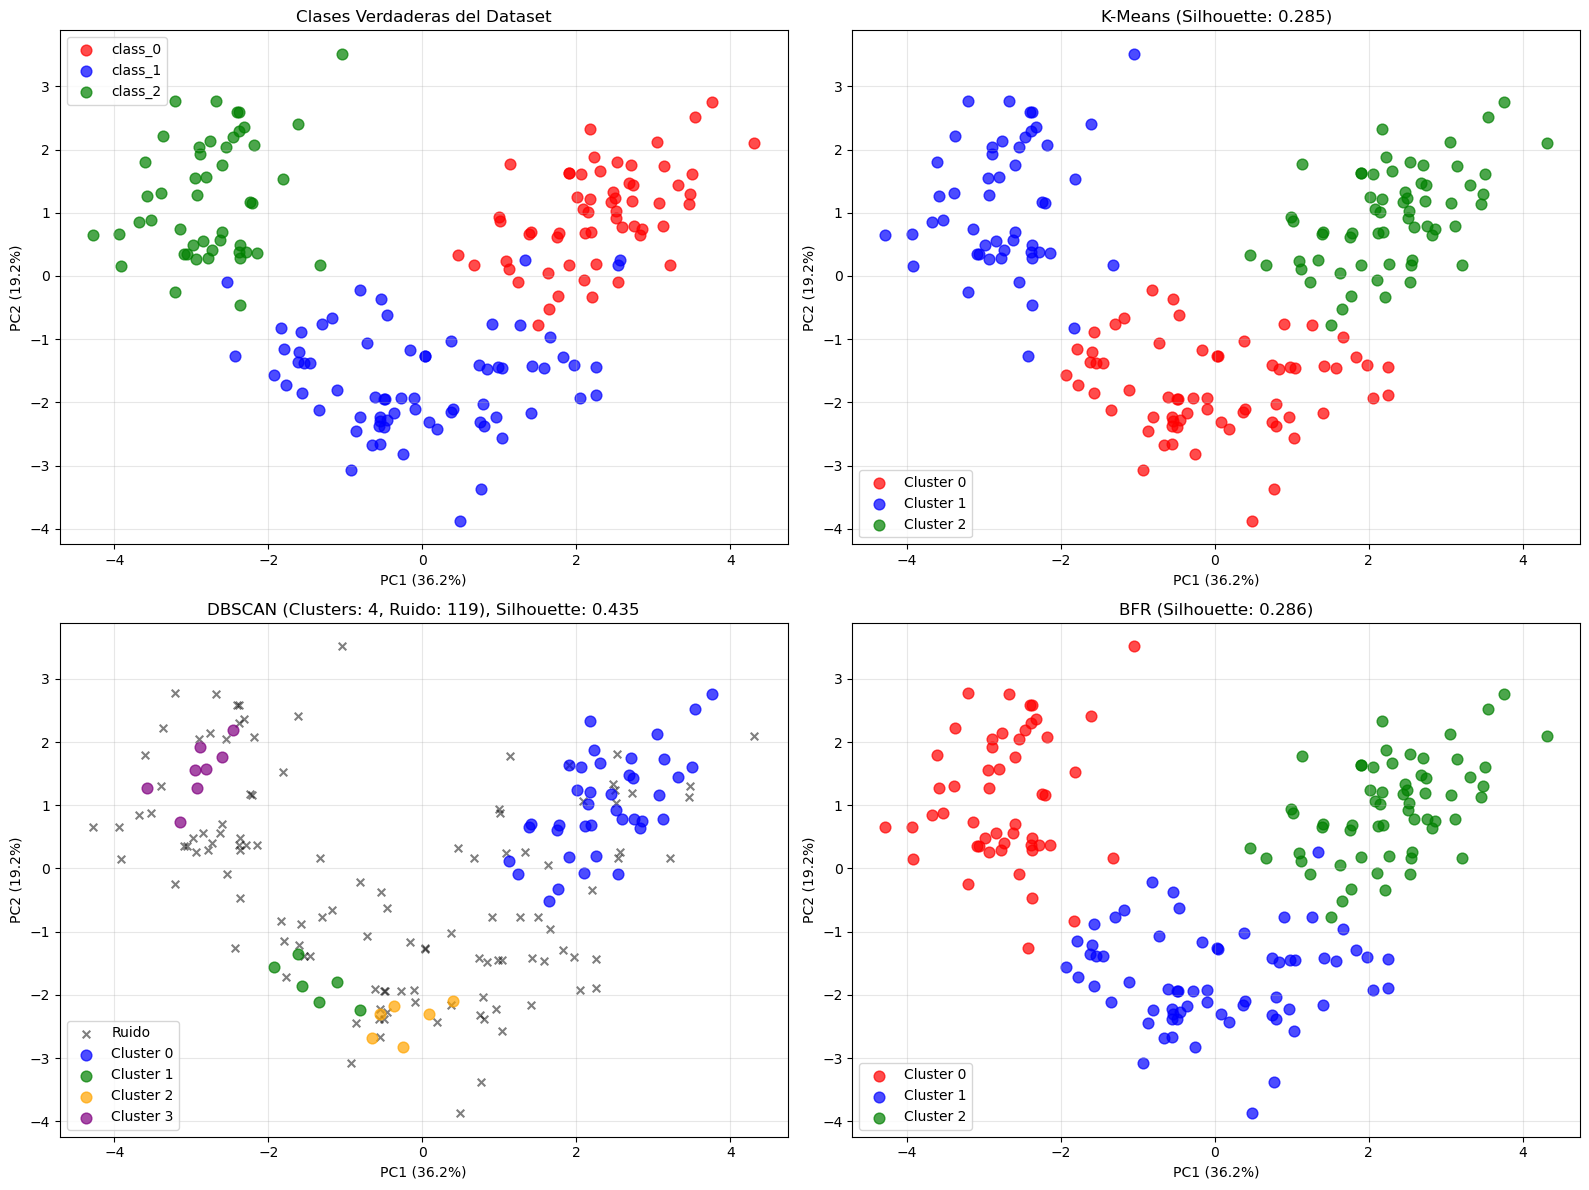

COMPARACIÓN CUANTITATIVA DE ALGORITMOS DE CLUSTERING
Algoritmo    Clusters  Silhouette  Calinski-H  ARI      Homog.   Compl.   V-meas. 
-------------------------------------------------------------------------------------
K-Means      3         0.285       70.94       0.897    0.879    0.873    0.876   
DBSCAN       4         0.435       38.31       0.213    0.376    0.421    0.397   
BFR          3         0.286       70.84       0.915    0.895    0.890    0.893   

RANKING POR MÉTRICA:
-------------------------

Silhouette:
  1. DBSCAN: 0.435
  2. BFR: 0.286
  3. K-Means: 0.285

Calinski-Harabasz:
  1. K-Means: 70.940
  2. BFR: 70.837
  3. DBSCAN: 38.307

ARI:
  1. BFR: 0.915
  2. K-Means: 0.897
  3. DBSCAN: 0.213

Homogeneidad:
  1. BFR: 0.895
  2. K-Means: 0.879
  3. DBSCAN: 0.376

Completitud:
  1. BFR: 0.890
  2. K-Means: 0.873
  3. DBSCAN: 0.421

V-measure:
  1. BFR: 0.893
  2. K-Means: 0.876
  3. DBSCAN: 0.397

RANKING GENERAL (suma de rankings):
-------------------------------

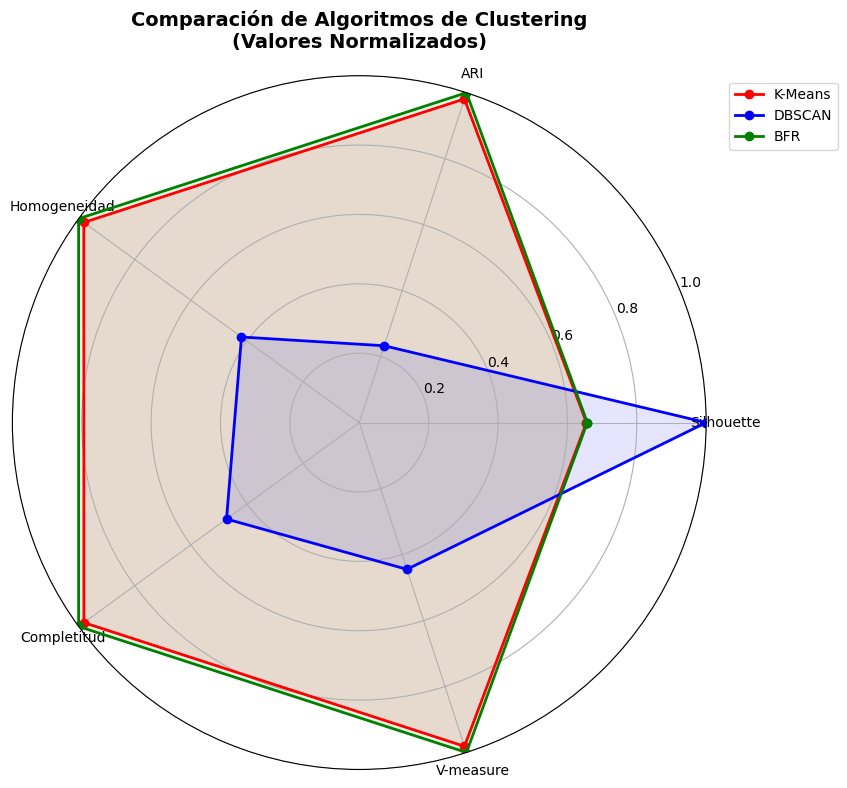


INTERPRETACIÓN DE RESULTADOS:
-----------------------------------
• El gráfico de radar muestra el rendimiento relativo de cada algoritmo
• Áreas más grandes indican mejor rendimiento general
• Cada métrica está normalizada para permitir comparación visual
• Los valores mostrados son relativos al mejor algoritmo en cada métrica


In [83]:
# Comparación visual y cuantitativa de todos los algoritmos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Colores para visualización
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# 1. Clases verdaderas
ax = axes[0, 0]
for i, name in enumerate(target_names):
    mask = y_true == i
    ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
              c=colors[i], label=f'{name}', alpha=0.7, s=60)
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax.set_title('Clases Verdaderas del Dataset')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Resultado K-Means
ax = axes[0, 1]
for i in np.unique(kmeans_labels):
    mask = kmeans_labels == i
    ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
              c=colors[i], label=f'Cluster {i}', alpha=0.7, s=60)
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax.set_title(f'K-Means (Silhouette: {kmeans_silhouette:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Resultado DBSCAN
ax = axes[1, 0]
unique_labels = np.unique(dbscan_labels)
for i, label in enumerate(unique_labels):
    mask = dbscan_labels == label
    if label == -1:
        # Puntos de ruido en negro
        ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                  c='black', label='Ruido', alpha=0.5, s=30, marker='x')
    else:
        ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                  c=colors[i % len(colors)], label=f'Cluster {label}', alpha=0.7, s=60)

dbscan_title = f'DBSCAN (Clusters: {dbscan_n_clusters}, Ruido: {dbscan_n_noise})'
if dbscan_silhouette > 0:
    dbscan_title += f', Silhouette: {dbscan_silhouette:.3f}'

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax.set_title(dbscan_title)
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Resultado BFR
ax = axes[1, 1]
for i in np.unique(bfr_labels):
    mask = bfr_labels == i
    ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
              c=colors[i % len(colors)], label=f'Cluster {i}', alpha=0.7, s=60)

bfr_title = f'BFR (Silhouette: {best_bfr_config["silhouette"]:.3f})' if best_bfr_config else 'BFR'
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax.set_title(bfr_title)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla comparativa de métricas
print("COMPARACIÓN CUANTITATIVA DE ALGORITMOS DE CLUSTERING")
print("=" * 65)

# Preparar datos para la tabla
algorithms = ['K-Means', 'DBSCAN', 'BFR']
silhouette_scores = [
    kmeans_silhouette,
    dbscan_silhouette if dbscan_silhouette > 0 else 0,
    best_bfr_config['silhouette'] if best_bfr_config else 0
]

calinski_scores = [
    kmeans_calinski,
    dbscan_calinski if dbscan_calinski > 0 else 0,
    bfr_calinski if 'bfr_calinski' in locals() else 0
]

ari_scores = [
    kmeans_ari,
    dbscan_ari if dbscan_ari > 0 else 0,
    best_bfr_config['ari'] if best_bfr_config else 0
]

homogeneity_scores = [
    kmeans_homogeneity,
    dbscan_homogeneity if dbscan_homogeneity > 0 else 0,
    bfr_homogeneity if 'bfr_homogeneity' in locals() else 0
]

completeness_scores = [
    kmeans_completeness,
    dbscan_completeness if dbscan_completeness > 0 else 0,
    bfr_completeness if 'bfr_completeness' in locals() else 0
]

v_measure_scores = [
    kmeans_v_measure,
    dbscan_v_measure if dbscan_v_measure > 0 else 0,
    bfr_v_measure if 'bfr_v_measure' in locals() else 0
]

n_clusters_found = [
    3,  # K-Means
    dbscan_n_clusters,
    best_bfr_config['n_clusters'] if best_bfr_config else 0
]

# Imprimir tabla
print(f"{'Algoritmo':<12} {'Clusters':<9} {'Silhouette':<11} {'Calinski-H':<11} {'ARI':<8} {'Homog.':<8} {'Compl.':<8} {'V-meas.':<8}")
print("-" * 85)

for i, alg in enumerate(algorithms):
    print(f"{alg:<12} {n_clusters_found[i]:<9} {silhouette_scores[i]:<11.3f} {calinski_scores[i]:<11.2f} "
          f"{ari_scores[i]:<8.3f} {homogeneity_scores[i]:<8.3f} {completeness_scores[i]:<8.3f} {v_measure_scores[i]:<8.3f}")

# Análisis de rankings
print(f"\nRANKING POR MÉTRICA:")
print("-" * 25)

metrics = {
    'Silhouette': silhouette_scores,
    'Calinski-Harabasz': calinski_scores,
    'ARI': ari_scores,
    'Homogeneidad': homogeneity_scores,
    'Completitud': completeness_scores,
    'V-measure': v_measure_scores
}

algorithm_rankings = {alg: 0 for alg in algorithms}

for metric_name, scores in metrics.items():
    # Ordenar por puntuación descendente
    sorted_indices = np.argsort(scores)[::-1]
    
    print(f"\n{metric_name}:")
    for rank, idx in enumerate(sorted_indices, 1):
        print(f"  {rank}. {algorithms[idx]}: {scores[idx]:.3f}")
        algorithm_rankings[algorithms[idx]] += rank

# Ranking general (menor suma de ranks = mejor)
print(f"\nRANKING GENERAL (suma de rankings):")
print("-" * 40)
sorted_algorithms = sorted(algorithm_rankings.items(), key=lambda x: x[1])

for rank, (alg, total_rank) in enumerate(sorted_algorithms, 1):
    print(f"{rank}. {alg}: {total_rank} puntos")

# Determinar el mejor algoritmo
best_algorithm = sorted_algorithms[0][0]
print(f"\nMEJOR ALGORITMO OVERALL: {best_algorithm}")

# Gráfico de radar para comparar algoritmos
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

# Métricas para el gráfico de radar (normalizadas a 0-1)
metric_names = ['Silhouette', 'ARI', 'Homogeneidad', 'Completitud', 'V-measure']
metric_values = [
    silhouette_scores,
    ari_scores,
    homogeneity_scores,
    completeness_scores,
    v_measure_scores
]

# Normalizar valores a 0-1 para cada métrica
normalized_values = []
for values in metric_values:
    max_val = max(values) if max(values) > 0 else 1
    normalized = [v / max_val for v in values]
    normalized_values.append(normalized)

# Ángulos para cada métrica
angles = np.linspace(0, 2 * np.pi, len(metric_names), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

# Colores para cada algoritmo
radar_colors = ['red', 'blue', 'green']

# Plotear cada algoritmo
for i, alg in enumerate(algorithms):
    values = [normalized_values[j][i] for j in range(len(metric_names))]
    values += values[:1]  # Cerrar el círculo
    
    ax.plot(angles, values, 'o-', linewidth=2, label=alg, color=radar_colors[i])
    ax.fill(angles, values, alpha=0.1, color=radar_colors[i])

# Configurar el gráfico
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_names)
ax.set_ylim(0, 1)
ax.set_title('Comparación de Algoritmos de Clustering\n(Valores Normalizados)', 
             size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

print(f"\nINTERPRETACIÓN DE RESULTADOS:")
print("-" * 35)
print(f"• El gráfico de radar muestra el rendimiento relativo de cada algoritmo")
print(f"• Áreas más grandes indican mejor rendimiento general")
print(f"• Cada métrica está normalizada para permitir comparación visual")
print(f"• Los valores mostrados son relativos al mejor algoritmo en cada métrica")